In [2]:
import os
import subprocess
import sys
import numpy as np
import itertools
import json
from tqdm import tqdm
from IPython.display import display, HTML
import time
import pickle
import copy
import scipy.stats
from collections import namedtuple, deque
top_level_dir = '/'.join( os.getcwd().split( '/' )[ :-2 ] )
if top_level_dir not in sys.path:
    sys.path.append( top_level_dir )
%load_ext autoreload
%autoreload 2
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
from GenModels.GM.Distributions import Categorical, Dirichlet, TensorTransition, TensorTransitionDirichletPrior
from GenModels.research.PedigreeLoader import load
from GenModels.research.PedigreeWrappers import Pedigree, PedigreeSexMatters
from GenModels.research.Models import *

In [4]:
np.random.seed( 2 )
graphs = load()

Graph 1011MB.json is incorrect. 3
Graph 1038CG.json is incorrect. -1
Graph 1044IO.json is incorrect. -1
Graph 1079JM.json is incorrect. 47
Graph 1083BF.json is incorrect. -1
Graph 2018LM.json is incorrect. -1
Graph 2049EE.json is incorrect. -1
Graph 2068AP.json is incorrect. 18
Graph 235TL.json is incorrect. 1
Graph 273PA.json is incorrect. 3
Graph 3011JB.json is incorrect. Edge before: 1 but tried setting: 2
Graph 3055CG.json is incorrect. -1
Graph 3086GA.json is incorrect. 4
Graph 316CD.json is incorrect. 10
Graph 3200BK.json is incorrect. 1
Graph 3203NZ.json is incorrect. 37
Graph 3216LP.json is incorrect. 13
Graph 3261MM.json is incorrect. 14
Graph 3267NF.json is incorrect. -1
Graph 329JR.json is incorrect. 2
Graph 3379KS.json is incorrect. Edge before: 6 but tried setting: 8
Graph 3420MZ.json is incorrect. 2
Graph 3427NF.json is incorrect. -1
Graph 346GT.json is incorrect. 27
Graph 3507AA.json is incorrect. 1
Graph 3515JA.json is incorrect. 2
Graph 3605JG.json is incorrect. -1
Gra

In [5]:
len( graphs )

430

In [6]:
# ad_graphs = [ ( graph, fbs ) for graph, fbs in graphs if graph.inheritancePattern == 'AD' if np.array( list( graph.data.values() ) ).sum() > 1 ]
# ar_graphs = [ ( graph, fbs ) for graph, fbs in graphs if graph.inheritancePattern == 'AR' if np.array( list( graph.data.values() ) ).sum() > 1 ]
# xl_graphs = [ ( graph, fbs ) for graph, fbs in graphs if graph.inheritancePattern == 'XL' if np.array( list( graph.data.values() ) ).sum() > 1 ]
ad_graphs = [ ( graph, fbs ) for graph, fbs in graphs if graph.inheritancePattern == 'AD' ]
ar_graphs = [ ( graph, fbs ) for graph, fbs in graphs if graph.inheritancePattern == 'AR' ]
xl_graphs = [ ( graph, fbs ) for graph, fbs in graphs if graph.inheritancePattern == 'XL' ]

print( 'Number of graphs for AD: %d AR: %d XL: %d'%( len( ad_graphs ), len( ar_graphs ), len( xl_graphs )) )

Number of graphs for AD: 132 AR: 197 XL: 98


# Estimating E[ P( Y ) ] using Mendellian priors is biased towards autosomal recessive

In [7]:
def evaluationGraphs( graph_and_fbs, set_latent_states=False, set_root_latent_states=True ):
    assert not( set_latent_states == True and set_root_latent_states == True )
    
    graph, fbs = graph_and_fbs

    graph_sex_matters = graph if isinstance( graph, PedigreeSexMatters ) else PedigreeSexMatters.fromPedigree( graph )
    graph_sex_doesnt_matters = graph if isinstance( graph, Pedigree ) else Pedigree.fromPedigreeSexMatters( graph )
    
    ad_graph = copy.deepcopy( graph_sex_doesnt_matters )
    ar_graph = copy.deepcopy( graph_sex_doesnt_matters )
    xl_graph = copy.deepcopy( graph_sex_matters )

    if( set_root_latent_states ):
        ad_graph.useRootDiagnosisImplication( 'AD' )
        ar_graph.useRootDiagnosisImplication( 'AR' )
        xl_graph.useRootDiagnosisImplication( 'XL' )        
    if( set_latent_states ):
        ad_graph.useDiagnosisImplication( 'AD' )
        ar_graph.useDiagnosisImplication( 'AR' )
        xl_graph.useDiagnosisImplication( 'XL' )


    return ( ad_graph, fbs ), ( ar_graph, fbs ), ( xl_graph, fbs )

def onlineMeanUpdate( mean, val, N ):
    return mean + ( val - mean ) / N

def normalizedScores( ad_score, ar_score, xl_score ):
    normalizer = np.logaddexp.reduce( [ ad_score, ar_score, xl_score ] )
    probs = np.array( [ np.exp( ad_score - normalizer ), np.exp( ar_score - normalizer ), np.exp( xl_score - normalizer ) ] )
    return probs

def distributionComparison( graph, samples=400, root_strength=4, strength=4, set_latent_states=False, set_root_latent_states=True ):

    # Fill in assumptions that we can make about each graph
    ad_graph, ar_graph, xl_graph = evaluationGraphs( graph, set_latent_states=set_latent_states, set_root_latent_states=set_root_latent_states )
    
    ad_scores, ar_scores, xl_scores = [], [], []
#     ad_score, ar_score, xl_score = 0.0, 0.0, 0.0
    
    ad_eval = AutosomalDominant( [ ad_graph ], root_strength=root_strength, prior_strength=strength, method='Gibbs' )
    for i in range( samples ):
        ad_eval.sampleParams()
        ad_scores.append( ad_eval.marginal() )
#         ad_score = onlineMeanUpdate( ad_score, ad_eval.marginal(), i+1 )
    ad_eval.msg.cleanup()
    
    ar_eval = AutosomalRecessive( [ ar_graph ], root_strength=root_strength, prior_strength=strength, method='Gibbs' )
    for i in range( samples ):
        ar_eval.sampleParams()
        ar_scores.append( ar_eval.marginal() )
#         ar_score = onlineMeanUpdate( ar_score, ar_eval.marginal(), i+1 )
    ar_eval.msg.cleanup()
    
    xl_eval = XLinkedRecessive( [ xl_graph ], root_strength=root_strength, prior_strength=strength, method='Gibbs' )
    for i in range( samples ):
        xl_eval.sampleParams()
        xl_scores.append( xl_eval.marginal() )
#         xl_score = onlineMeanUpdate( xl_score, xl_eval.marginal(), i+1 )     
    xl_eval.msg.cleanup()
                        
    ad_score = np.logaddexp.reduce( ad_scores ) - np.log( len( ad_scores ) )
    ar_score = np.logaddexp.reduce( ar_scores ) - np.log( len( ar_scores ) )
    xl_score = np.logaddexp.reduce( xl_scores ) - np.log( len( xl_scores ) )
    
    
    probs = normalizedScores( ad_score, ar_score, xl_score )
#     probs = normalizedScores( ad_score, ar_score, xl_score )
    
    # Sort the scores and return the corresponding inheritance pattern
    ad_comp = ( ad_score, 'AD' )
    ar_comp = ( ar_score, 'AR' )
    xl_comp = ( xl_score, 'XL' )
    
    possibilities = [ ad_comp, ar_comp, xl_comp ]
    return sorted( possibilities, key=lambda x: x[ 0 ] )[ -1 ][ 1 ], probs, ad_scores, ar_scores, xl_scores, ad_eval, ar_eval, xl_eval

In [8]:
def classAccuracy( label, predicted, true ):
    predicted_label = predicted[ true == label ]
    return ( predicted_label == label ).sum() / predicted_label.shape[ 0 ]

In [9]:
def confusionMatrix( predicted, true, labels ):
    mat = confusion_matrix( true, predicted, labels=labels )
    print( mat )
    mat = mat / mat.sum( axis=1 )[ :, None ]
    print( mat )
    plt.imshow( mat )
    plt.colorbar()
    plt.xticks( [ 0, 1, 2 ], labels )
    plt.yticks( [ 0, 1, 2 ], labels )
    plt.show()
    print( 'Number of AD', len( [ t for t in true if t == 'AD' ] ) )
    print( 'Number of AR', len( [ t for t in true if t == 'AR' ] ) )
    print( 'Number of XL', len( [ t for t in true if t == 'XL' ] ) )
    print( 'AD Accuracy:', mat[ 0,0 ] )
    print( 'AR Accuracy:', mat[ 1,1 ] )
    print( 'XL Accuracy:', mat[ 2,2 ] )
    print( 'Cohen Kappa', cohen_kappa_score( true, predicted ) )

In [10]:
def fullPredictions( ad_graphs, ar_graphs, xl_graphs, N=100, root_strength=4, strength=4, set_latent_states=False, set_root_latent_states=True ):
    n_graphs = len( ad_graphs ) + len( ar_graphs ) + len( xl_graphs )
    results = []
    with tqdm( total=n_graphs ) as pbar:
        for graph in ad_graphs:
            res = distributionComparison( graph, samples=N, set_latent_states=set_latent_states, set_root_latent_states=set_root_latent_states, root_strength=root_strength, strength=strength )
            ip, probs, _, _, _, ad_eval, ar_eval, xl_eval = res
            results.append( ( graph, ip, 'AD', probs, ad_eval, ar_eval, xl_eval ) )
            pbar.update( 1 )

        for graph in ar_graphs:
            res = distributionComparison( graph, samples=N, set_latent_states=set_latent_states, set_root_latent_states=set_root_latent_states, root_strength=root_strength, strength=strength ) 
            ip, probs, _, _, _, ad_eval, ar_eval, xl_eval = res
            results.append( ( graph, ip, 'AR', probs, ad_eval, ar_eval, xl_eval ) )
            pbar.update( 1 )

        for graph in xl_graphs:
            res = distributionComparison( graph, samples=N, set_latent_states=set_latent_states, set_root_latent_states=set_root_latent_states, root_strength=root_strength, strength=strength ) 
            ip, probs, _, _, _, ad_eval, ar_eval, xl_eval = res
            results.append( ( graph, ip, 'XL', probs, ad_eval, ar_eval, xl_eval ) )
            pbar.update( 1 )
            
    _, predicted, true, _, _, _, _ = list( zip( *results ) )
    
    confusionMatrix( predicted, true, [ 'AD', 'AR', 'XL' ] )
    
    return results

In [11]:
from sklearn.metrics import confusion_matrix, cohen_kappa_score
import matplotlib.pyplot as plt

In [12]:
def softMatrix( results ):
    _, predicted, true, all_probs, _, _, _ = list( zip( *results ) )
    ad_probs = np.array( [ p for p, t in zip( all_probs, true ) if t == 'AD' ] )
    ar_probs = np.array( [ p for p, t in zip( all_probs, true ) if t == 'AR' ] )
    xl_probs = np.array( [ p for p, t in zip( all_probs, true ) if t == 'XL' ] )
    ad_soft = ad_probs.sum( axis=0 ) / ad_probs.sum()
    ar_soft = ar_probs.sum( axis=0 ) / ar_probs.sum()
    xl_soft = xl_probs.sum( axis=0 ) / xl_probs.sum()
    return np.vstack( ( ad_soft, ar_soft, xl_soft ) )

In [13]:
N = 100
# Randomly sample 10 graphs from each class to do inference on
K = 5
ind_ad = np.random.choice( len( ad_graphs ), size=min( K, len( ad_graphs ) ), replace=False )
ind_ar = np.random.choice( len( ar_graphs ), size=min( K, len( ar_graphs ) ), replace=False )
ind_xl = np.random.choice( len( xl_graphs ), size=min( K, len( xl_graphs ) ), replace=False )

In [14]:
# ad_test = [ ad_graphs[ i ] for i in ind_ad if ad_graphs[ i ][ 0 ].getNumbAffected() > 1 ]
# ar_test = [ ar_graphs[ i ] for i in ind_ar if ar_graphs[ i ][ 0 ].getNumbAffected() > 1 ]
# xl_test = [ xl_graphs[ i ] for i in ind_xl if xl_graphs[ i ][ 0 ].getNumbAffected() > 1 ]
ad_test = [ ad_graphs[ i ] for i in ind_ad ]
ar_test = [ ar_graphs[ i ] for i in ind_ar ]
xl_test = [ xl_graphs[ i ] for i in ind_xl ]
print( 'len( ad_test )', len( ad_test ) )
print( 'len( ar_test )', len( ar_test ) )
print( 'len( xl_test )', len( xl_test ) )

len( ad_test ) 5
len( ar_test ) 5
len( xl_test ) 5


In [15]:
RETRAIN = False

In [16]:
if( RETRAIN ):
    # results = fullPredictions( ad_graphs, ar_graphs, xl_graphs, N=3, root_strength=1000000000, strength=10000, set_latent_states=False )
    # results = fullPredictions( ad_test, ar_test, xl_test, N=5, root_strength=1000000000, strength=10000, set_latent_states=False, set_root_latent_states=True )
    # results = fullPredictions( ad_test, ar_test, xl_test, N=8, root_strength=1000000000, strength=1000000, set_latent_states=True, set_root_latent_states=False )
    results = fullPredictions( ad_graphs, ar_graphs, xl_graphs, N=20, root_strength=1000000000, strength=1000000, set_latent_states=True, set_root_latent_states=False )
else:
    results = pickle.load( open( 'full_results.p', 'rb' ) )

In [17]:
softMatrix( results )

ValueError: not enough values to unpack (expected 7, got 4)

In [ ]:
results[ 0 ][ 0 ][ 0 ].draw()

In [ ]:
# it = iter( [ r for r in results if r[ 1 ] != r[ 2 ] ] )

In [ ]:
# ( graph, _ ), predicted, true, prob, ad, ar, xl = next( it )
# print( 'Predicted:', predicted, ', True:', true, ', Prob:', prob )
# display( ad.draw( show_carrier_prob=True ) )
# print( '---------------------------------------------------------------------------------------' )
# display( ar.draw( show_carrier_prob=True ) )
# print( '---------------------------------------------------------------------------------------' )
# display( xl.draw( show_carrier_prob=True ) )

In [ ]:
assert 0

In [ ]:
ad_consanguinity = [ ( ( graph, fbs ), ip, prob ) for ( graph, fbs ), ip, prob in ad_results if fbs.shape[ 0 ] > 0 ]
ar_consanguinity = [ ( ( graph, fbs ), ip, prob ) for ( graph, fbs ), ip, prob in ar_results if fbs.shape[ 0 ] > 0 ]
xl_consanguinity = [ ( ( graph, fbs ), ip, prob ) for ( graph, fbs ), ip, prob in xl_results if fbs.shape[ 0 ] > 0 ]

In [ ]:
len( xl_consanguinity )

In [ ]:
def check( it ):
    current_graph = next( it )
    ( graph, fbs ), true_ip, prob = current_graph
    print( 'True IP:', true_ip, 'probs', prob, 'fbs', fbs )
    return graph.draw()

In [ ]:
it = iter( ar_consanguinity )

In [ ]:
check( it )

1: Percentage of males affected
2: Number of affected people
3: Number of affected generations

# Generate 10 random pedigrees with varying percentage of affected males

# This should be 2d, x axis -> number of affected, y axis -> percentage of males affected


In [ ]:
def randomPedigreeShape():
    # Probability of mating with new person / existing person / being single
    # New person -> p.  Remaining 1-p
    #    In remaining, select existing person with prob proportional to age similarity
    #    Remaining is going to being single
    # Probability of generating male / female / stopping
    #    New child -> q.  Remining 1-q
    
    pass

In [ ]:
Person = namedtuple( 'Person', [ 'name', 'sex', 'shaded' ] )

def matingProcess( n_initial=3, 
                   new_mate_prob=0.5, 
                   mate_unshaded_prob=0.9,
                   no_consanguinity_prob=1.0,
                   n_children_prob=0.65,
                   son_unshaded_prob=0.9,
                   daughter_unshaded_prob=0.9 ):
    people = []
    graph = Pedigree()
    q = deque()
    
    n_initial = 3
    for i in range( n_initial ):
        sex = 'female' if np.random.random() > 0.5 else 'male'
        shading = 0
        person = Person( i, sex, shading )
        q.append( person )
        people.append( person )
    
    while( len( q ) > 0 ):
        
        p = q.popleft()
    
        # Choose who to mate with
        if( np.random.random() < new_mate_prob ):
            m = len( people ) + 1
            m_sex = 'female' if p.sex == 'male' else 'male'
            m_shaded = 1 if np.random.random() > mate_unshaded_prob else 0
            mate = Person( m, m_sex, m_shaded )
            people.append( mate )
        else:
            if( np.random.random() > no_consanguinity_prob ):
                # Skipping this for the moment
                assert 0
            else:
                continue
                
        if( m is None ):
            continue
            
        # Choose how many kids to have
        numb_children = scipy.stats.geom( p=n_children_prob ).rvs( size=1 )
        children = []
        for c in range( numb_children[ 0 ] ):
            c = len( people ) + 1
            c_sex, unshaded_prob = ( 'female', daughter_unshaded_prob ) if np.random.random() > 0.5 else ( 'male', son_unshaded_prob )
            c_shaded = 1 if np.random.random() > unshaded_prob else 0
            child = Person( c, c_sex, c_shaded )
            q.append( child )
            people.append( child )
            children.append( child )
            
        sorted_parents = sorted( [ p, mate ], key=lambda x: x.sex )
        parent_ids = [ _p.name for _p in sorted_parents ]
        child_ids = [ _c.name for _c in children ]        
        graph.addEdge( parents=parent_ids, children=child_ids )
        
        for n in sorted_parents + children:
            graph.setNodeAttrs( n.name, { 'sex': n.sex, 'affected': n.shaded } )
        
        if( len( people ) > 50 ):
            # Max number of people
            return graph
            
    return graph

In [ ]:
graphs = []
for _ in range( 5 ):
    graph = matingProcess( n_initial=3, 
                            new_mate_prob=0.8, 
                            mate_unshaded_prob=0.95,
                            no_consanguinity_prob=1.0,
                            n_children_prob=0.65,
                            son_unshaded_prob=0.9,
                            daughter_unshaded_prob=0.9 )
    graphs.append( graph )
    
for graph in graphs:
    n_males = sum( [ 1 for _, sex, shaded in graph.people if sex == 'male' ] )
    n_females = sum( [ 1 for _, sex, shaded in graph.people if sex == 'male' ] )    
    n_shaded_males = sum( [ 1 for _, sex, shaded in graph.people if sex == 'male' and shaded == 1 ] )
    n_shaded_females = sum( [ 1 for _, sex, shaded in graph.people if sex == 'female' and shaded == 1 ] )
    print( 'n', len( graph.people ), 'n_males', n_males, 'n_females', n_females, 'n_shaded_males', n_shaded_males, 'n_shaded_females', n_shaded_females )
    display( graph.draw() )
    assert 0

In [ ]:
graph.draw()

In [34]:
print( len( ad_confident_correct ) + len( ad_confident_wrong ) )
print( len( ar_confident_correct ) + len( ar_confident_wrong ) )
print( len( xl_confident_correct ) + len( xl_confident_wrong ) )

89
61
64


In [35]:
all_confident = ad_confident_correct + ad_confident_wrong + ar_confident_correct + ar_confident_wrong + xl_confident_correct + xl_confident_wrong

In [36]:
len( all_confident )

214

In [ ]:
folder_name = 'all_confident'
if( False ):
    for ( graph, fbs ), predicted, true_ip, prob in all_confident:
        d = graph.draw()
        name = folder_name + '/%s__AD_%1.2f_AR_%1.2f_XL_%1.2f_TRUE_%s_PRED_%s'%( graph.studyID, prob[ 0 ], prob[ 1 ], prob[ 2 ], true_ip, predicted )
        print( name )
        d.render( name, view=False, cleanup=True )

In [ ]:
true_ips = list( zip( *all_confident ) )[ -2 ]
predicted_ips = list( zip( *all_confident ) )[ -3 ]
labels = [ 'AD', 'AR', 'XL' ]
true_ips = np.array( [ labels.index( ip ) for ip in true_ips ] )
predicted_ips = np.array( [ labels.index( ip ) for ip in predicted_ips ] )

In [ ]:
confusionMatrix( true_ips, predicted_ips, labels=[0,1,2] )

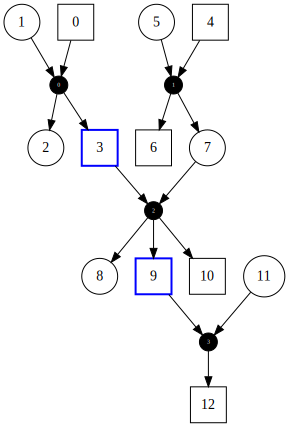

Inheritance guessAD


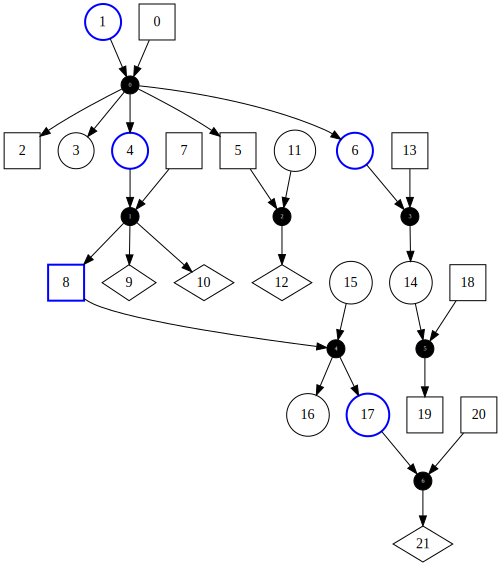

Inheritance guessAD


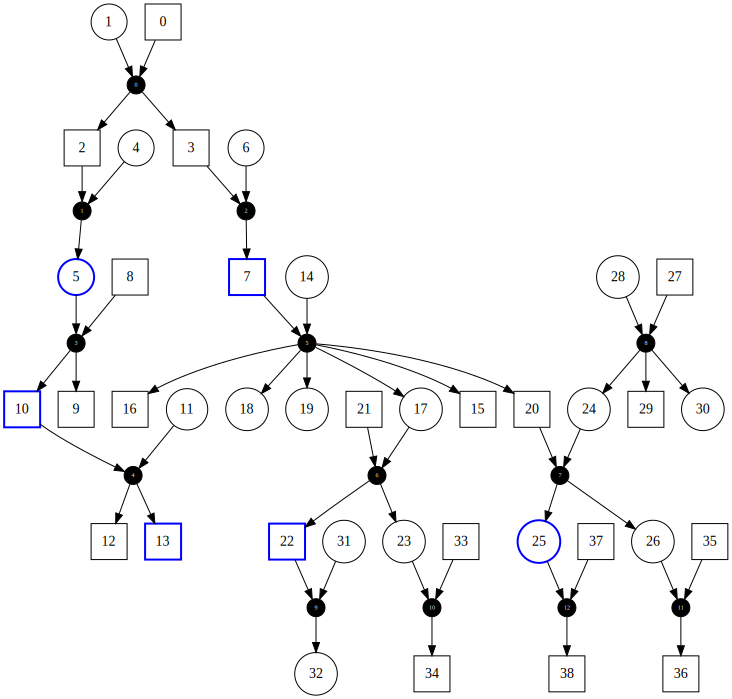

Inheritance guessXL


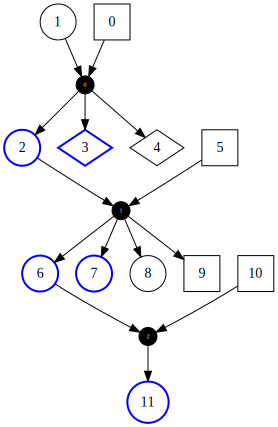

Inheritance guessAD


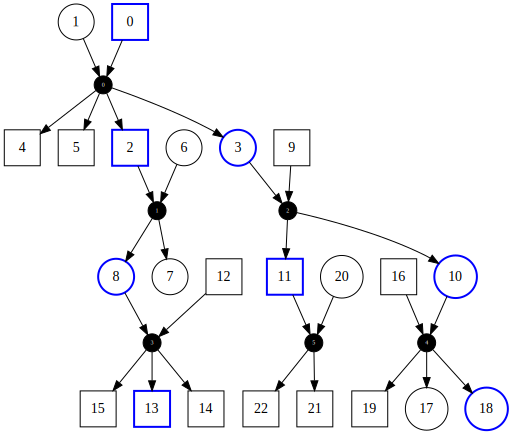

Inheritance guessAD


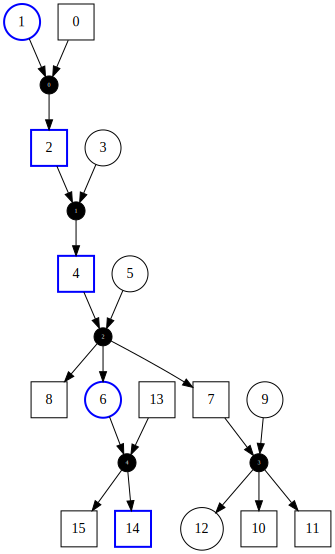

Inheritance guessAD


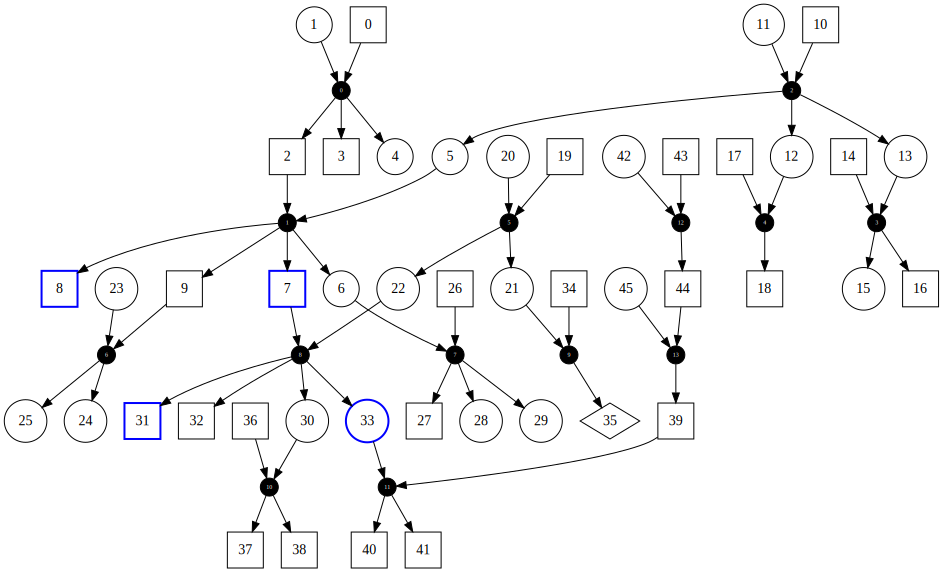

Inheritance guessAD


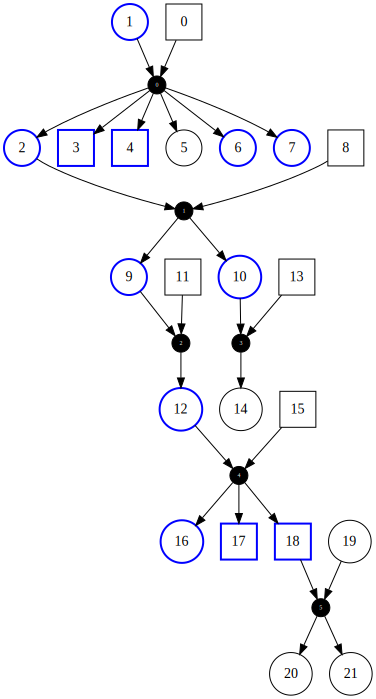

Inheritance guessAD


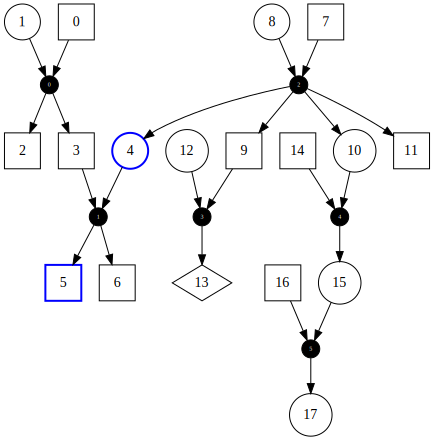

Inheritance guessAD


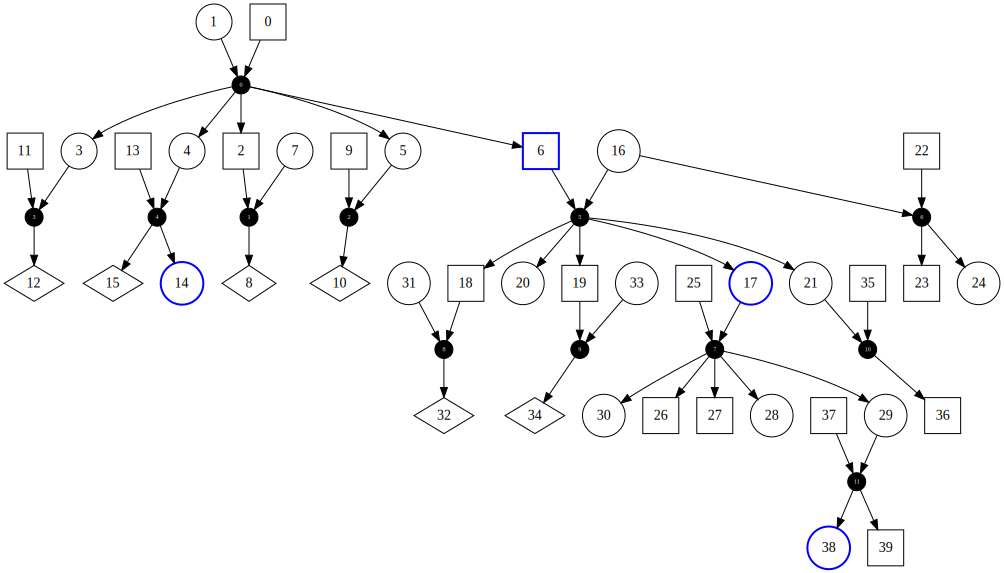

Inheritance guessAD


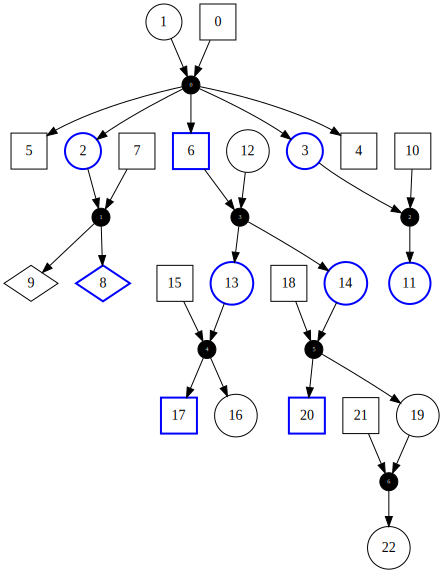

Inheritance guessAD


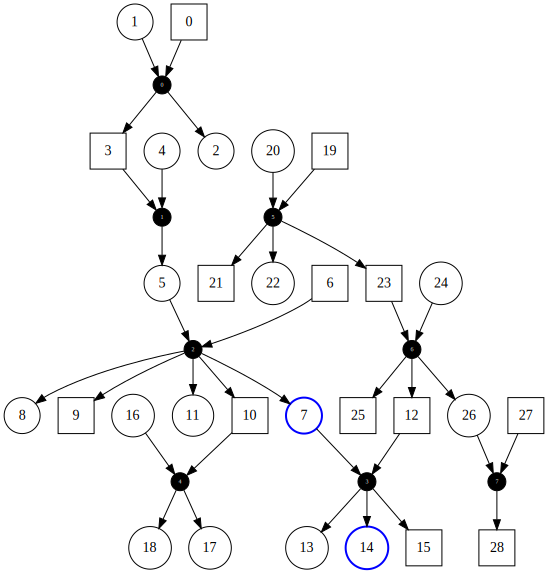

Inheritance guessAD


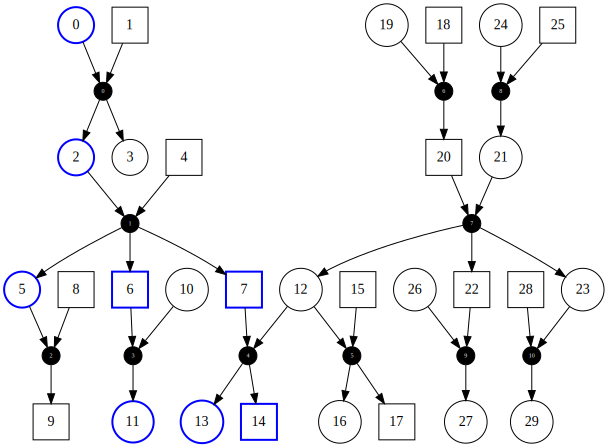

Inheritance guessAD


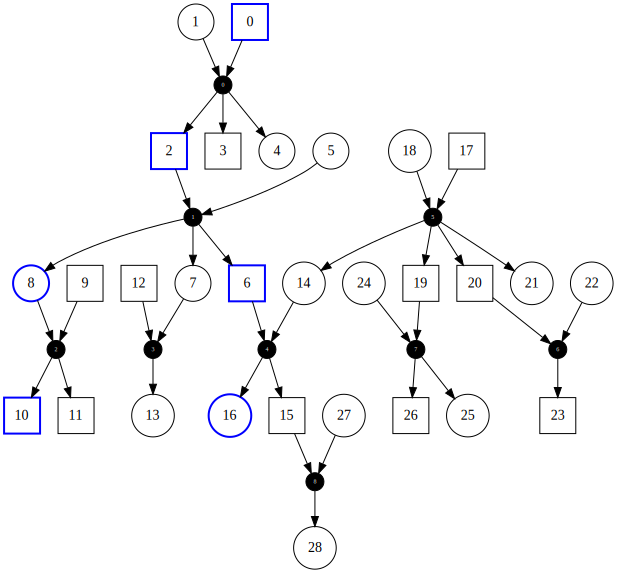

Inheritance guessAD


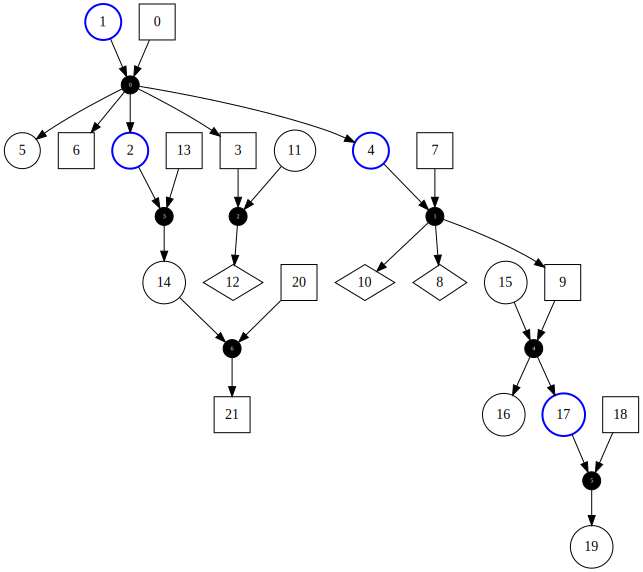

Inheritance guessAD


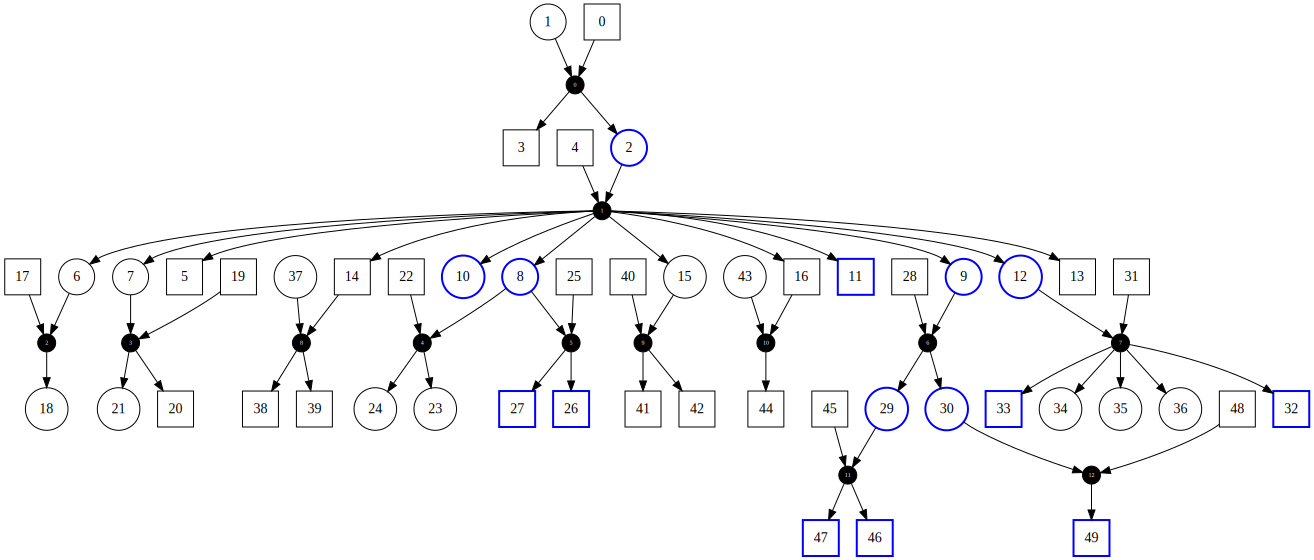

Inheritance guessAD


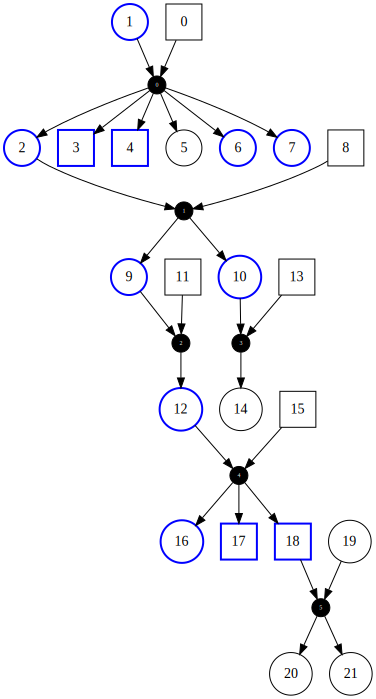

Inheritance guessAD


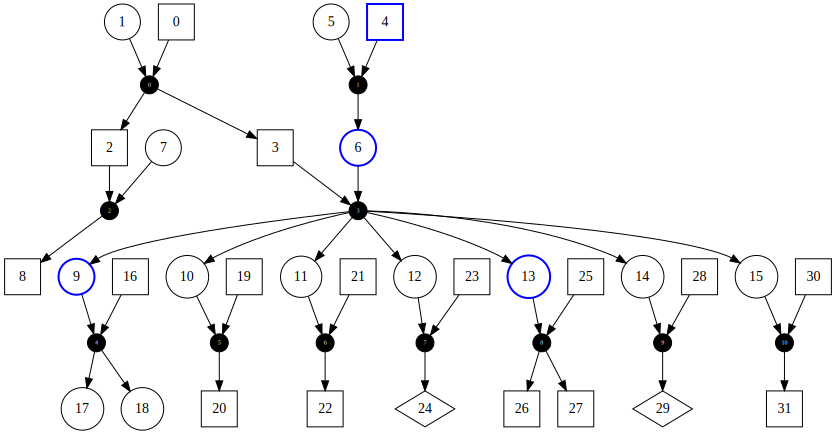

Inheritance guessAD


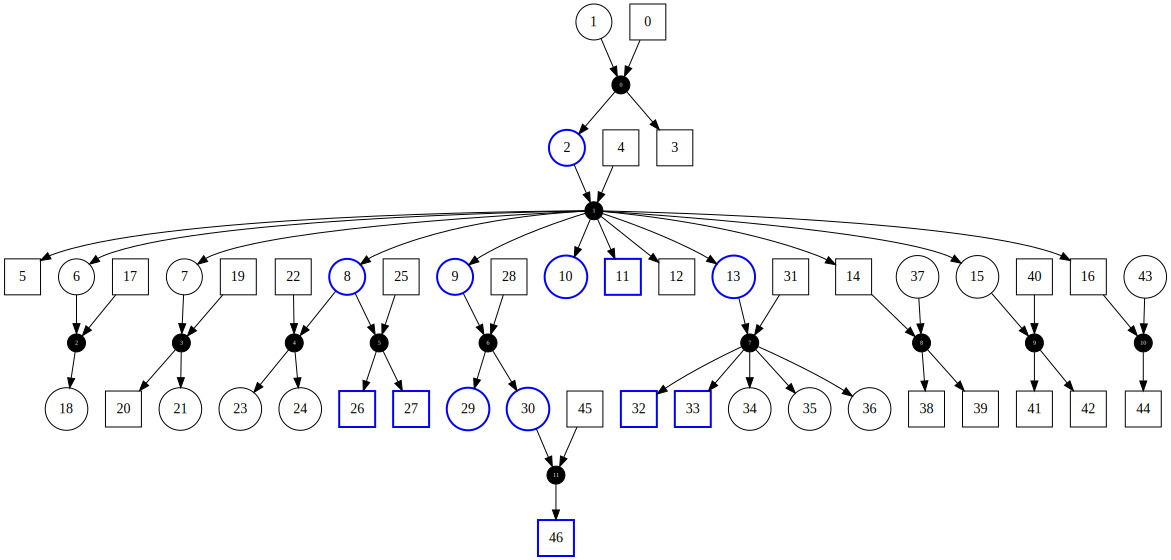

Inheritance guessAD


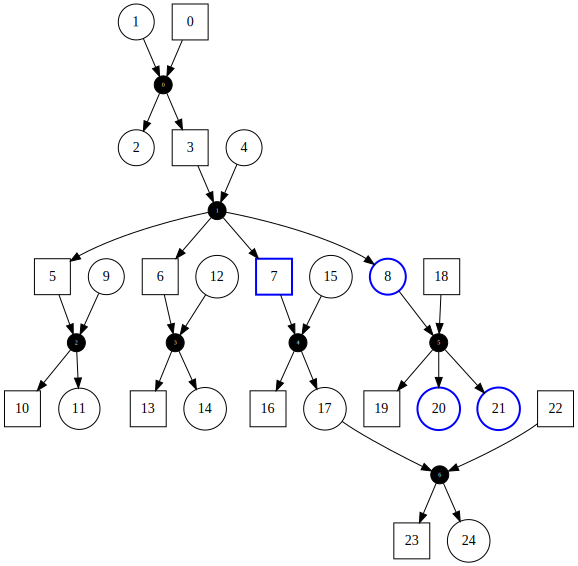

Inheritance guessAD


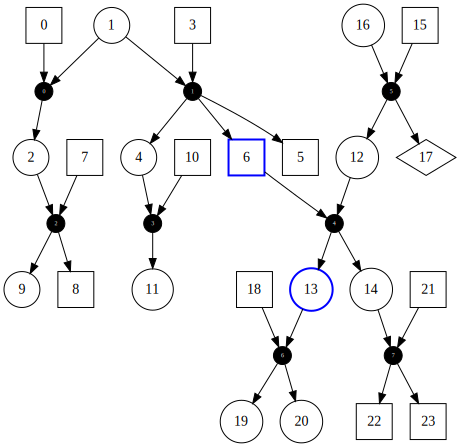

Inheritance guessAD


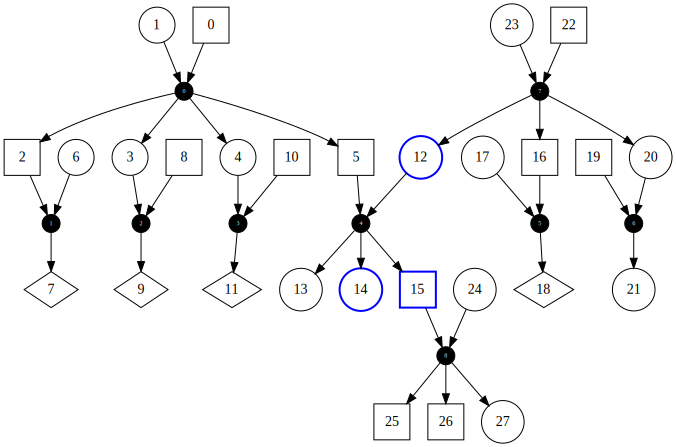

Inheritance guessAD


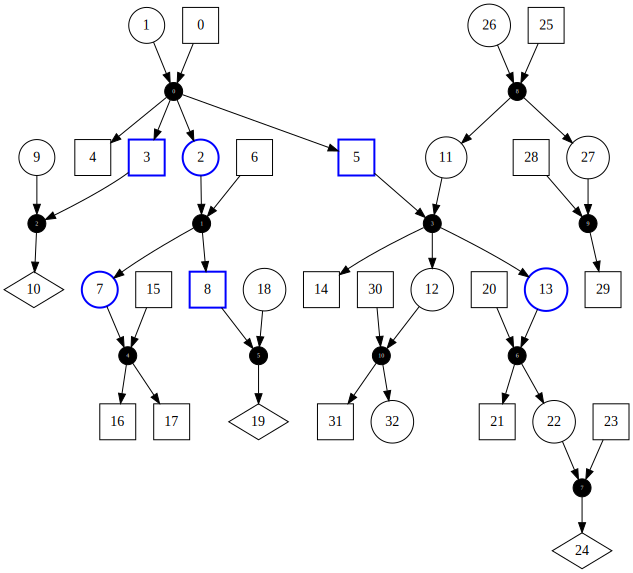

Inheritance guessAD


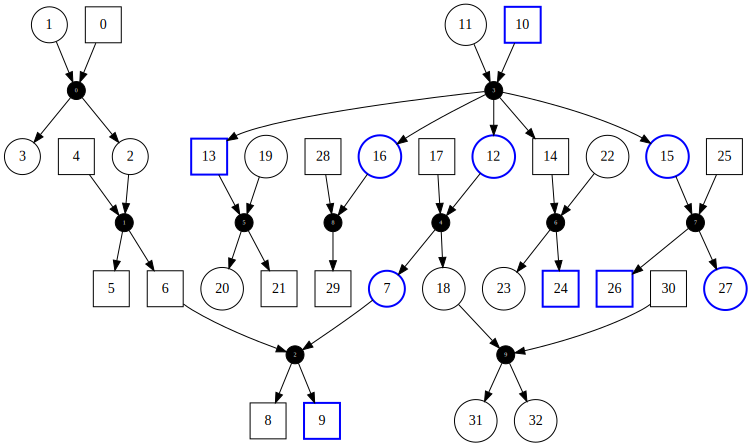

Inheritance guessAD


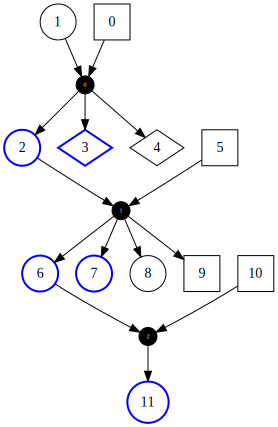

Inheritance guessAD


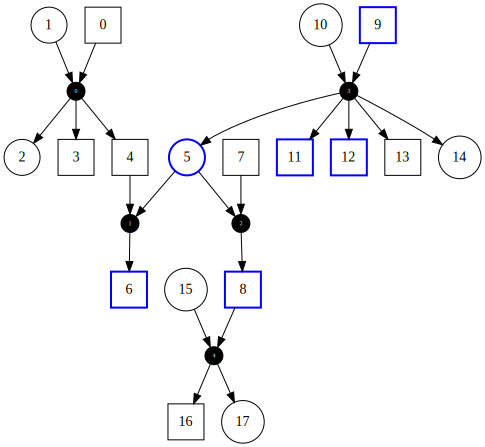

Inheritance guessAD


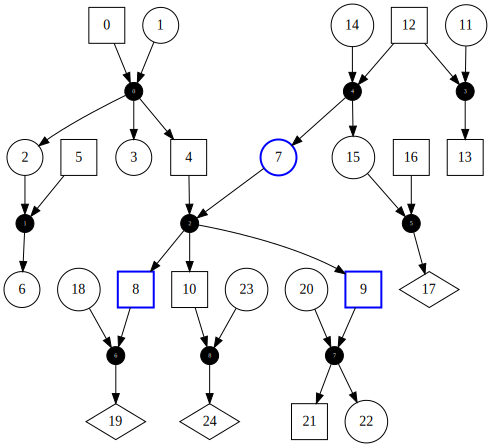

Inheritance guessAD


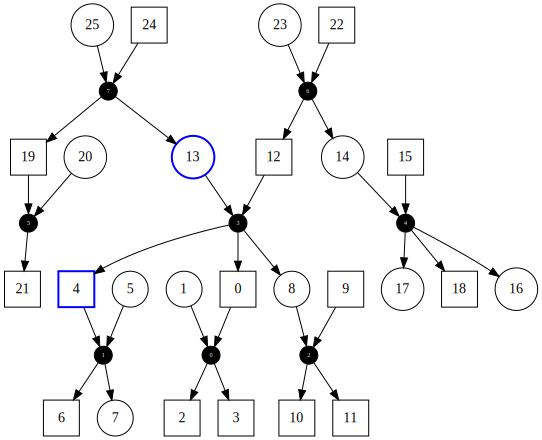

Inheritance guessAD


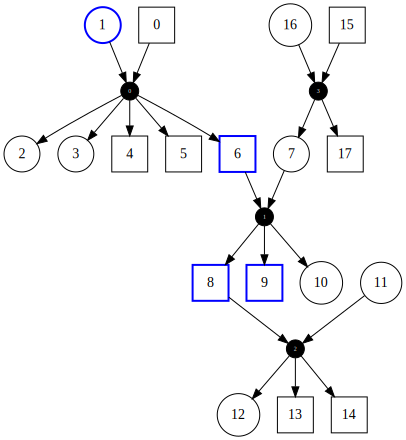

Inheritance guessAD


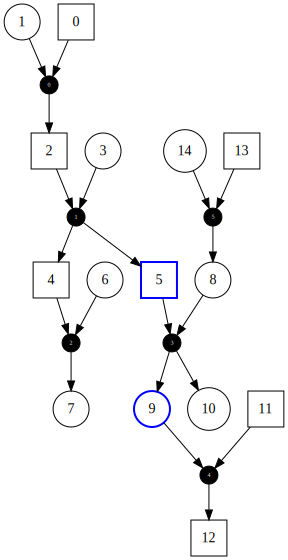

Inheritance guessAD


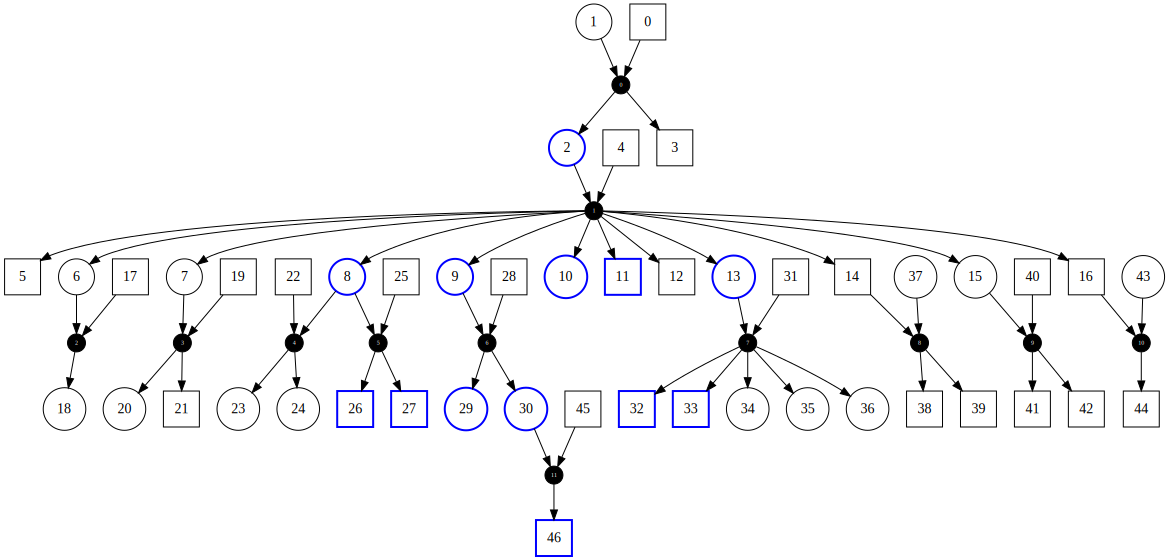

Inheritance guessAD


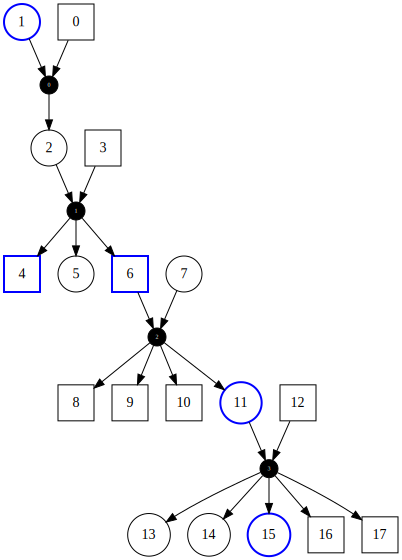

Inheritance guessAD


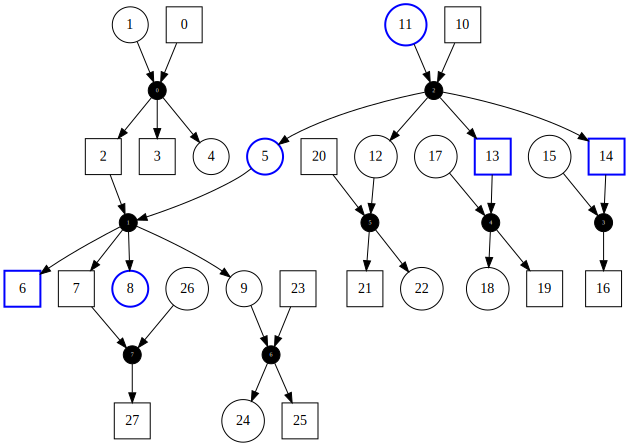

Inheritance guessAD


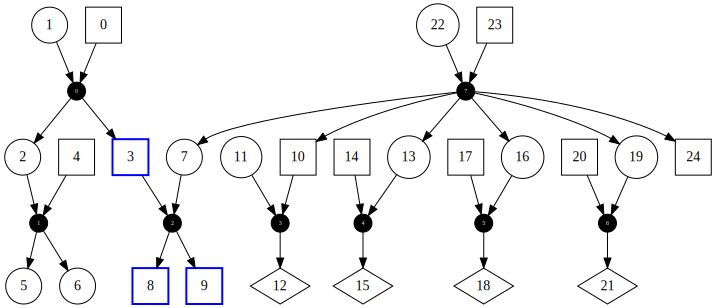

Inheritance guessAD


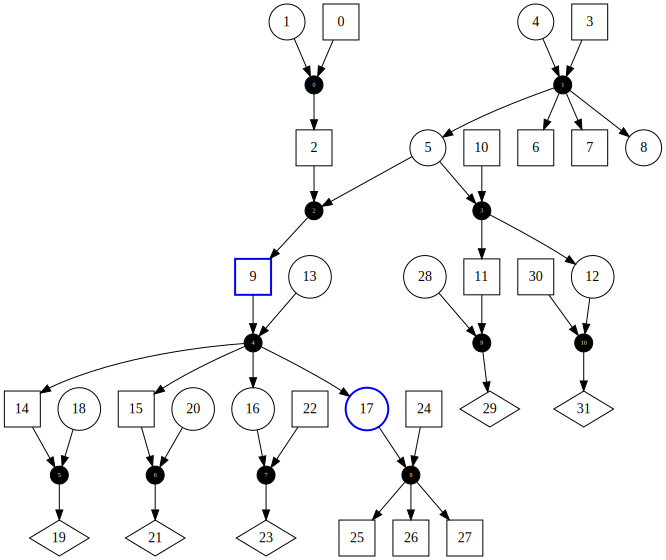

Inheritance guessAD


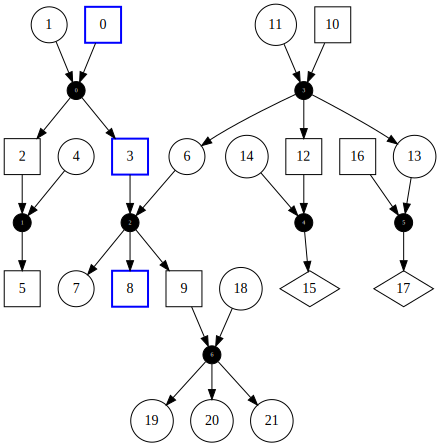

Inheritance guessAD


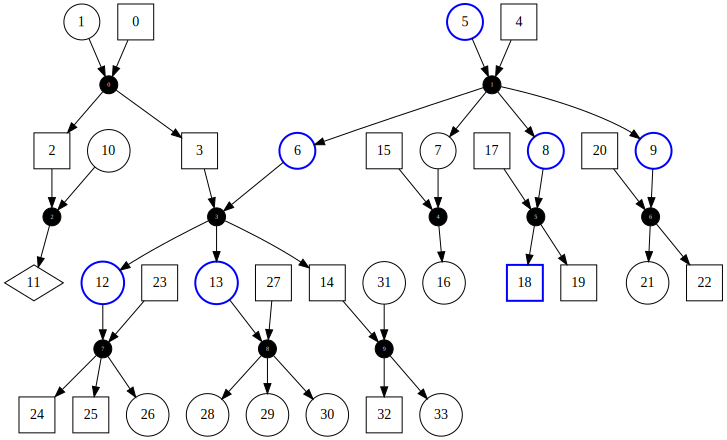

Inheritance guessAD


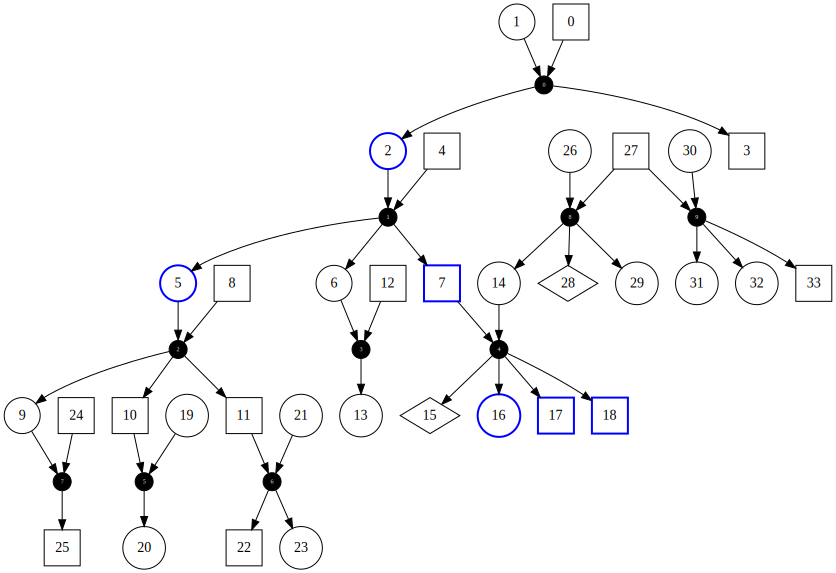

Inheritance guessAD


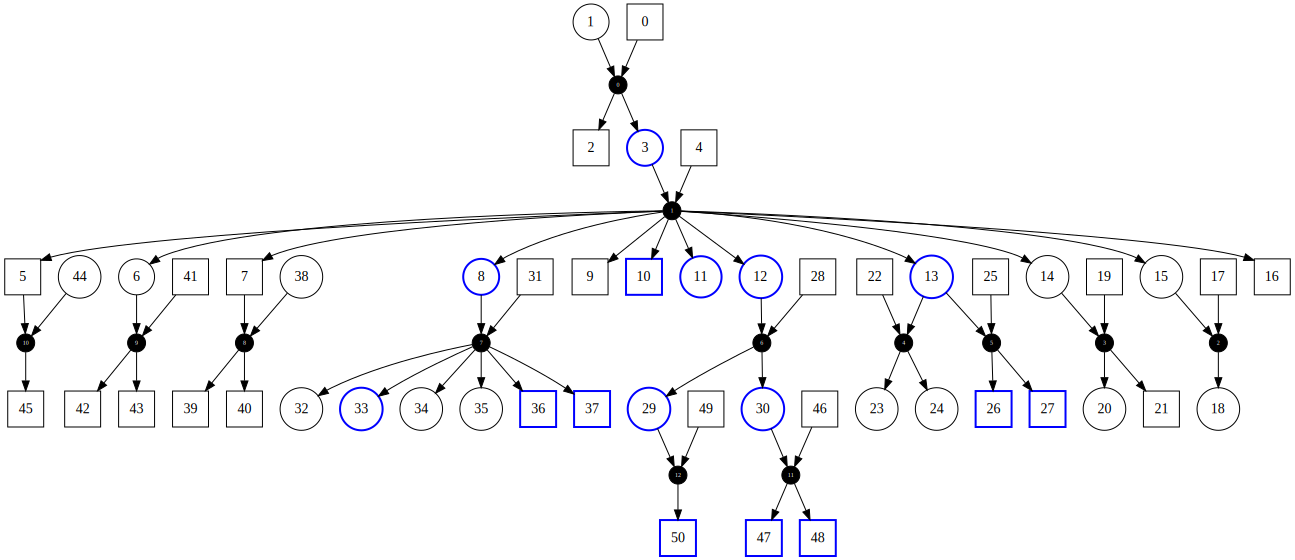

Inheritance guessAD


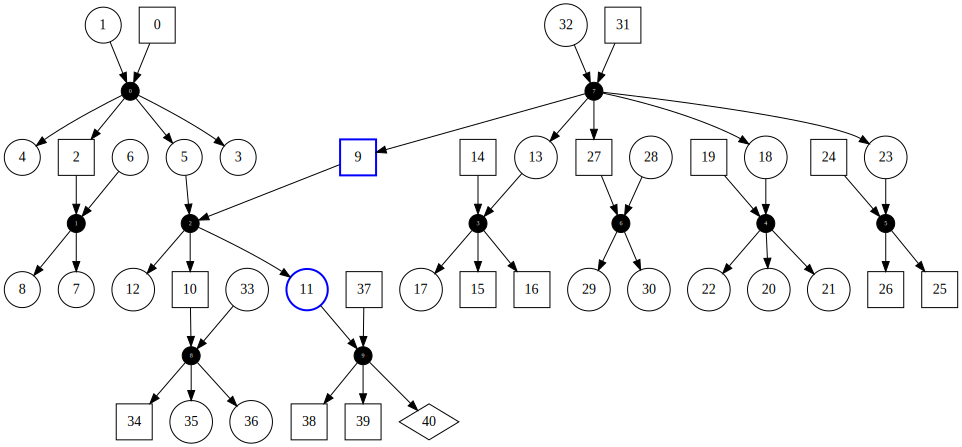

Inheritance guessAD


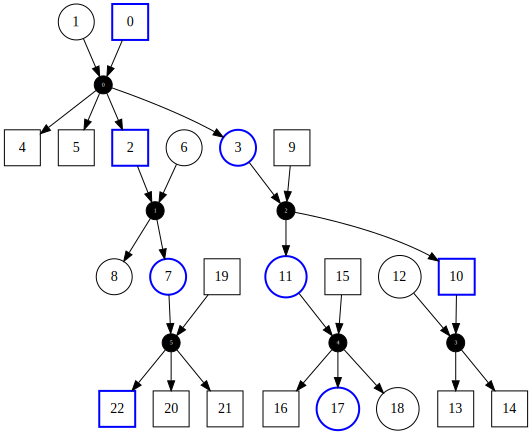

Inheritance guessAD


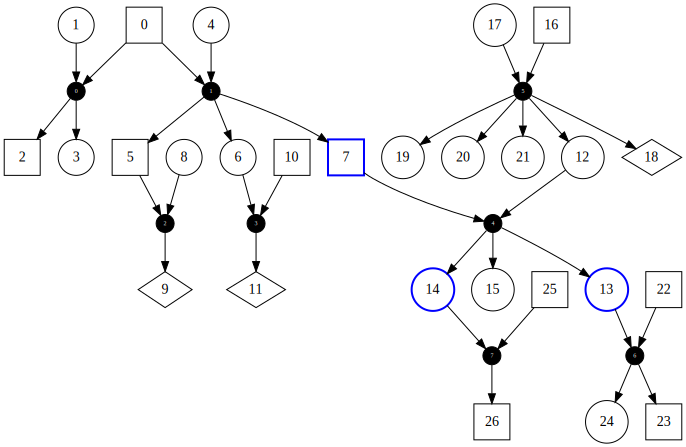

Inheritance guessAD


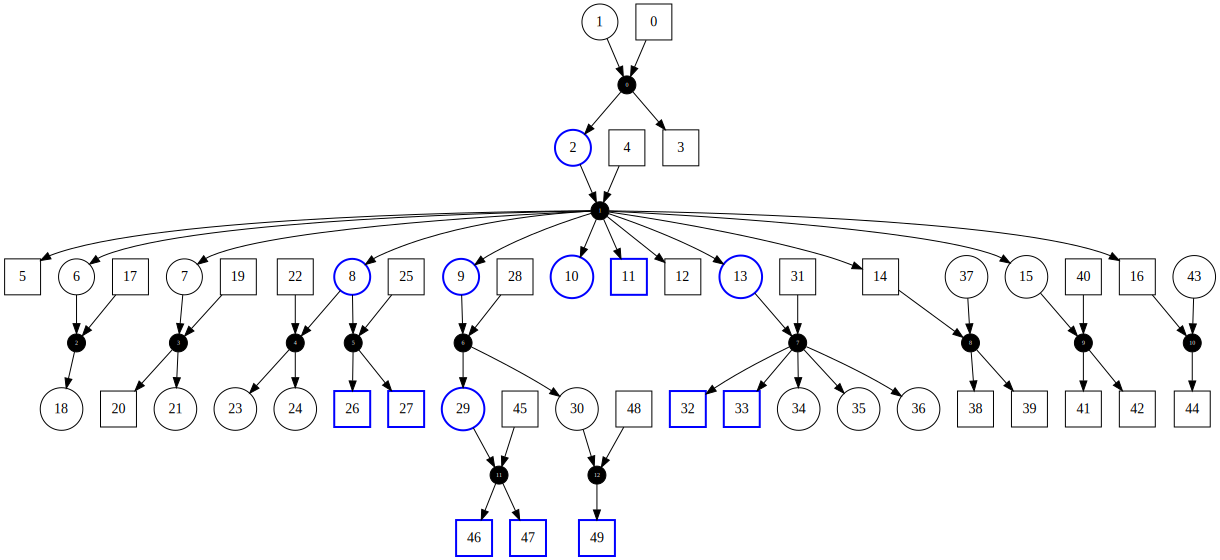

Inheritance guessAD


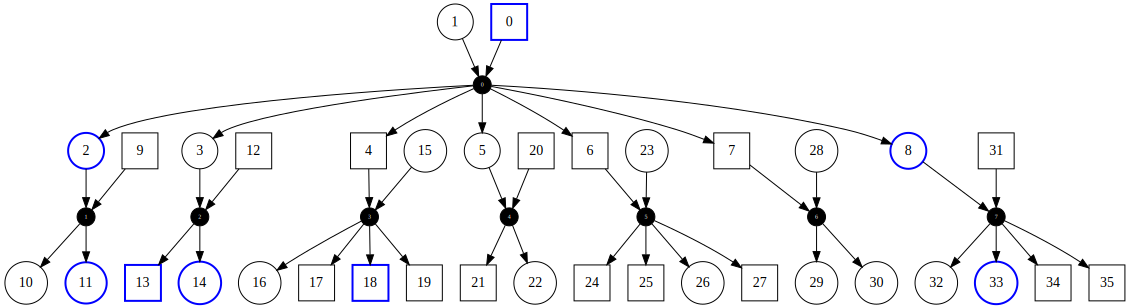

Inheritance guessAD


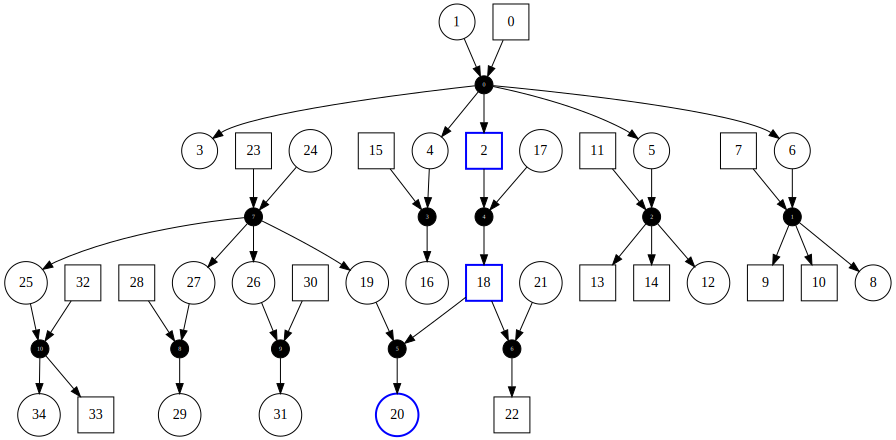

Inheritance guessAD


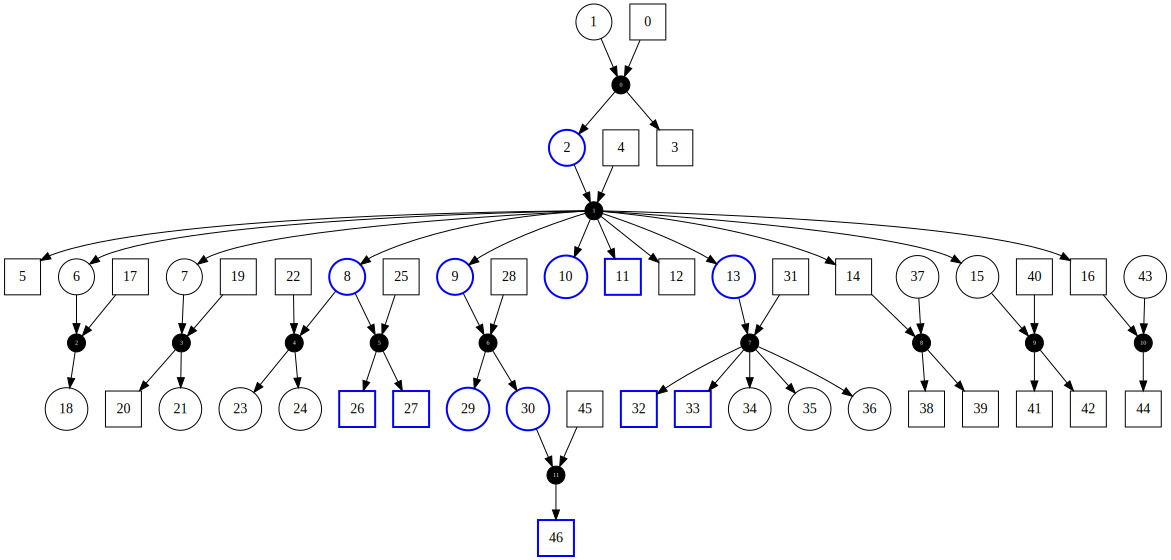

Inheritance guessAD


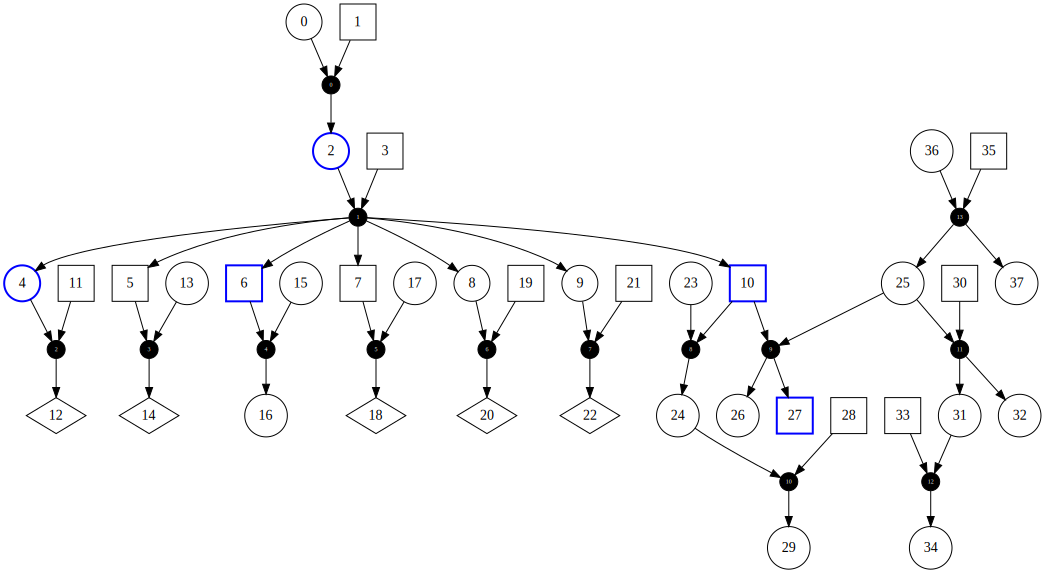

Inheritance guessAD


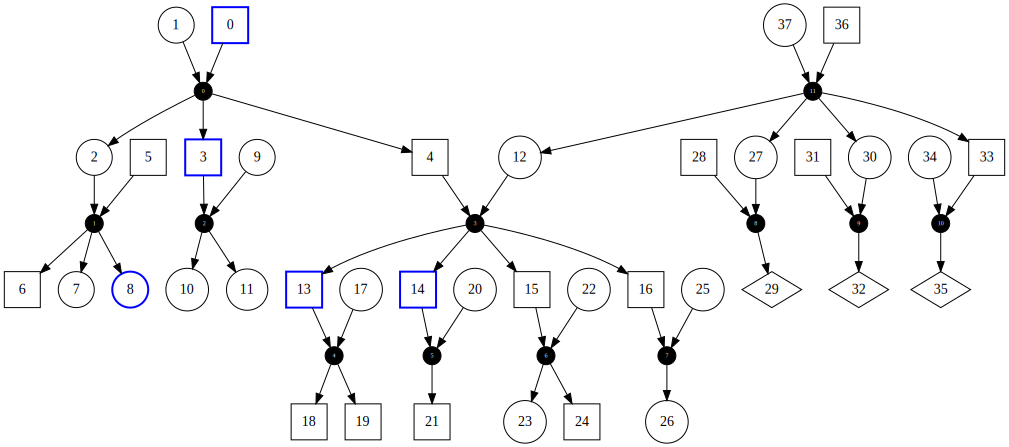

Inheritance guessAD


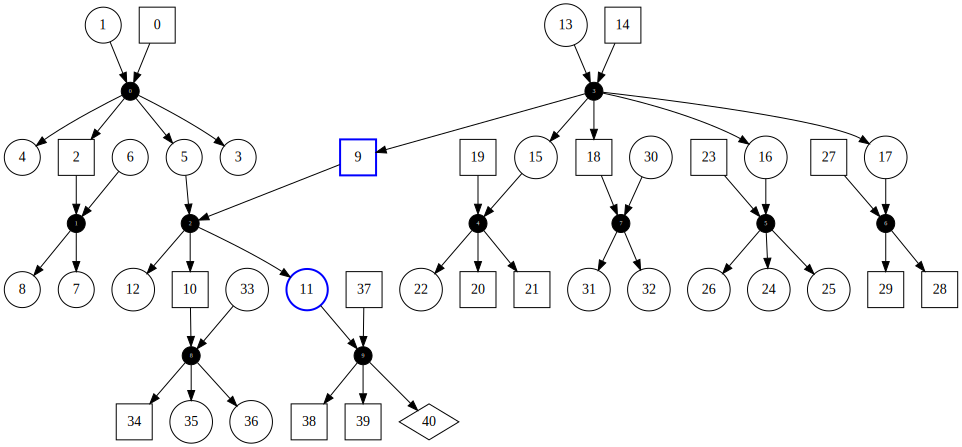

Inheritance guessAD


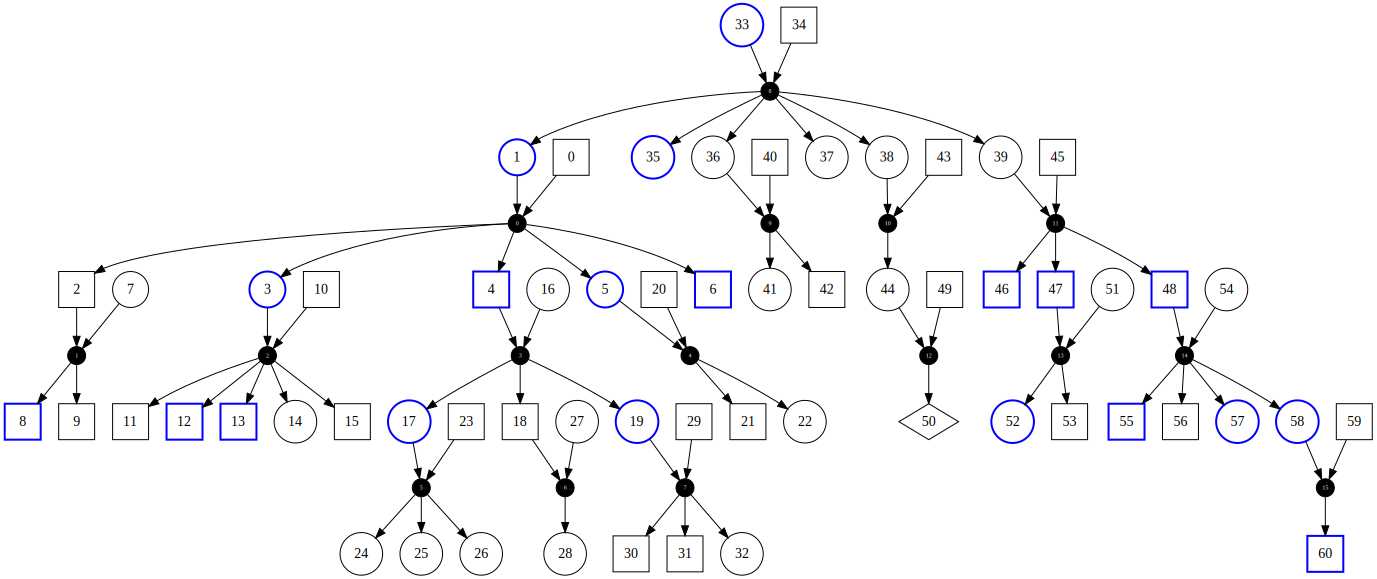

Inheritance guessAD


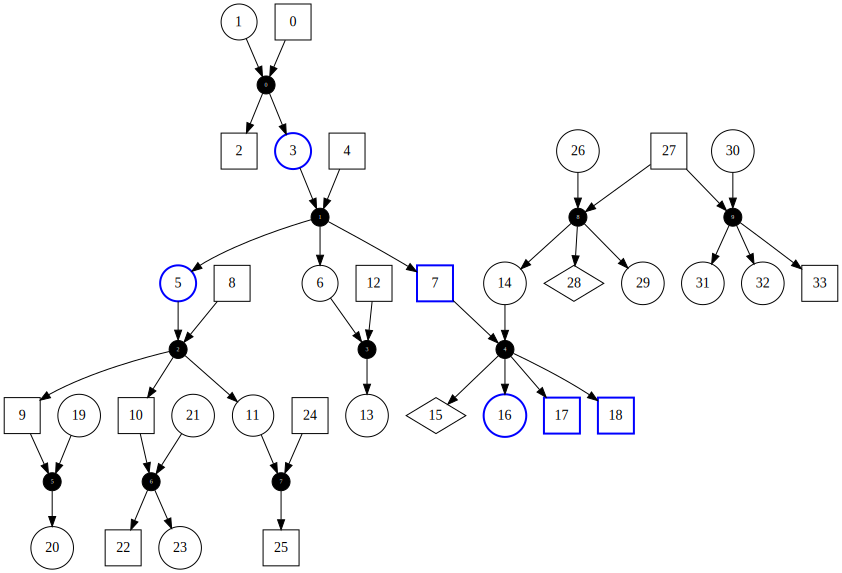

Inheritance guessAD


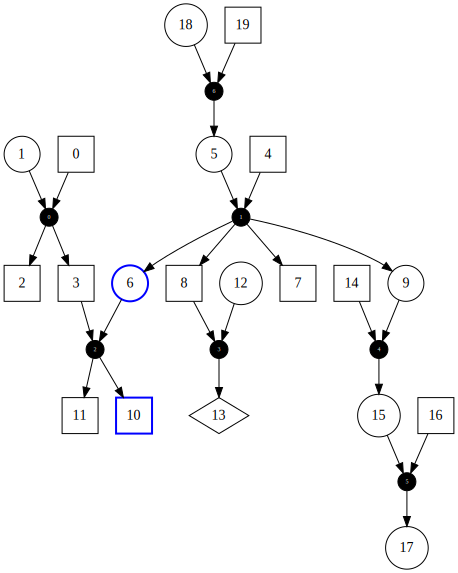

Inheritance guessAD


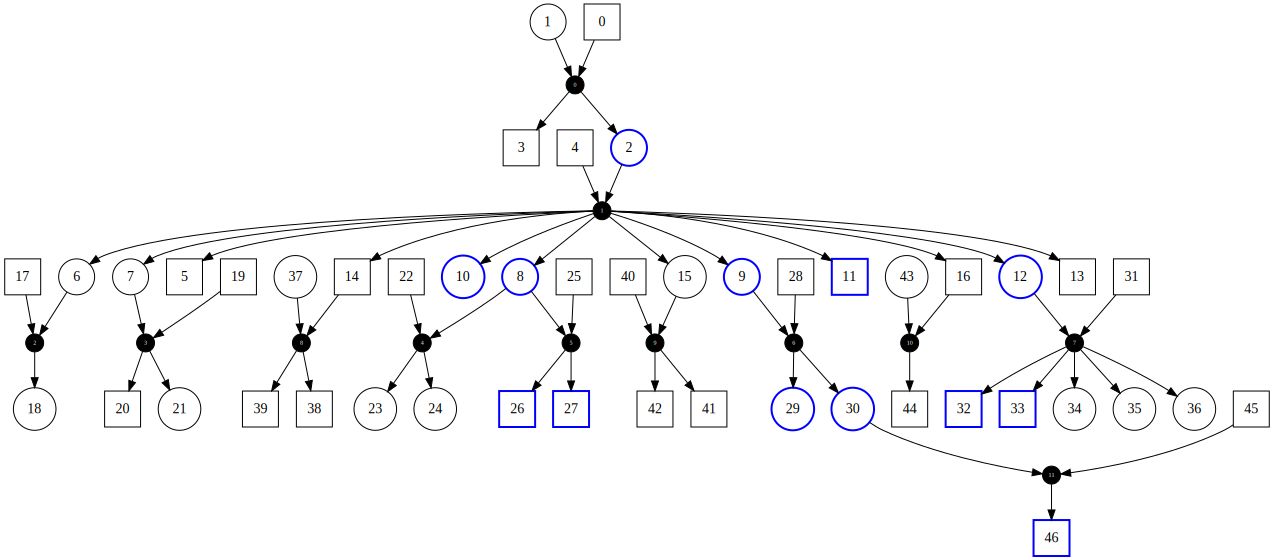

Inheritance guessAD


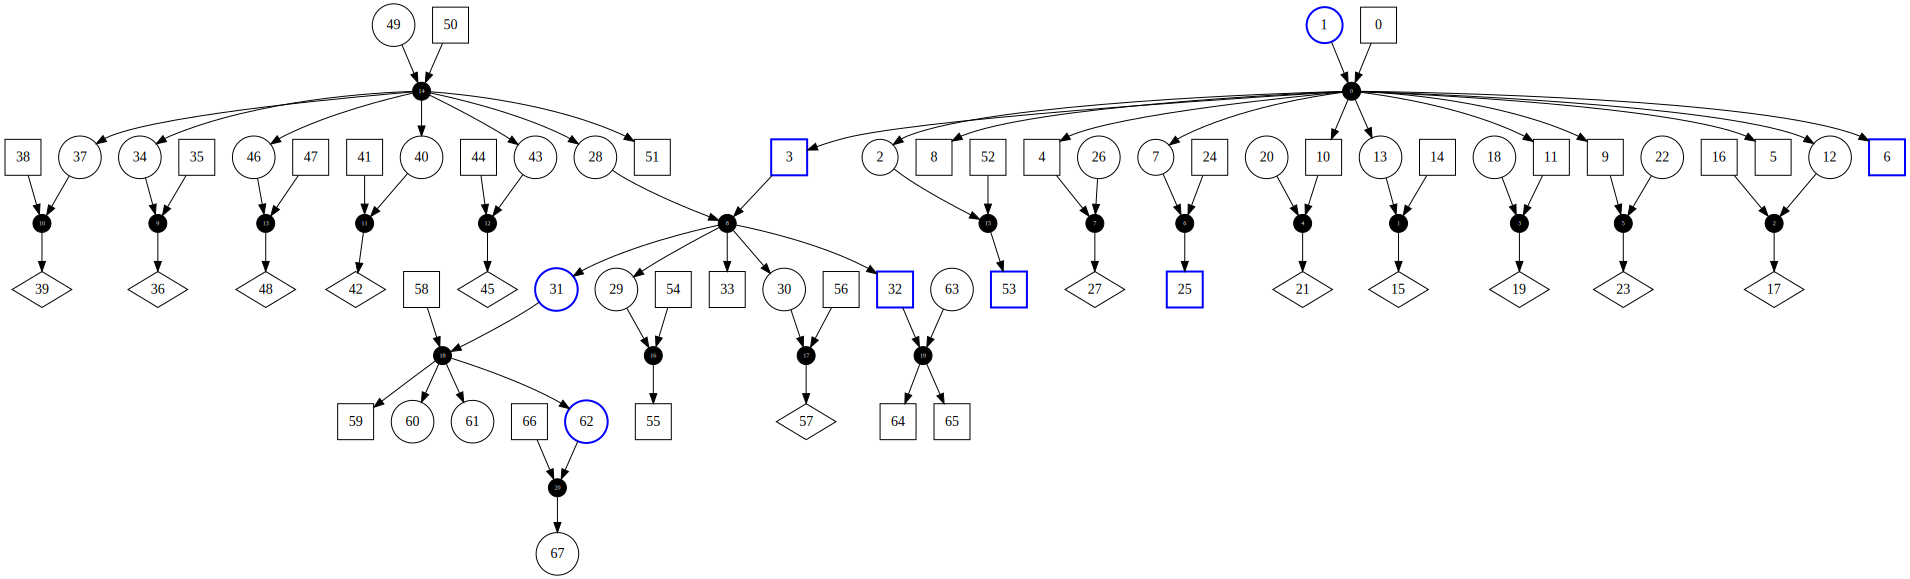

Inheritance guessAD


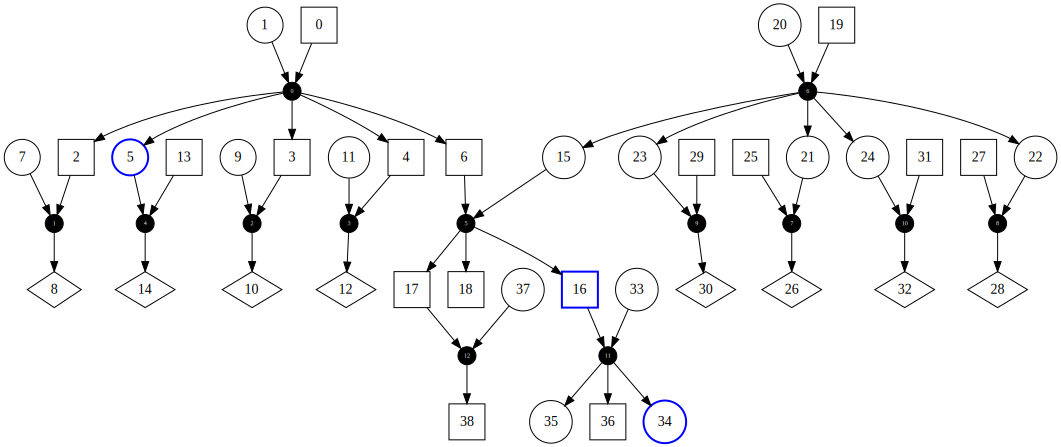

Inheritance guessAD


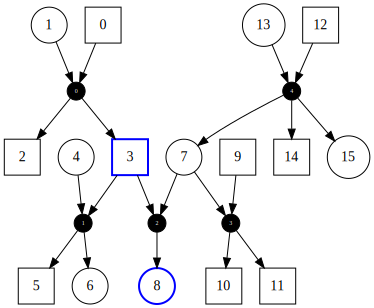

Inheritance guessAD


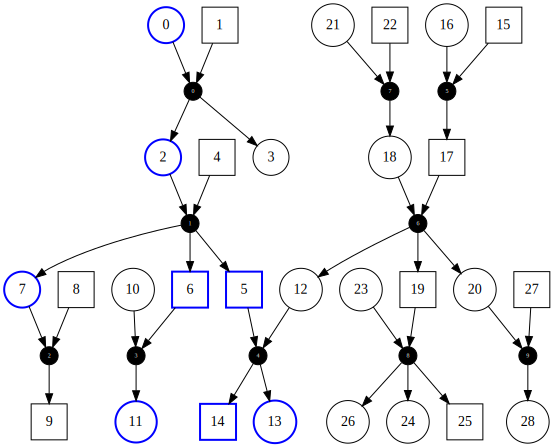

Inheritance guessAD


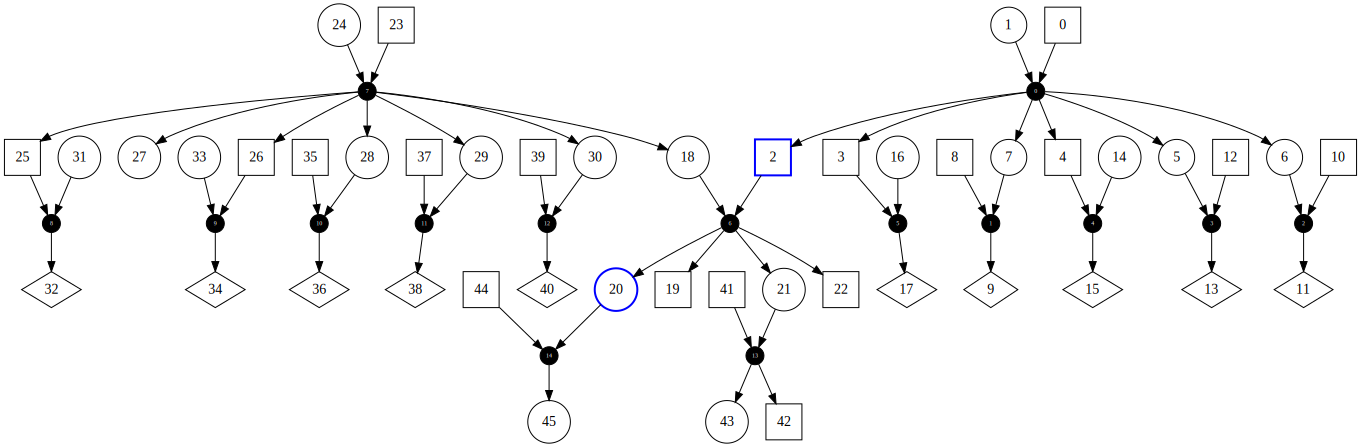

Inheritance guessAD


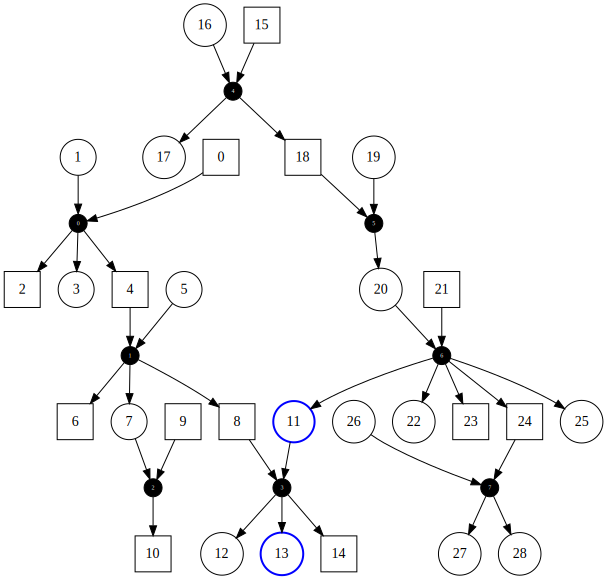

Inheritance guessAD


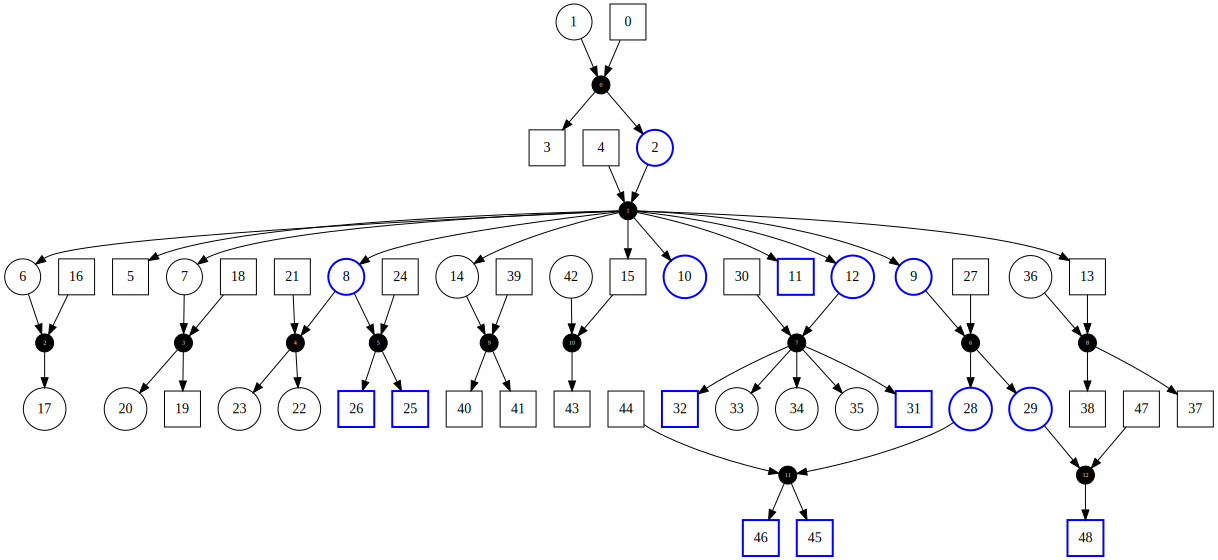

Inheritance guessAD


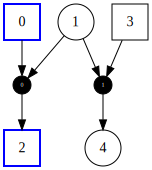

Inheritance guessAD


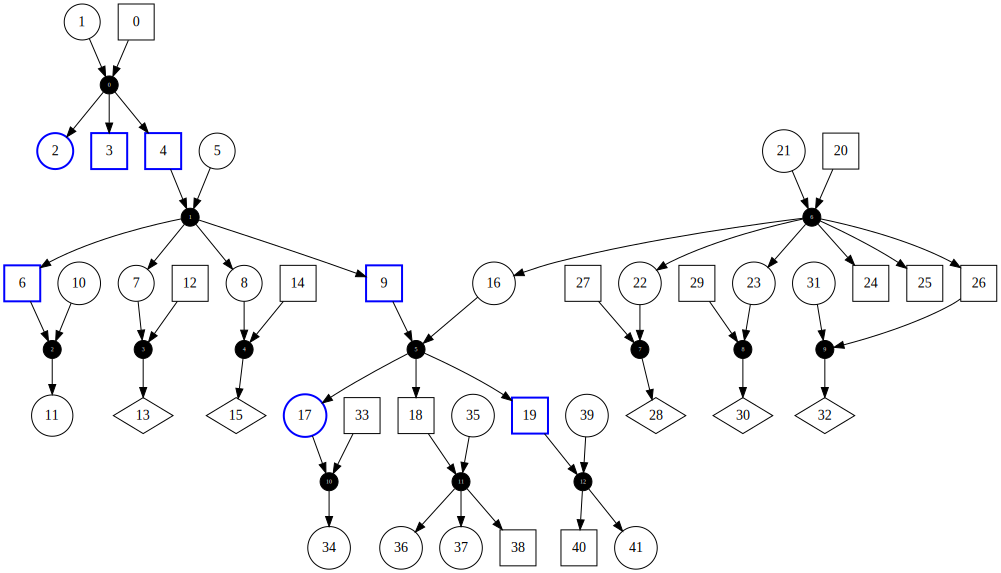

Inheritance guessAD


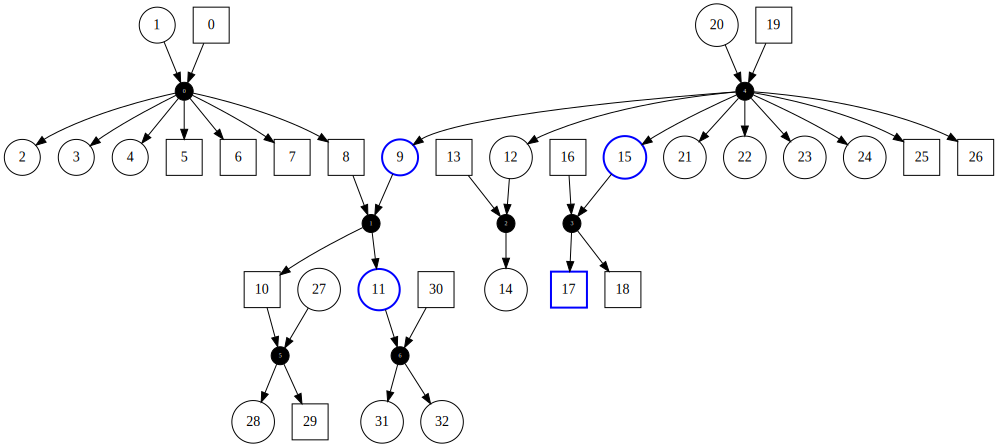

Inheritance guessAD


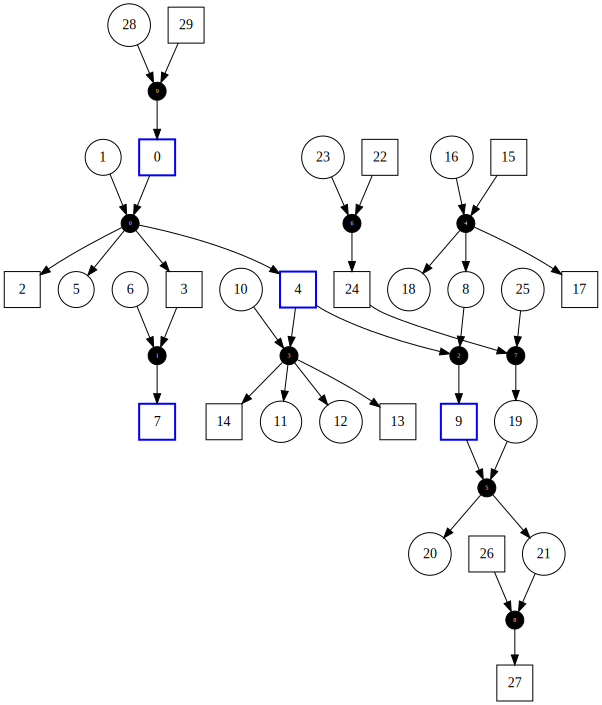

Inheritance guessAD


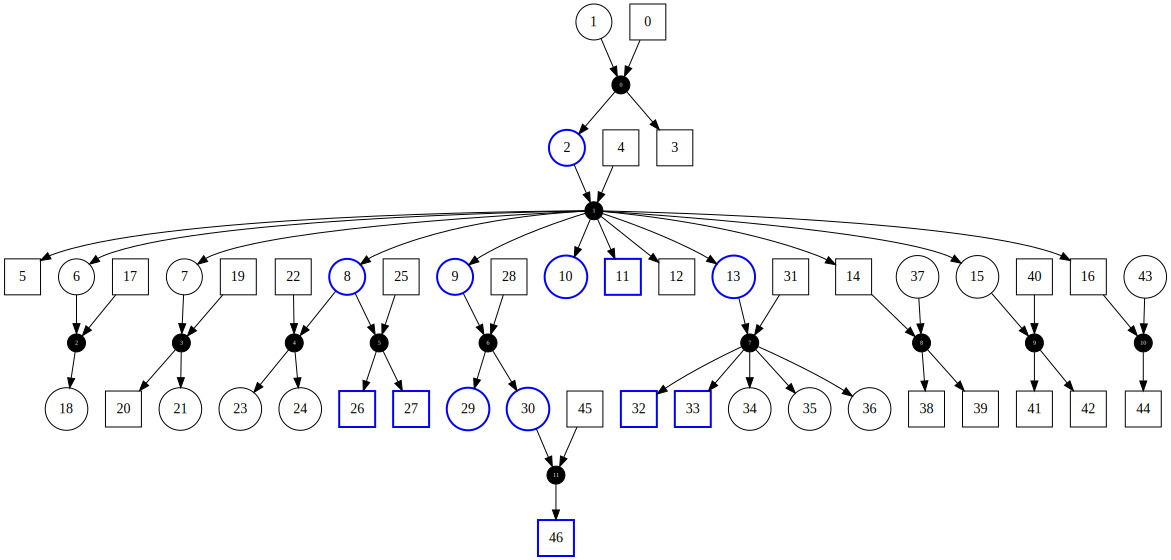

Inheritance guessAD


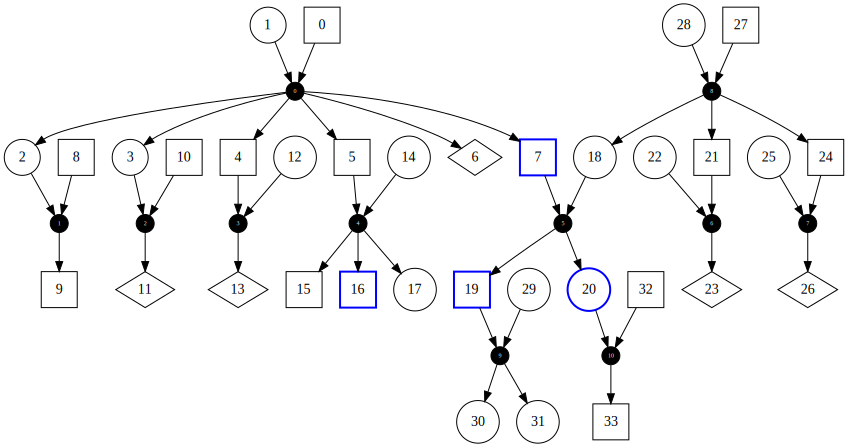

Inheritance guessAD


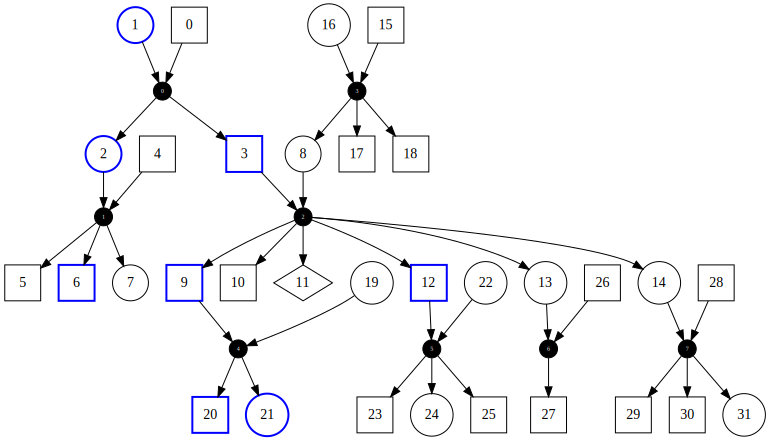

Inheritance guessAD


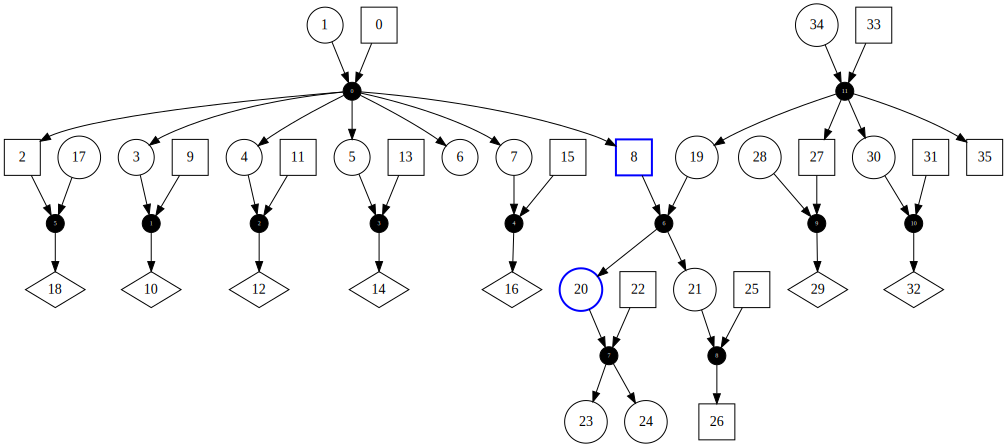

Inheritance guessAD


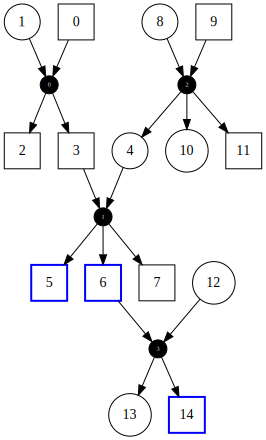

Inheritance guessAD


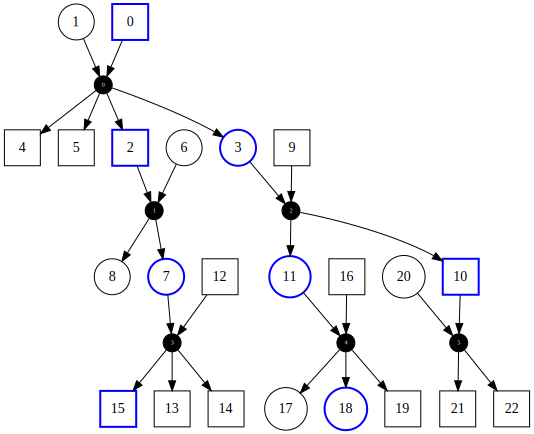

Inheritance guessAD


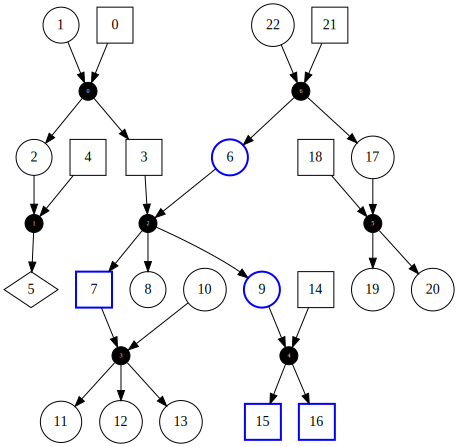

Inheritance guessAD


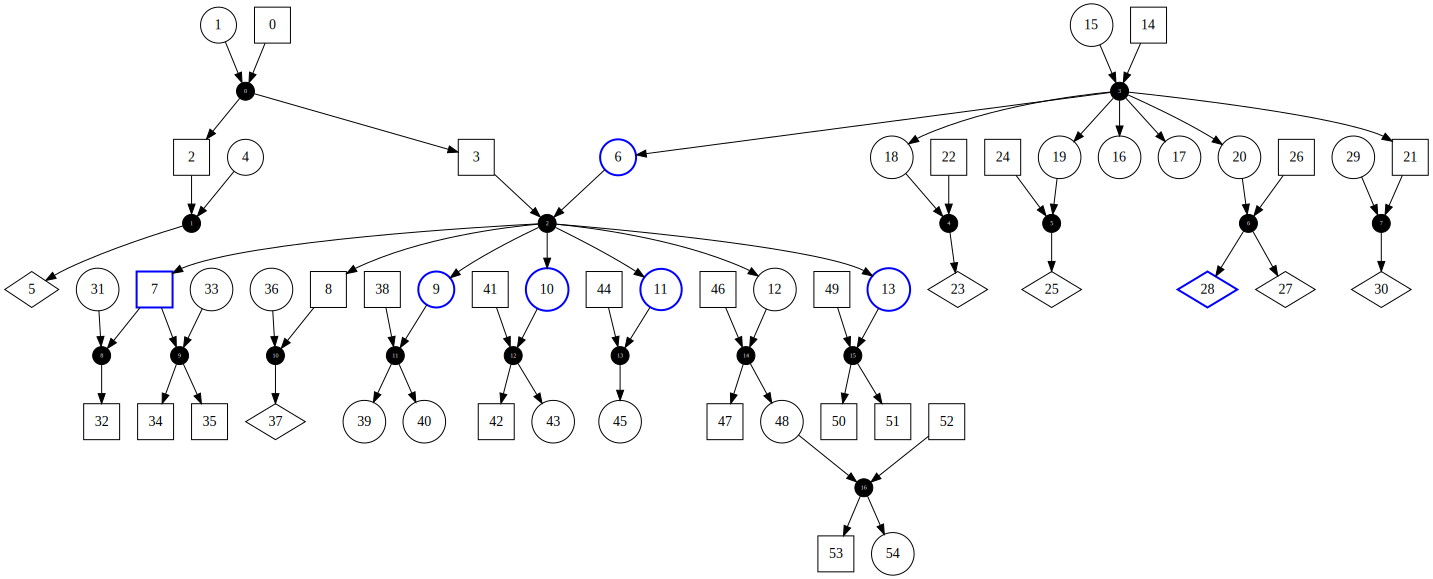

Inheritance guessAD


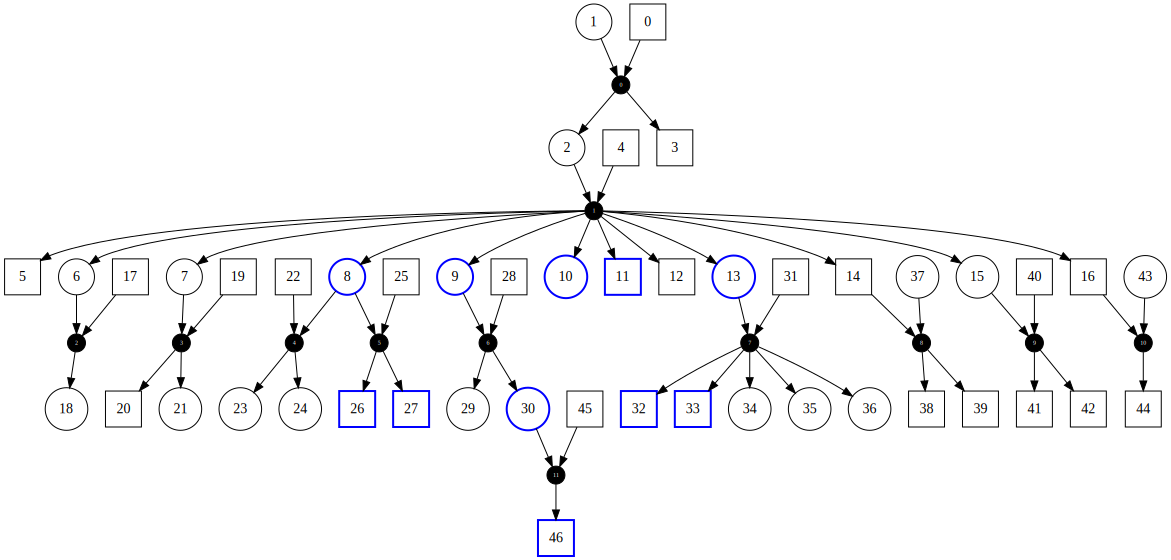

Inheritance guessAD


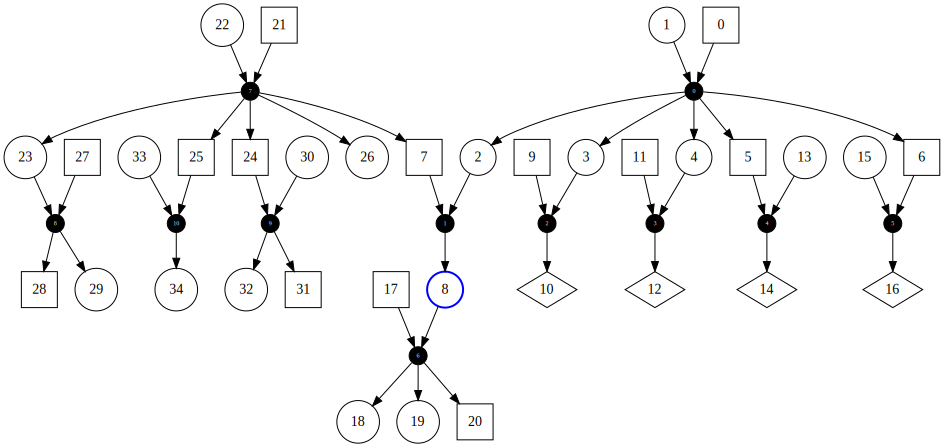

Inheritance guessAR


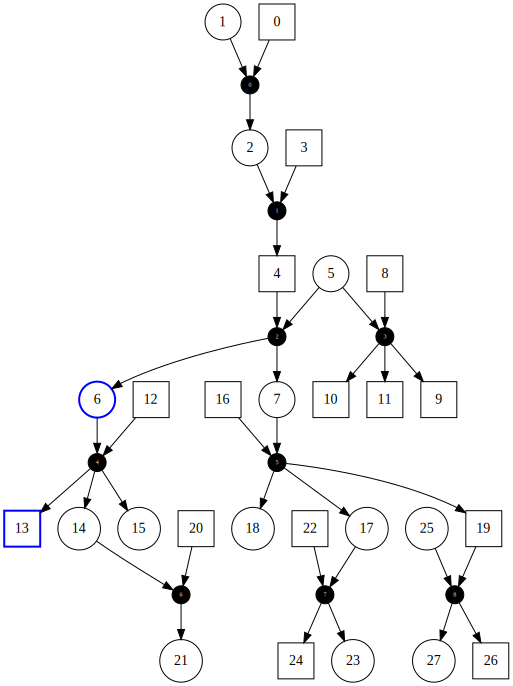

Inheritance guessAD


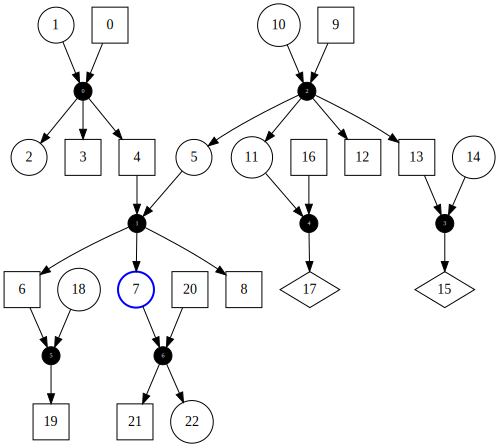

Inheritance guessAR


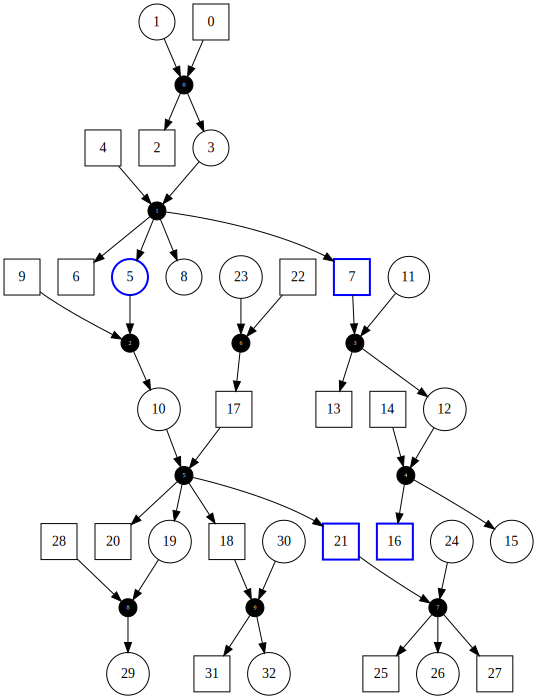

Inheritance guessXL


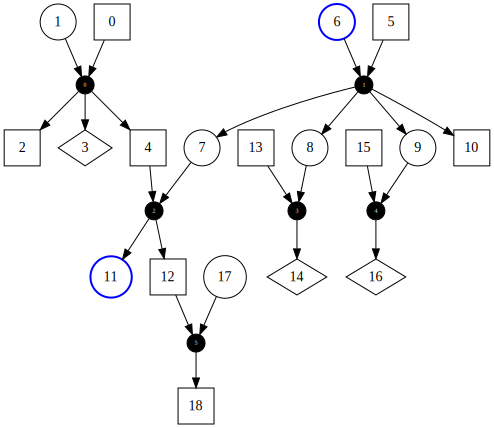

Inheritance guessAR


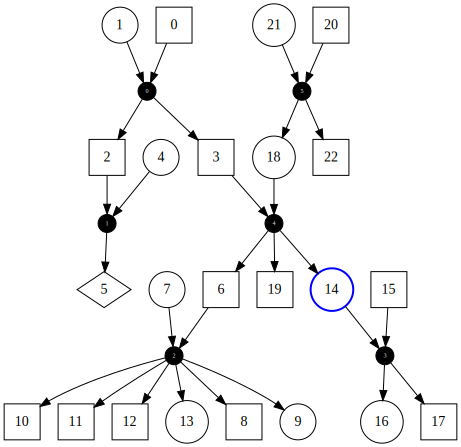

Inheritance guessAR


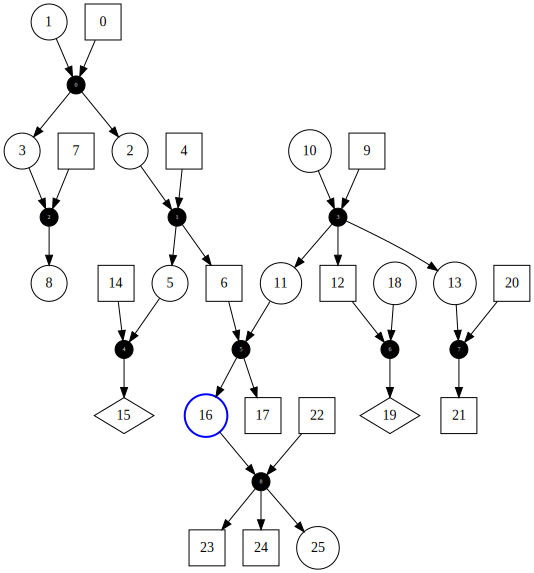

Inheritance guessAR


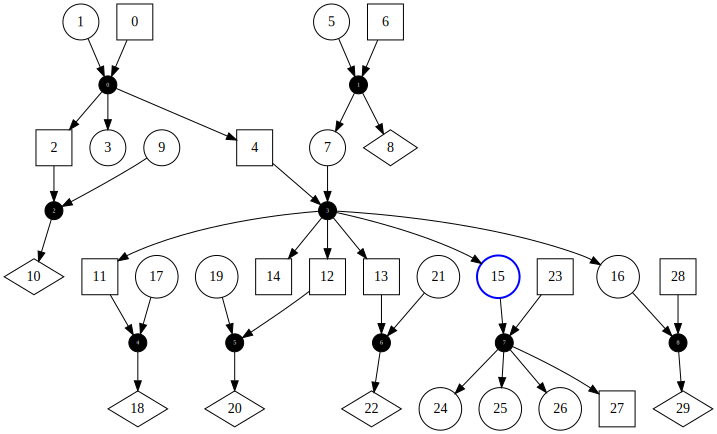

Inheritance guessAR


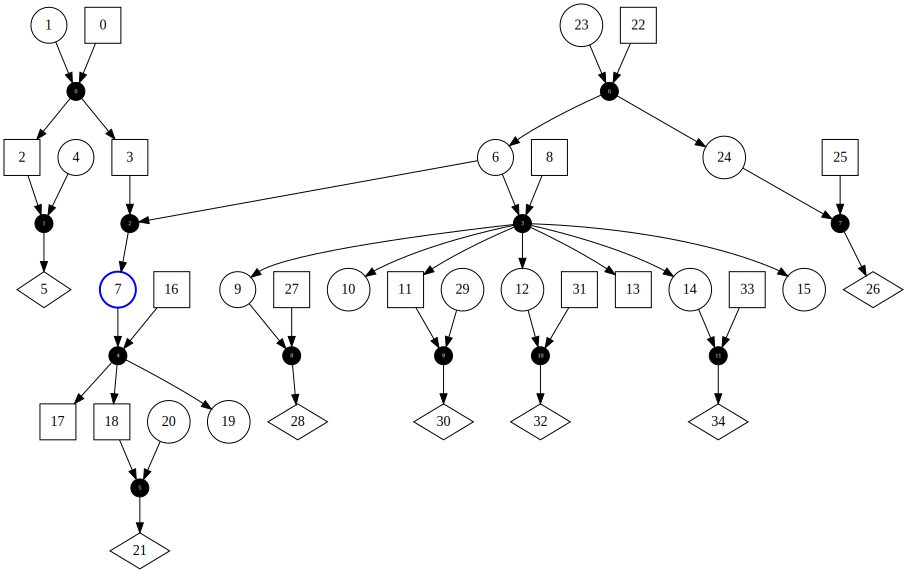

Inheritance guessAR


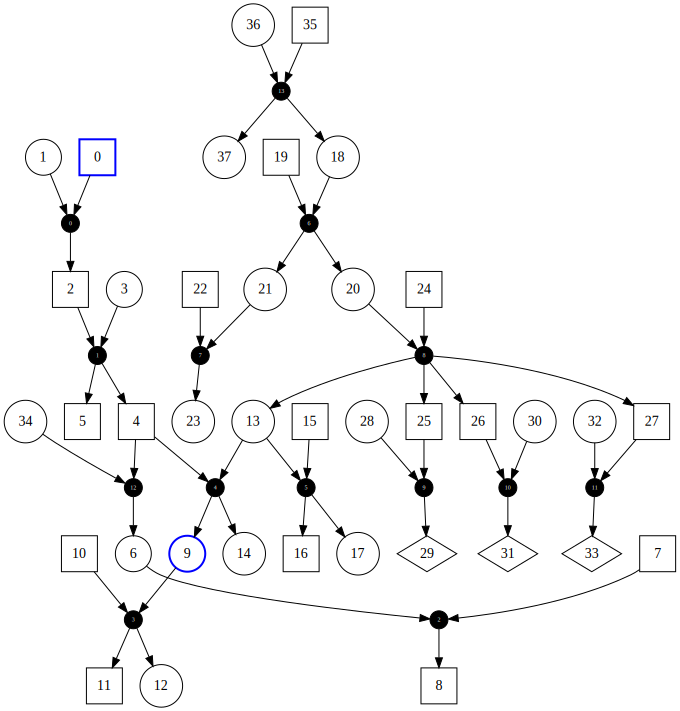

Inheritance guessAR


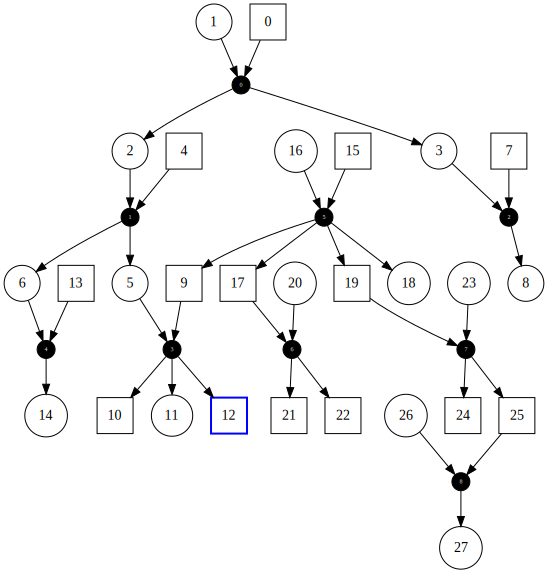

Inheritance guessAR


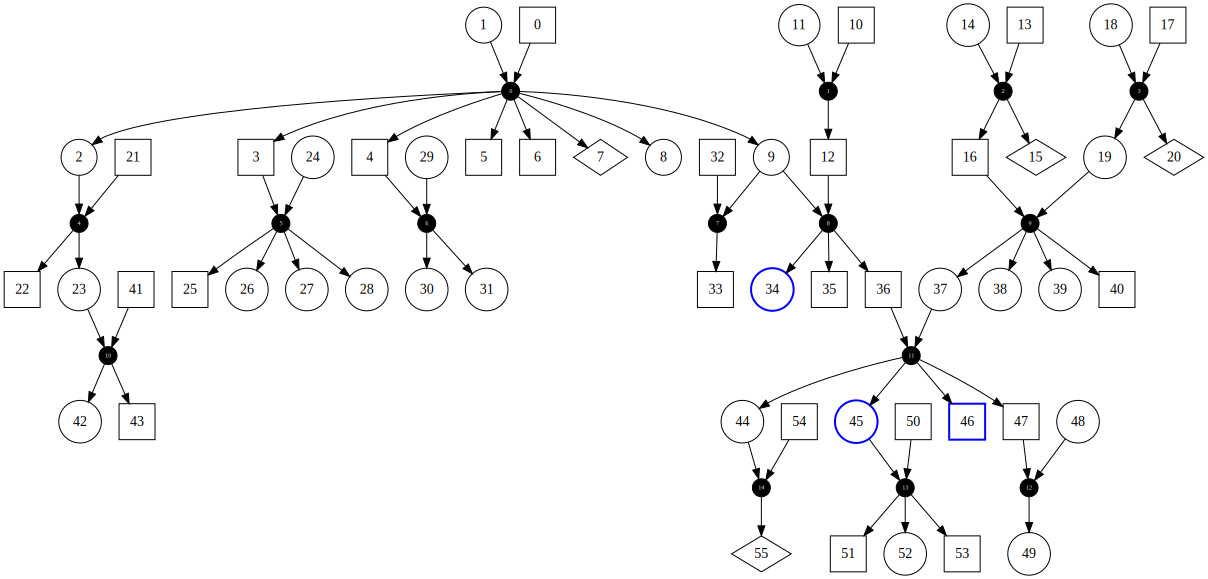

Inheritance guessAD


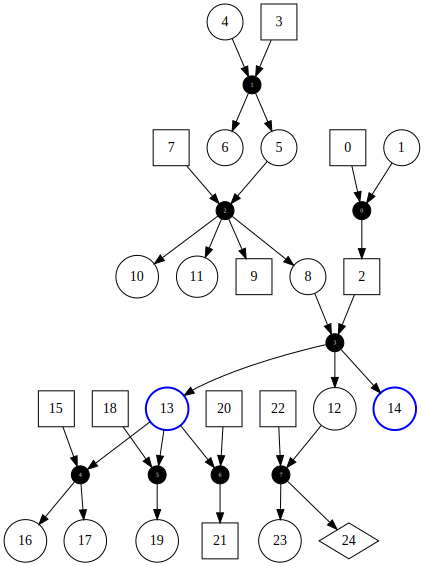

Inheritance guessAR


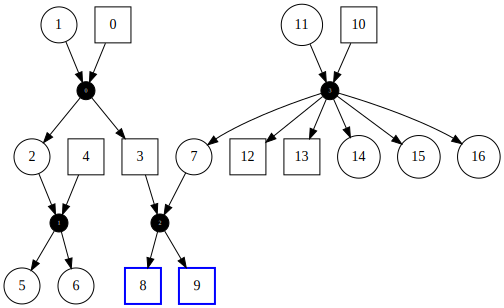

Inheritance guessXL


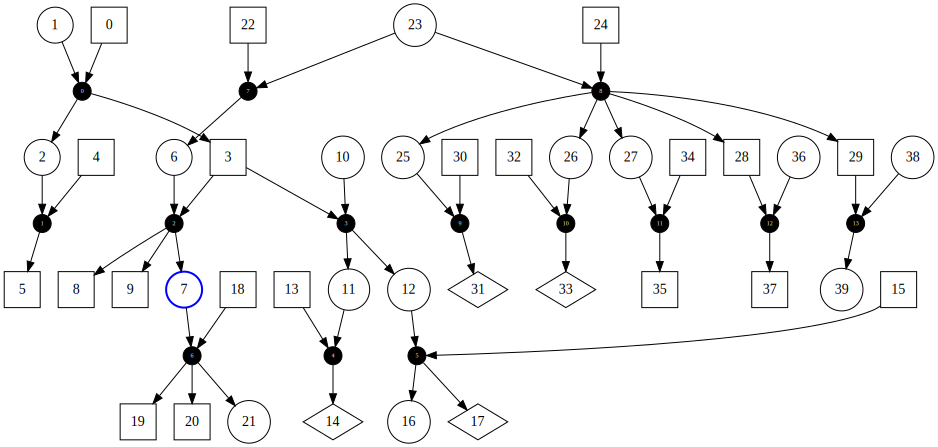

Inheritance guessAR


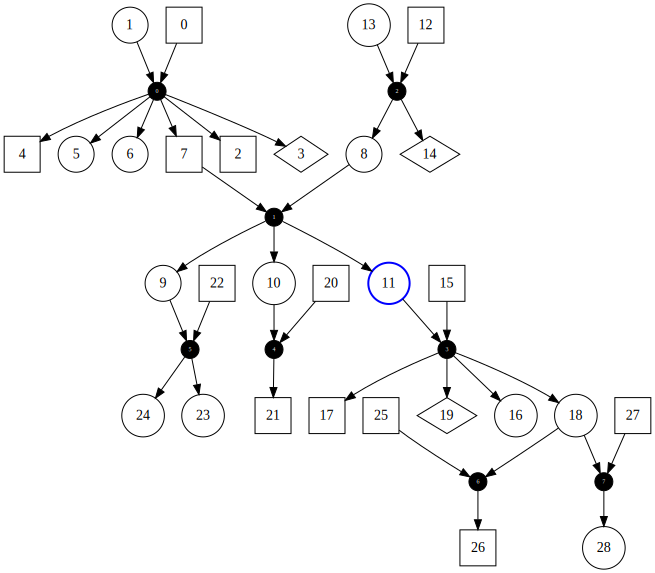

Inheritance guessAR


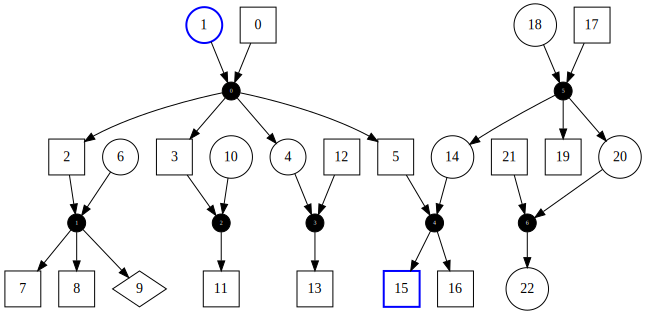

Inheritance guessAD


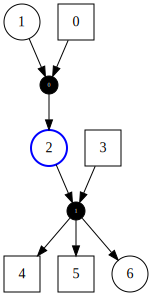

Inheritance guessAR


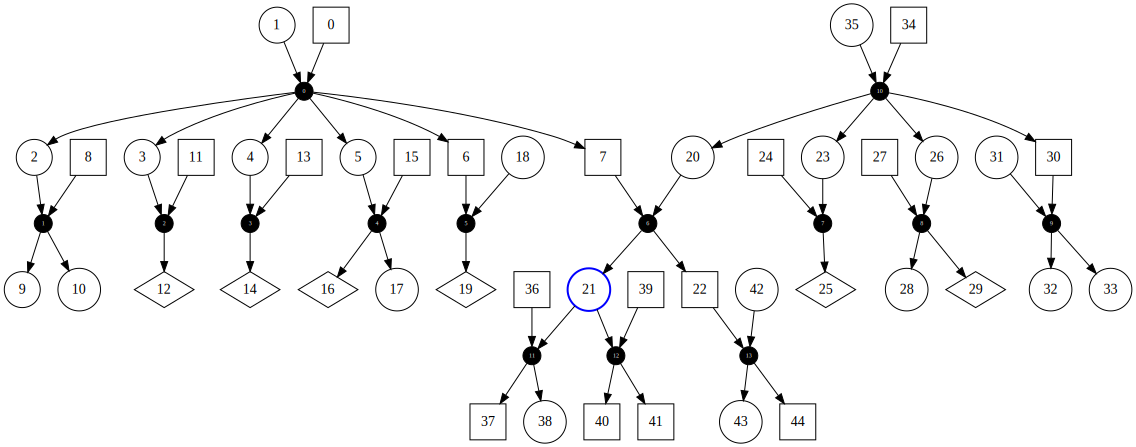

Inheritance guessAR


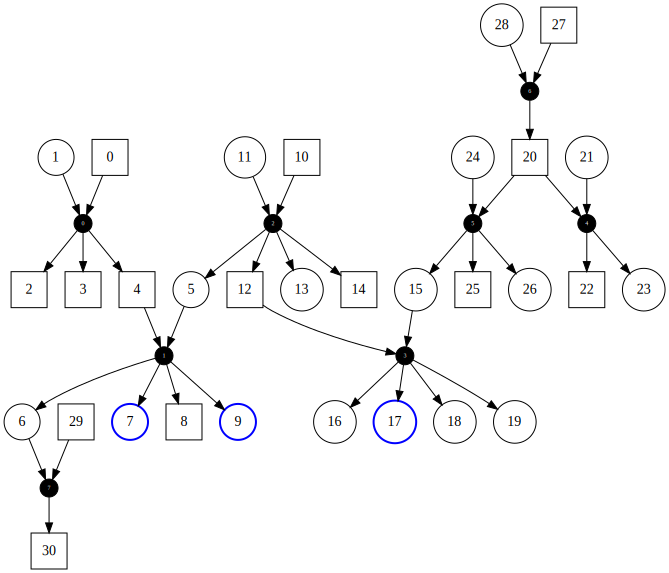

Inheritance guessAR


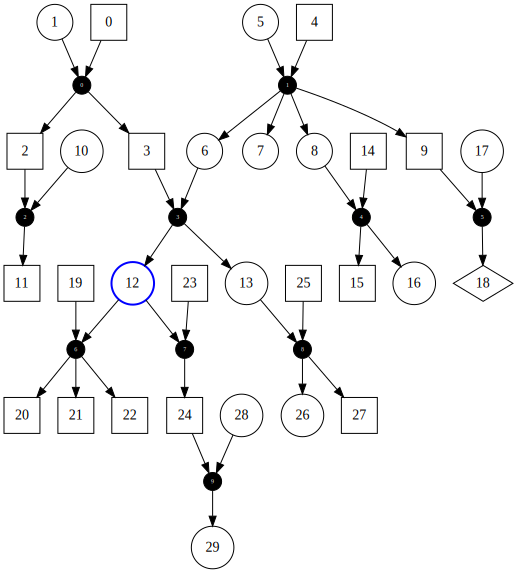

Inheritance guessAR


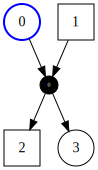

Inheritance guessAR


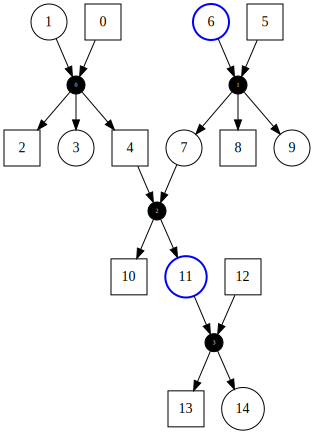

Inheritance guessAD


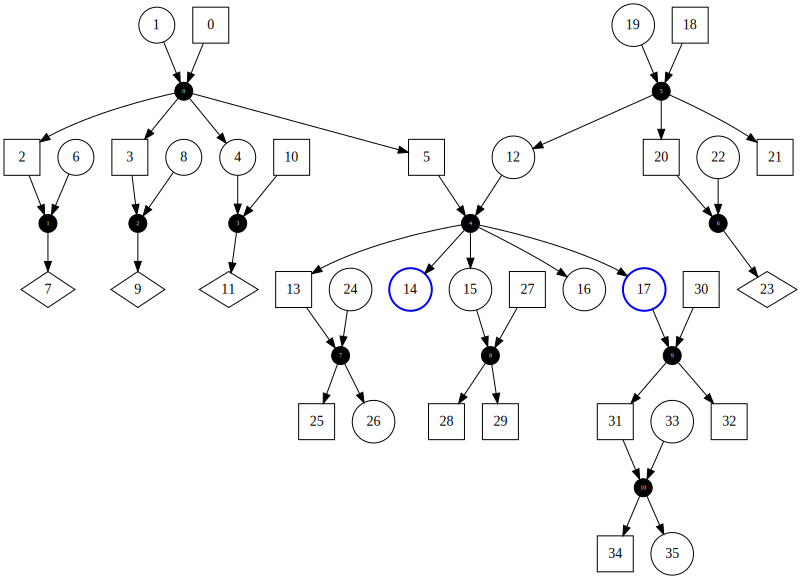

Inheritance guessAR


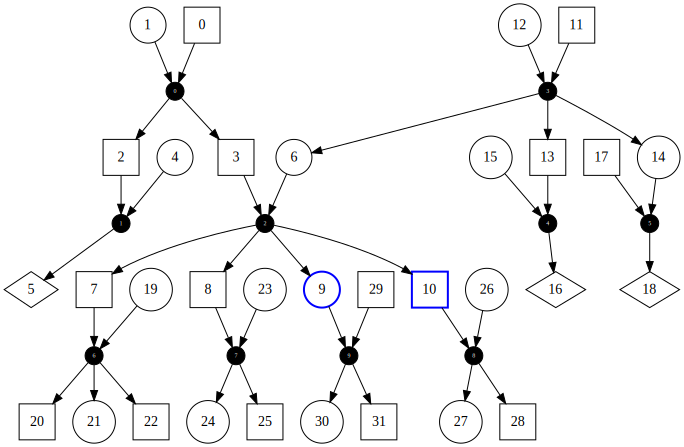

Inheritance guessAR


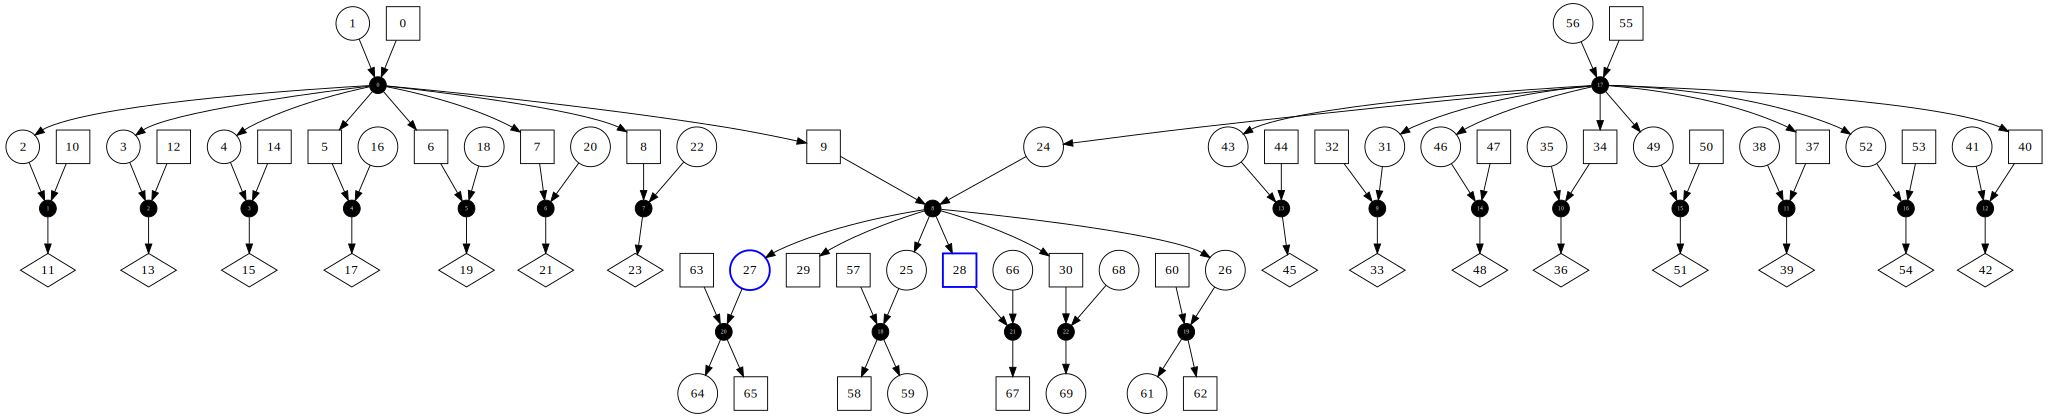

Inheritance guessAR


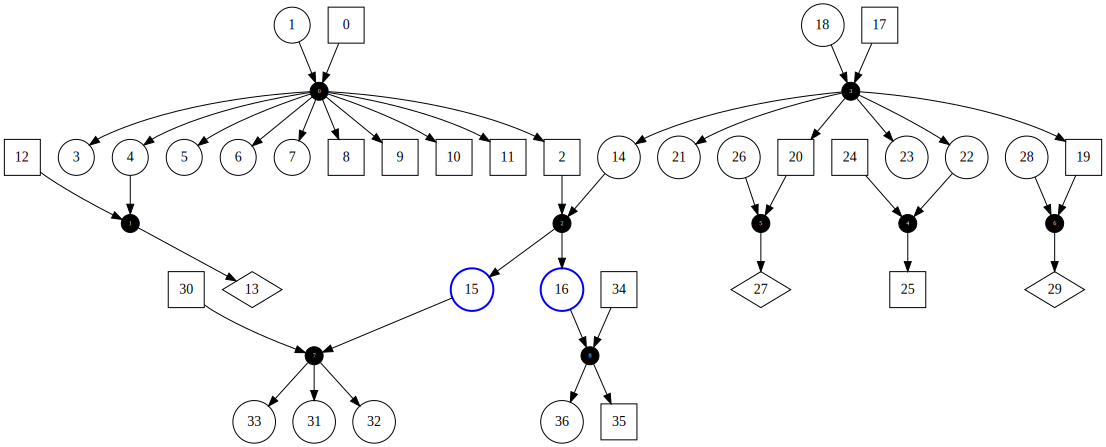

Inheritance guessAR


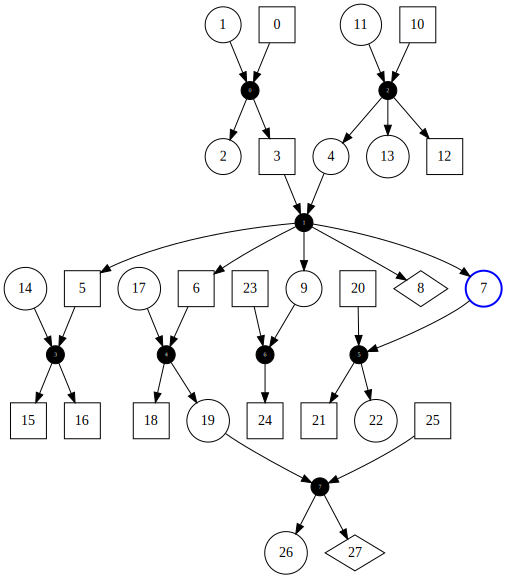

Inheritance guessAR


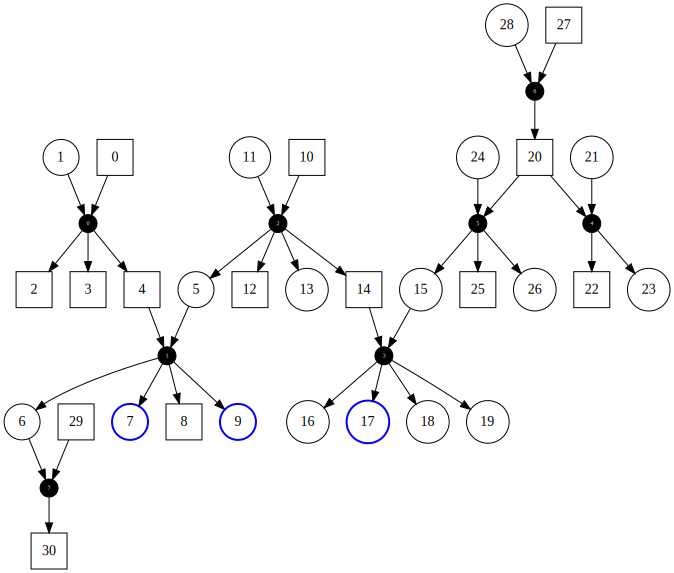

Inheritance guessAR


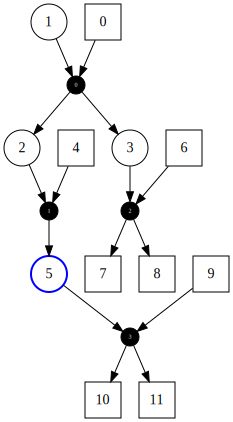

Inheritance guessAR


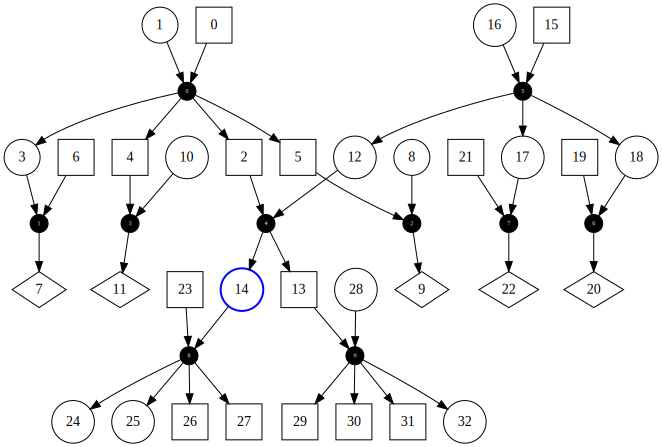

Inheritance guessAR


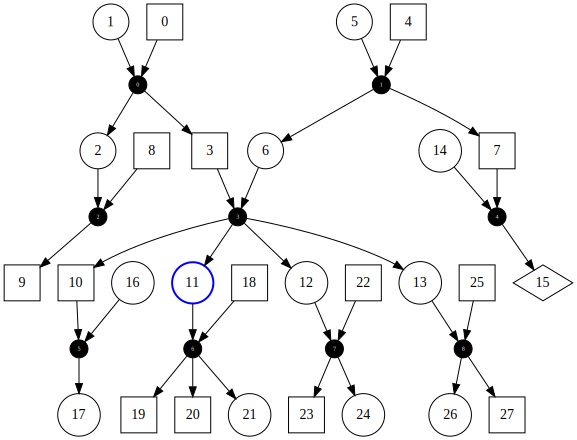

Inheritance guessAR


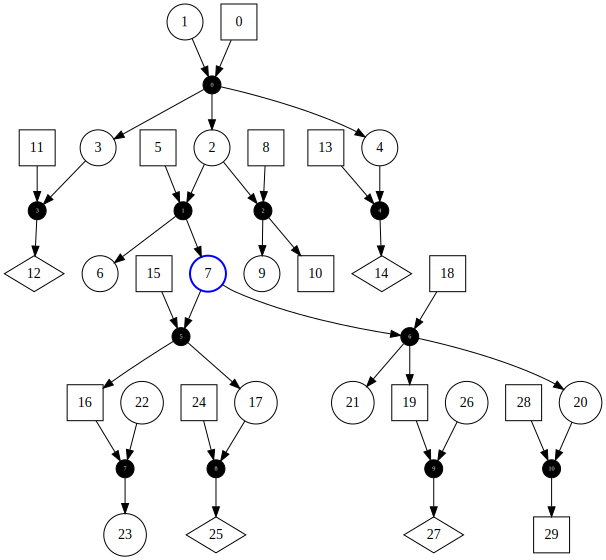

Inheritance guessAR


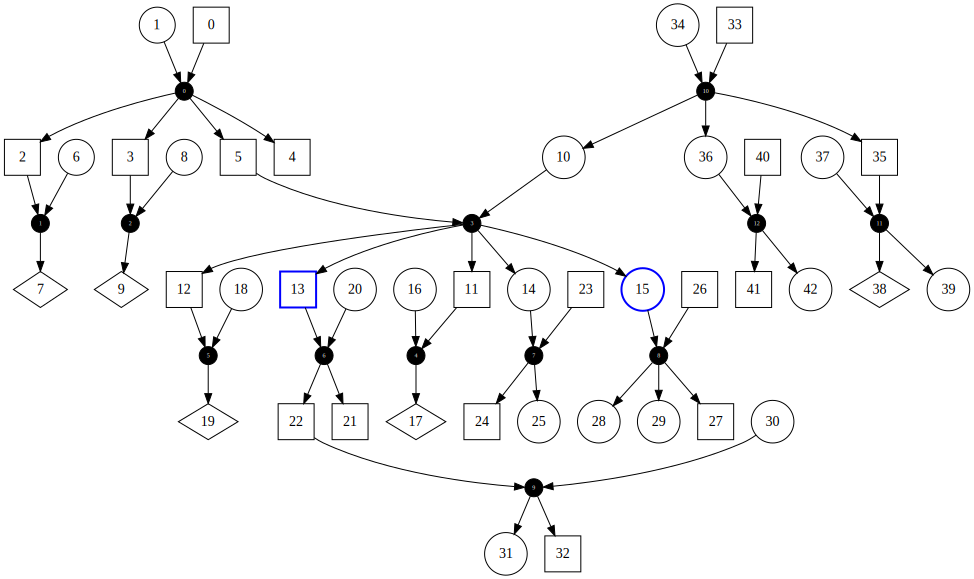

Inheritance guessAR


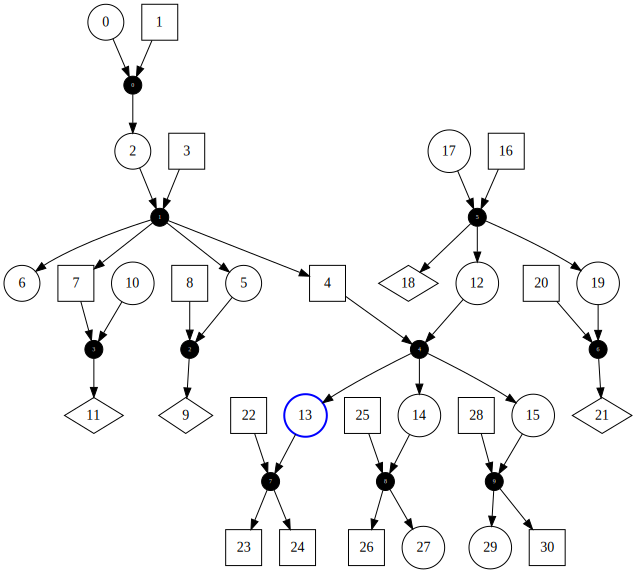

Inheritance guessAR


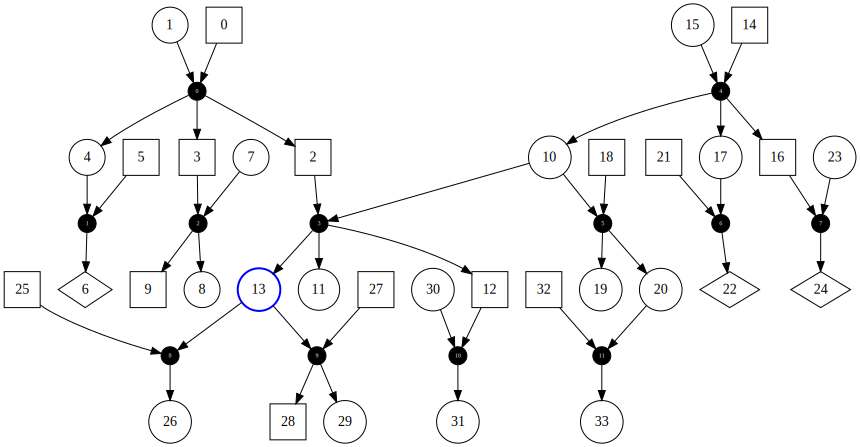

Inheritance guessAR


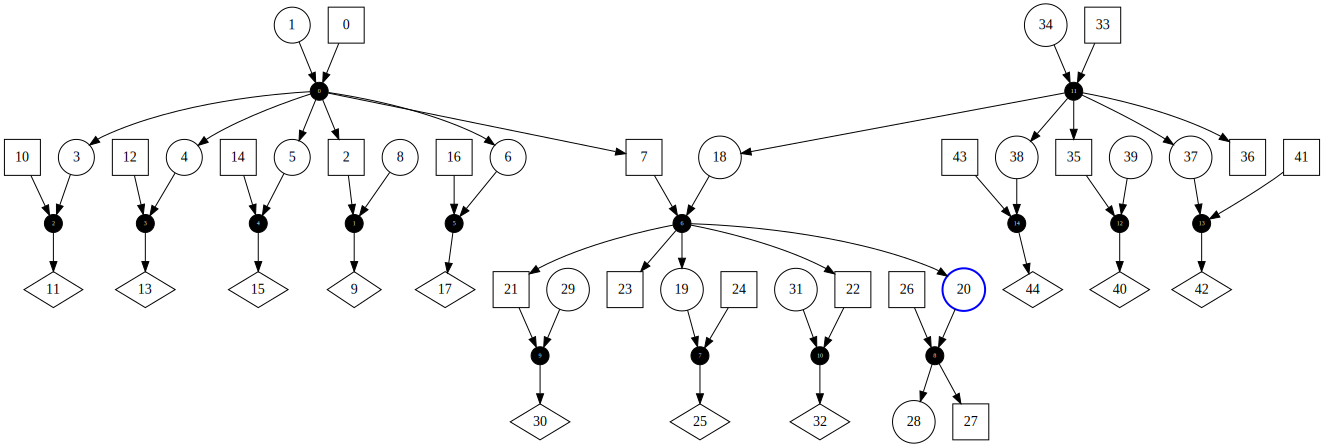

Inheritance guessAR


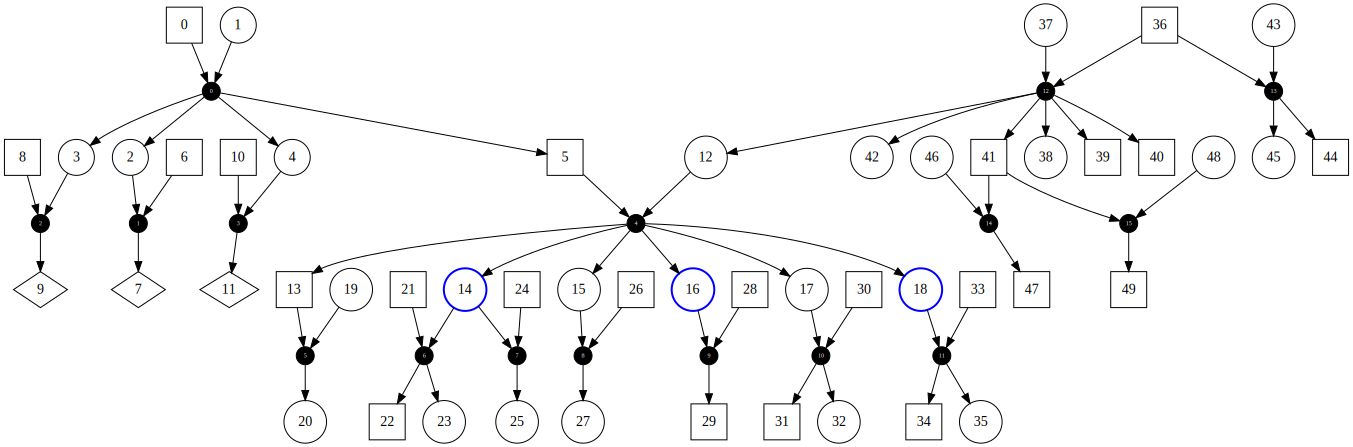

Inheritance guessAR


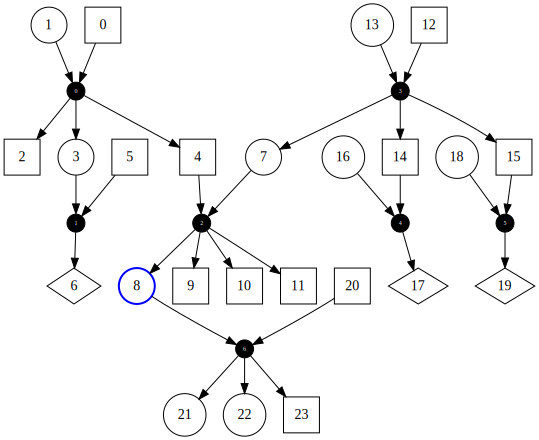

Inheritance guessAR


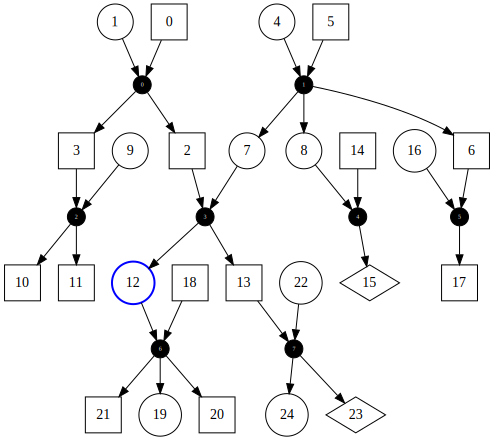

Inheritance guessAR


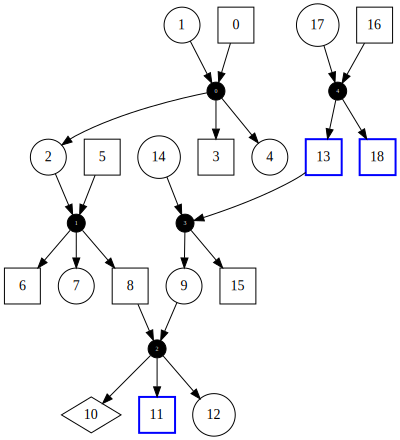

Inheritance guessXL


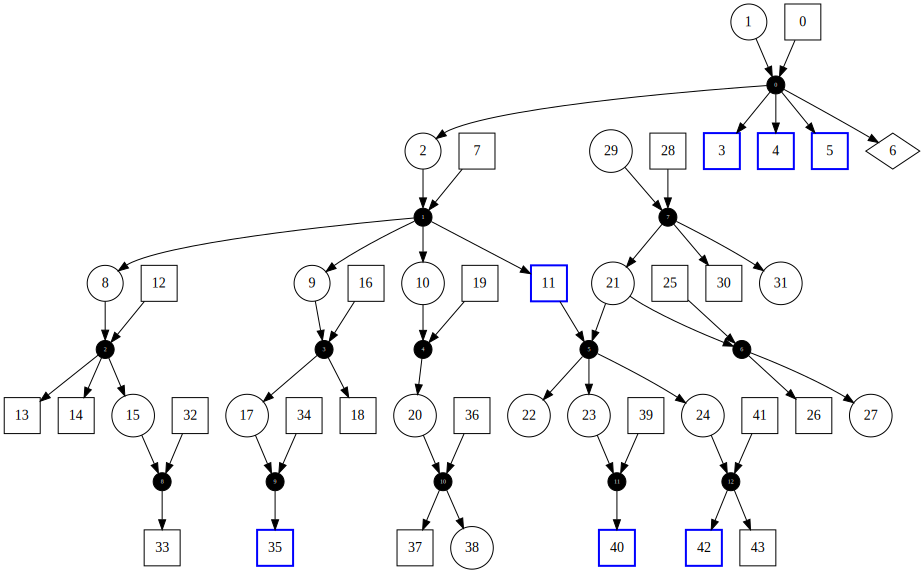

Inheritance guessXL


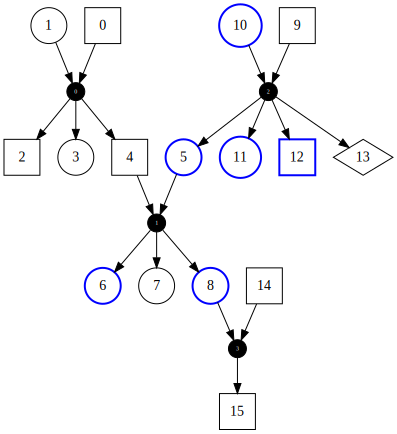

Inheritance guessAD


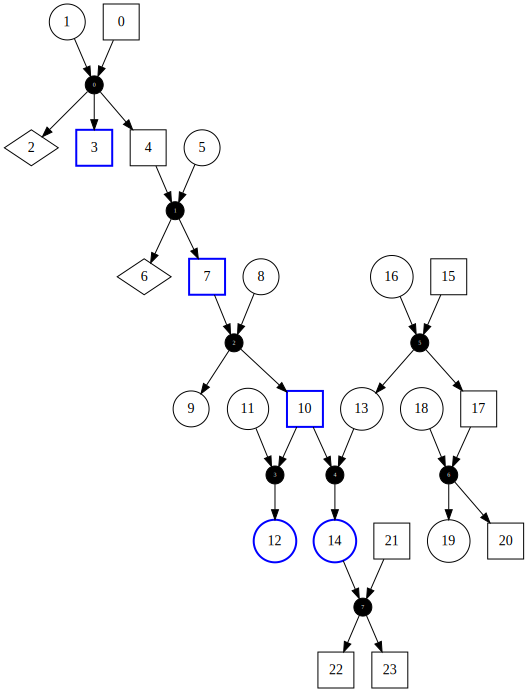

Inheritance guessAD


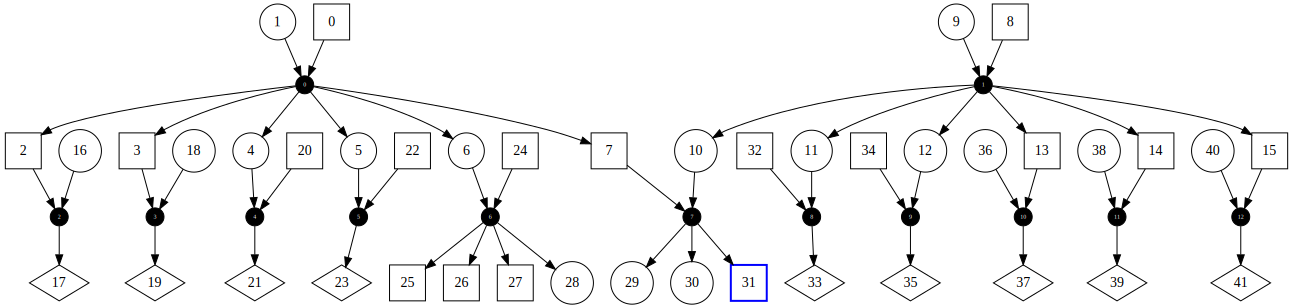

Inheritance guessAR


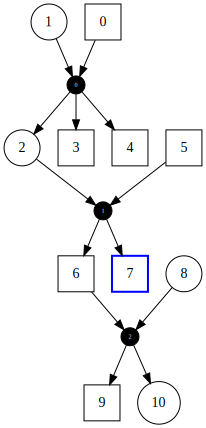

Inheritance guessAR


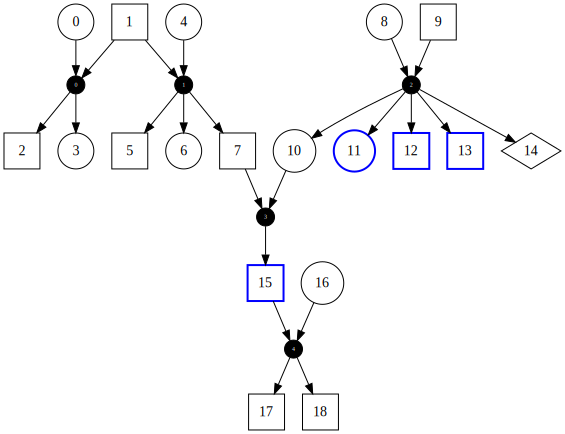

Inheritance guessXL


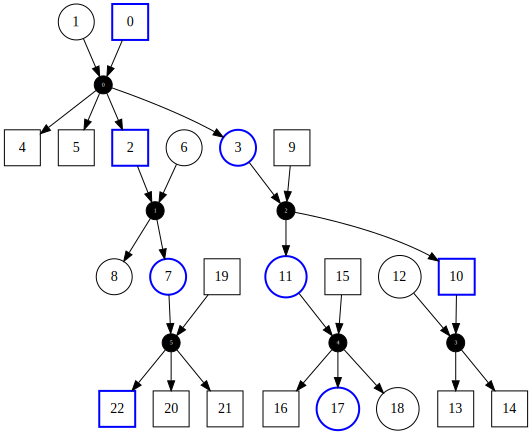

Inheritance guessAD


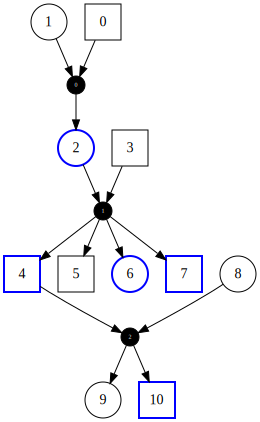

Inheritance guessAD


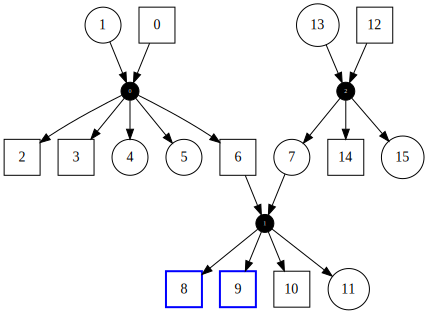

Inheritance guessXL


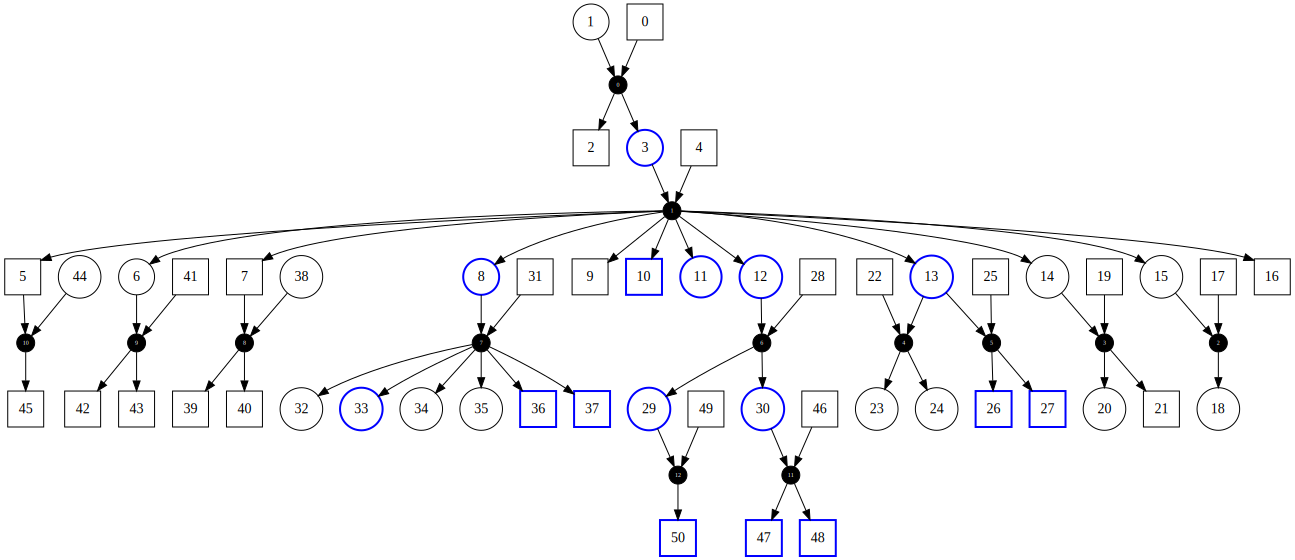

Inheritance guessAD


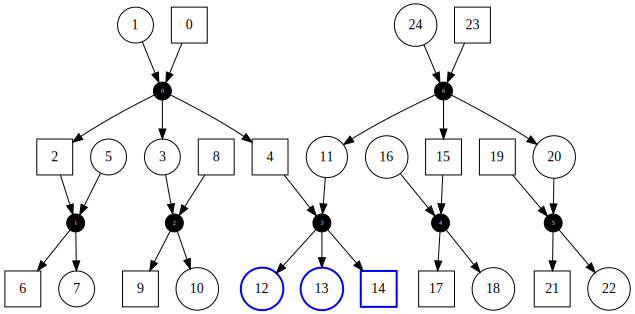

Inheritance guessAR


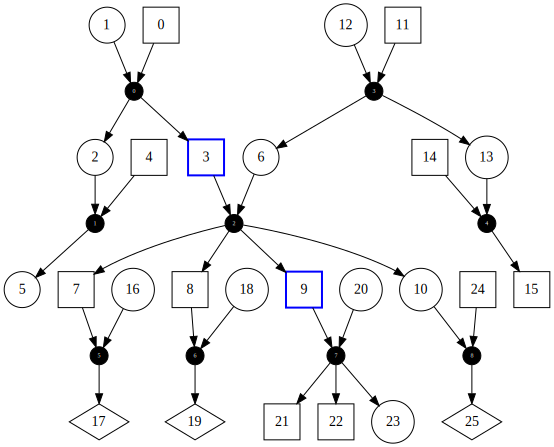

Inheritance guessAD


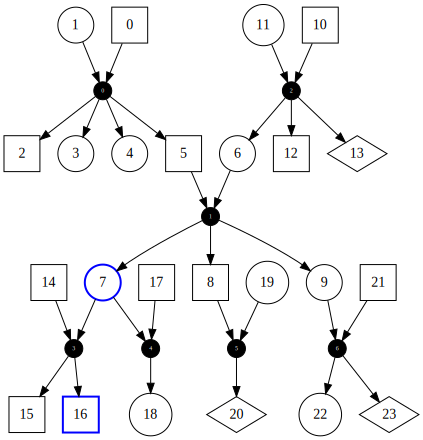

Inheritance guessAD


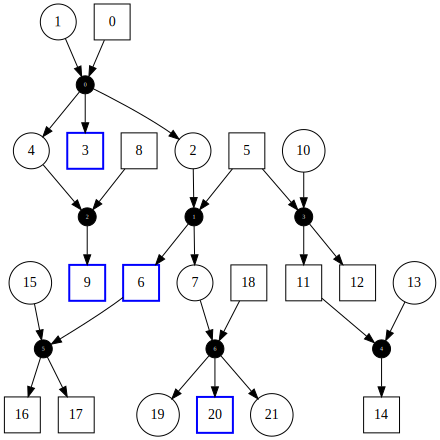

Inheritance guessXL


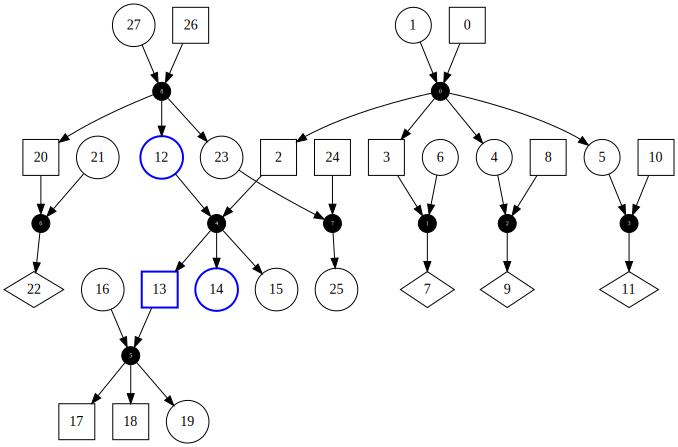

Inheritance guessAD


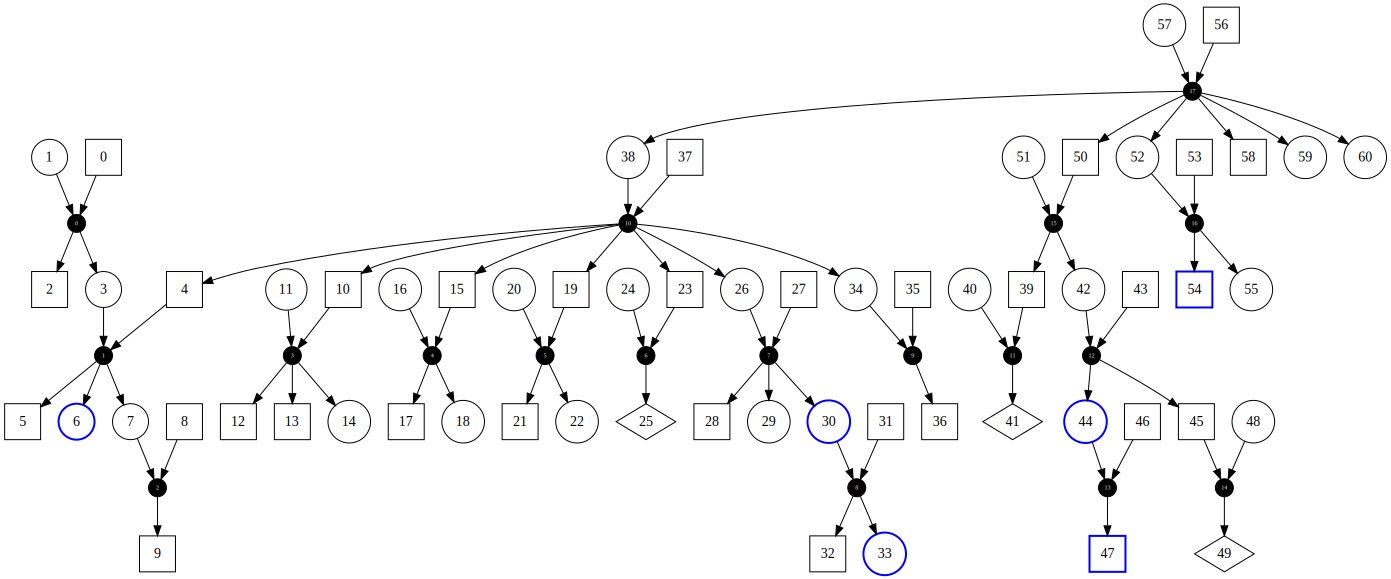

Inheritance guessAR


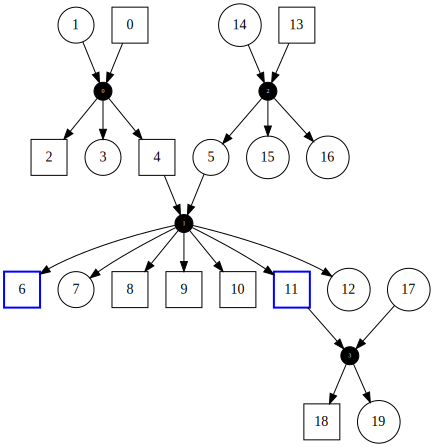

Inheritance guessXL


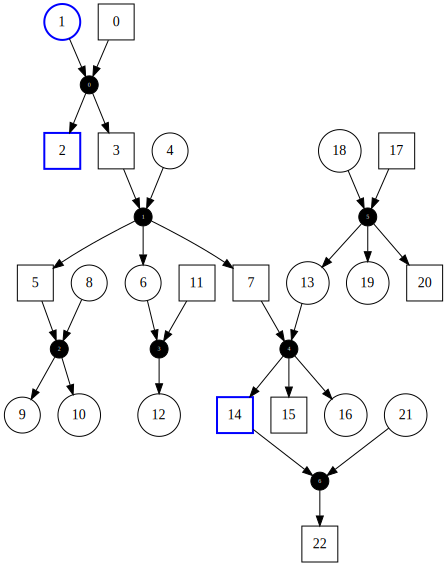

Inheritance guessXL


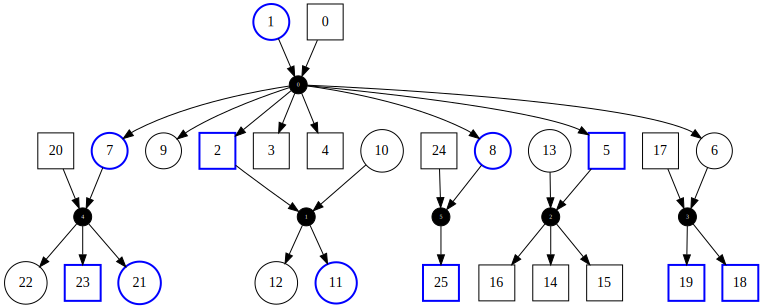

Inheritance guessAD


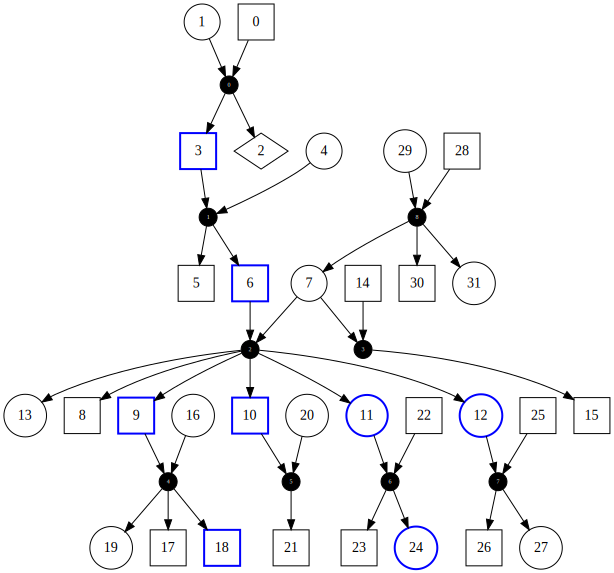

Inheritance guessAD


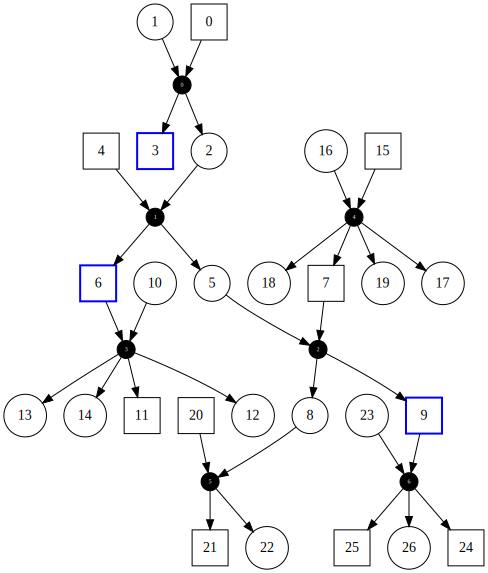

Inheritance guessXL


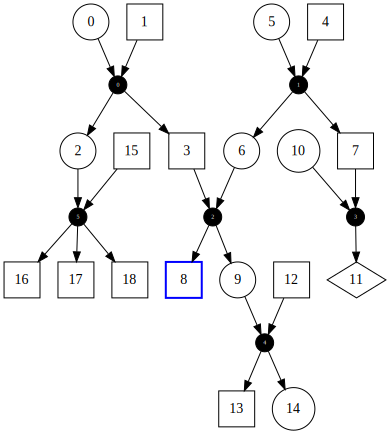

Inheritance guessAR


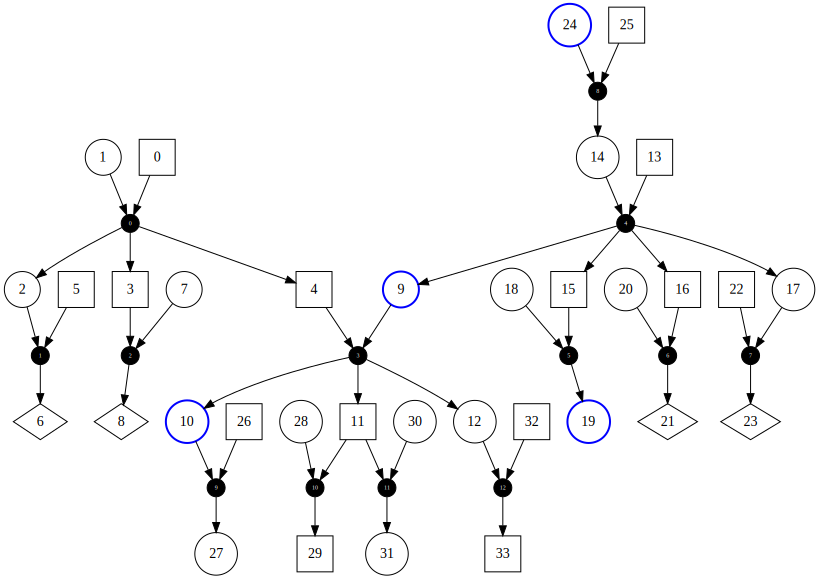

Inheritance guessAD


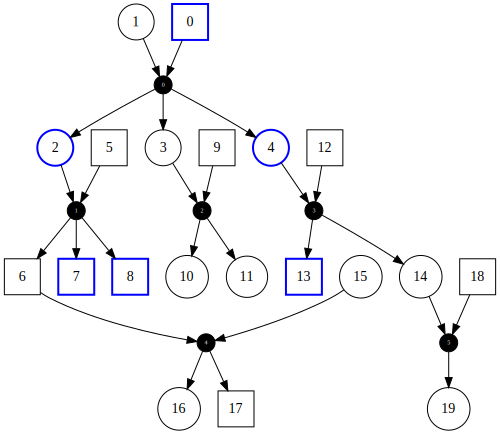

Inheritance guessXL


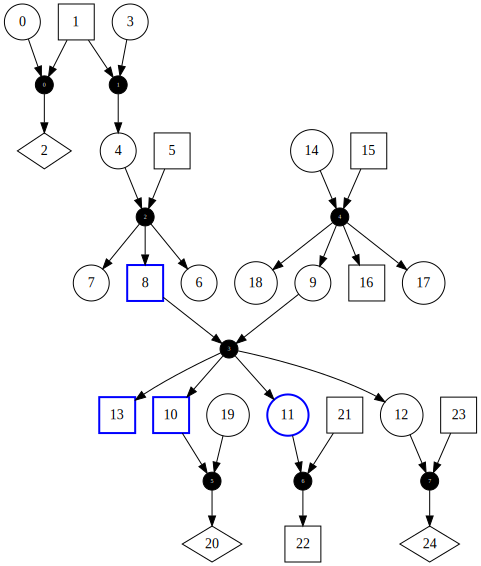

Inheritance guessAD


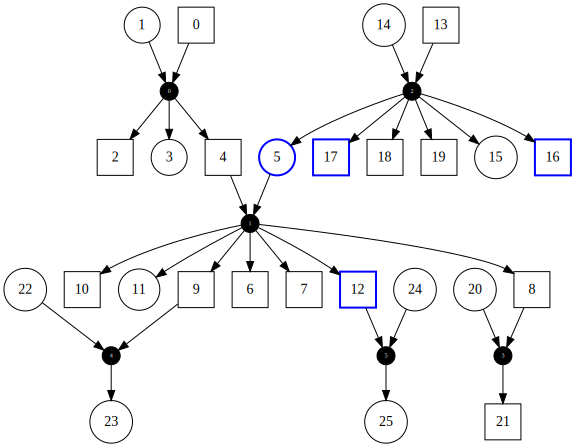

Inheritance guessXL


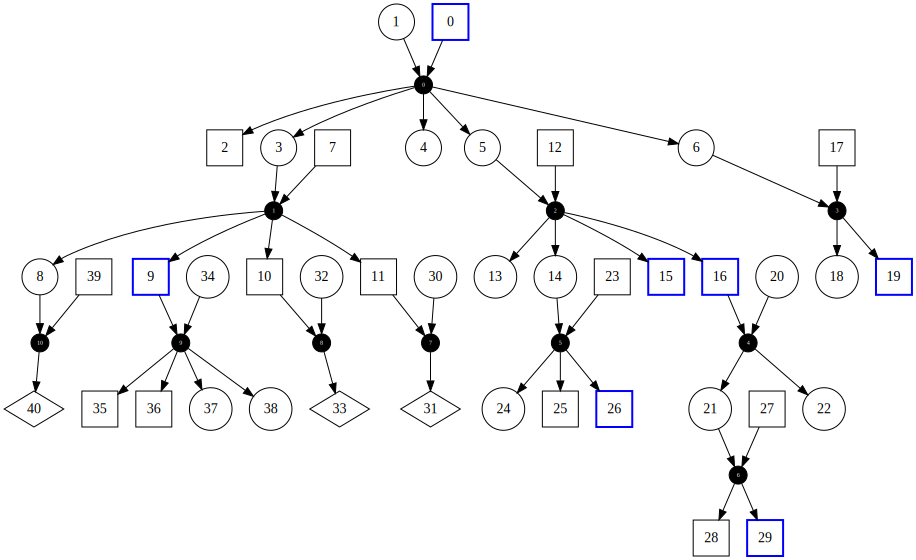

Inheritance guessXL


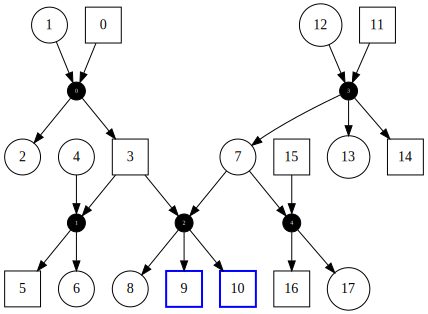

Inheritance guessAR


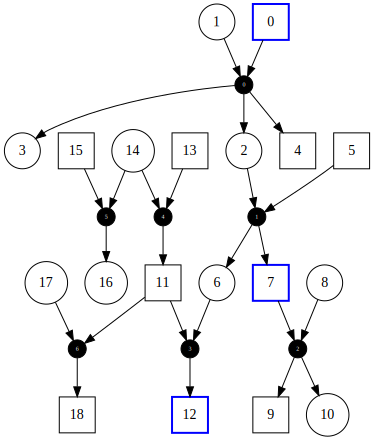

Inheritance guessXL


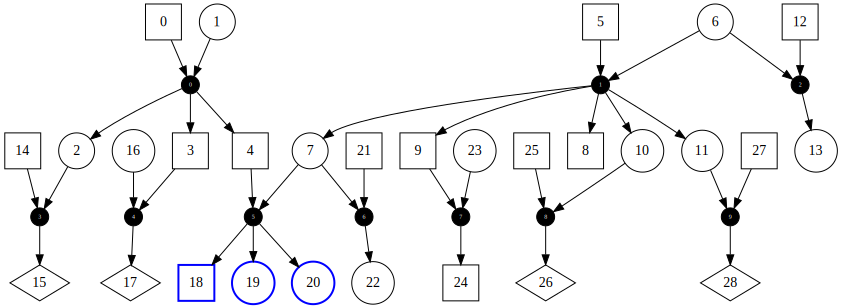

Inheritance guessAR


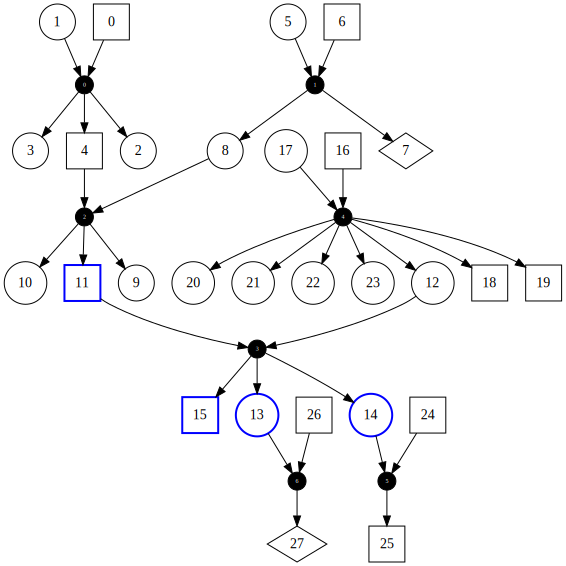

Inheritance guessAD


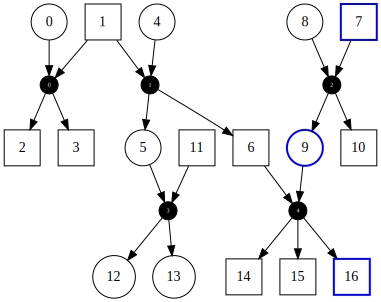

Inheritance guessXL


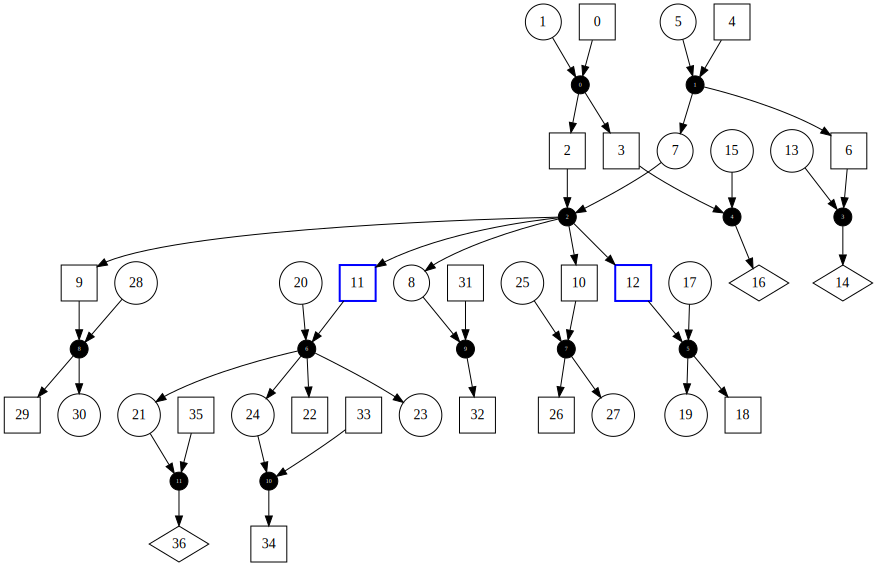

Inheritance guessAR


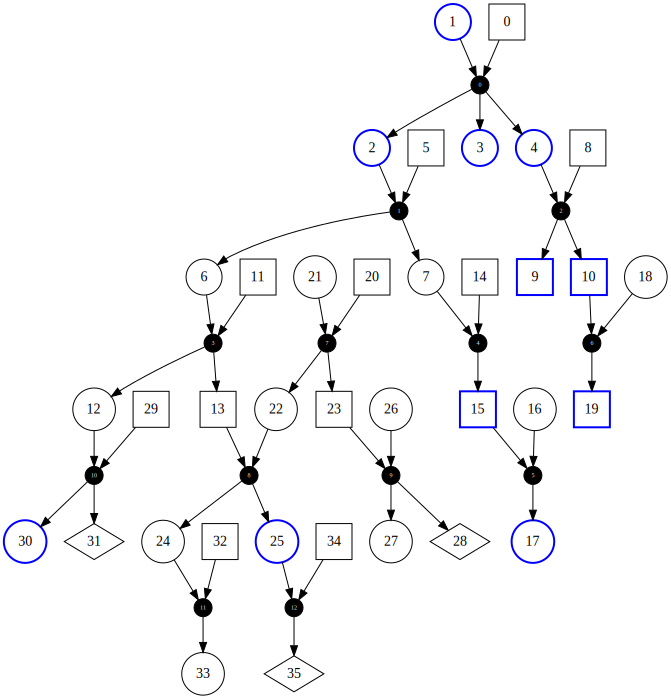

Inheritance guessAD


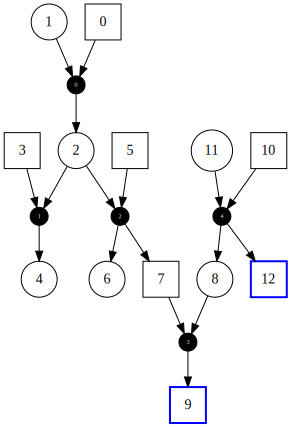

Inheritance guessXL


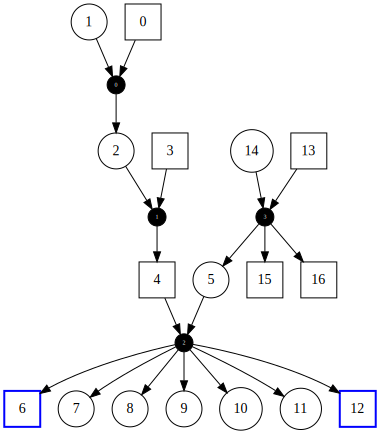

Inheritance guessXL


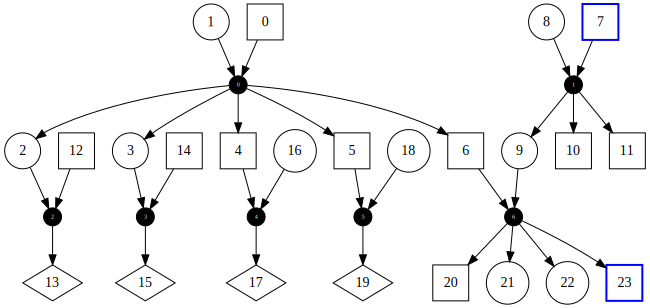

Inheritance guessXL


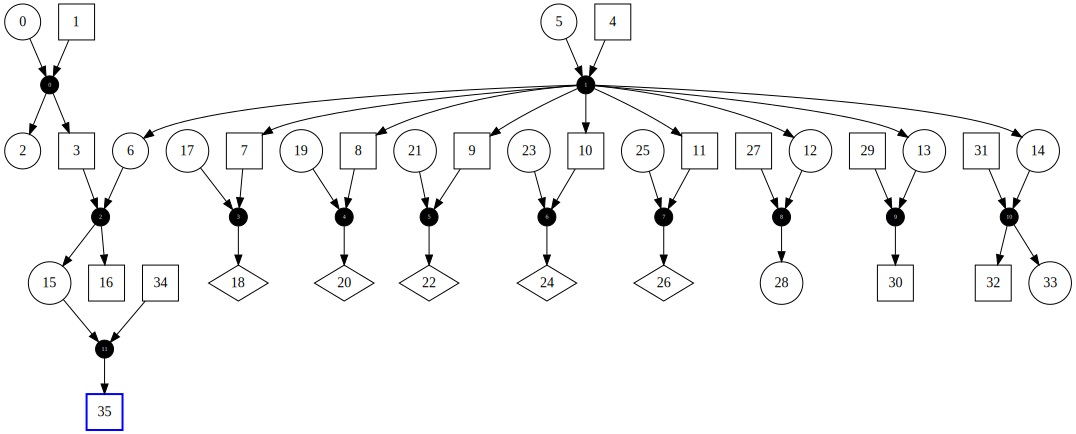

Inheritance guessAR


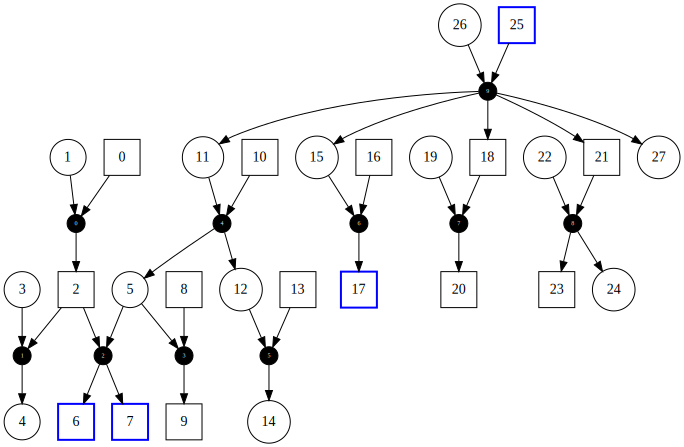

Inheritance guessXL


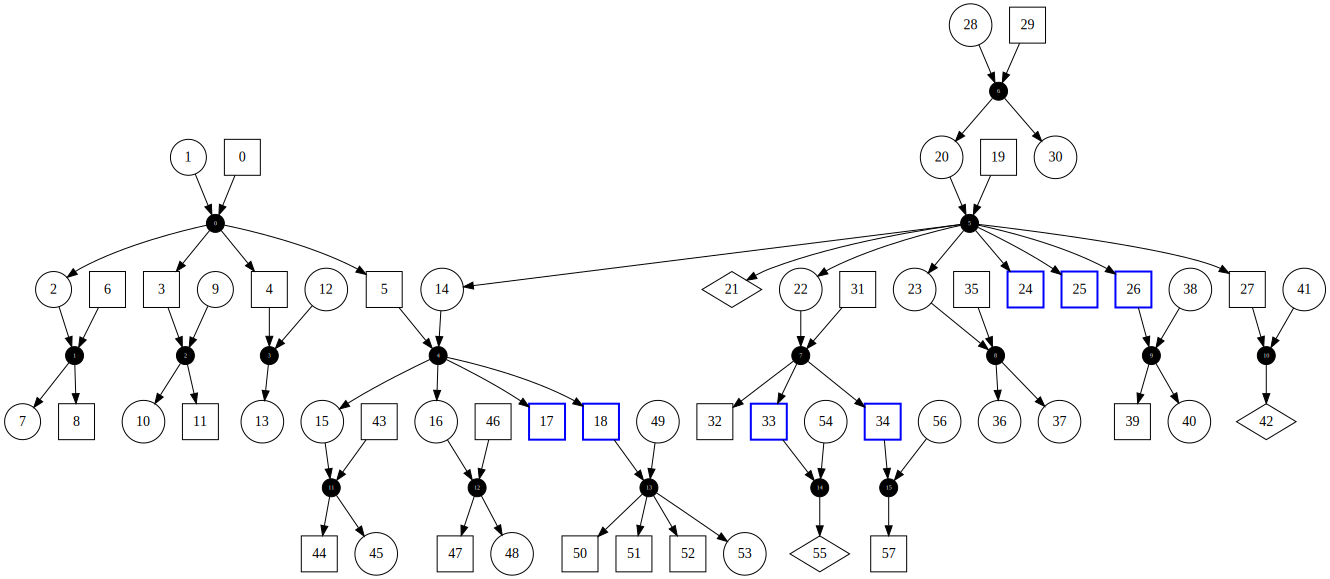

Inheritance guessXL


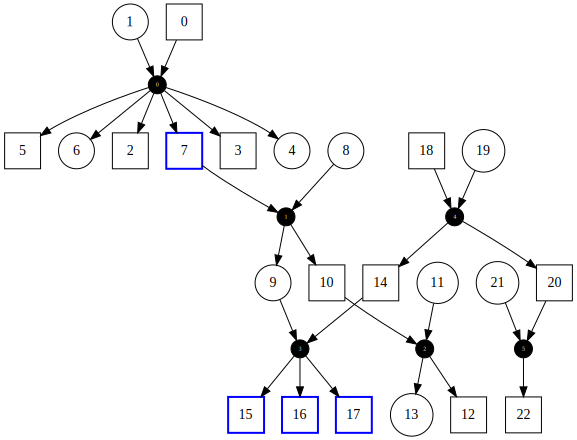

Inheritance guessXL


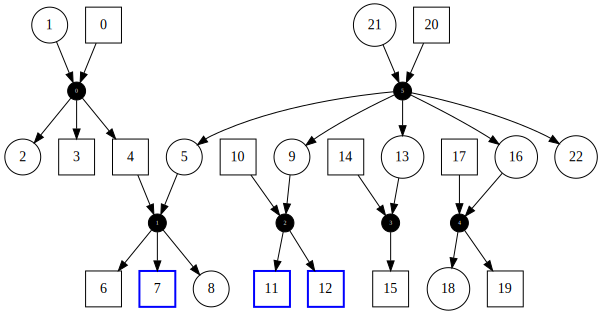

Inheritance guessXL


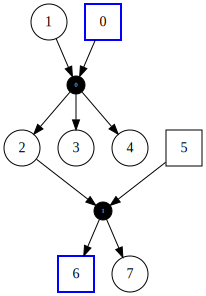

Inheritance guessXL


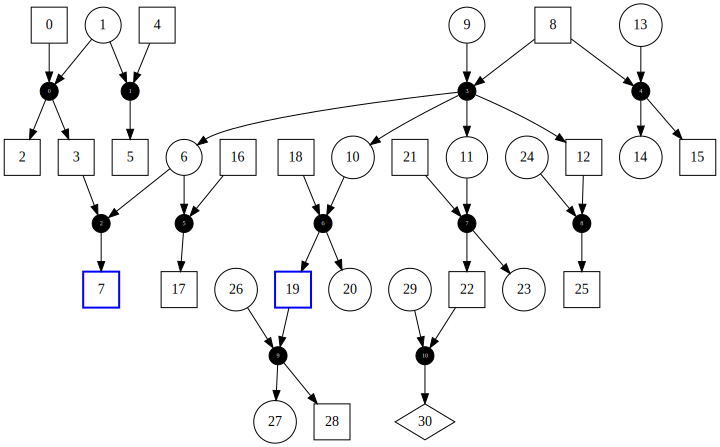

Inheritance guessXL


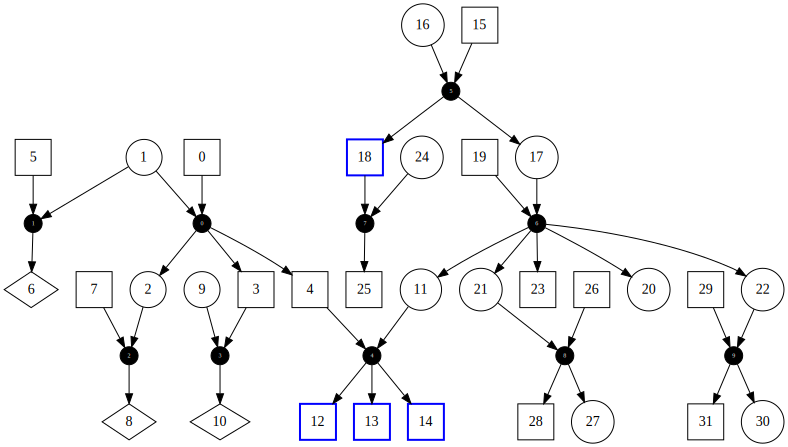

Inheritance guessXL


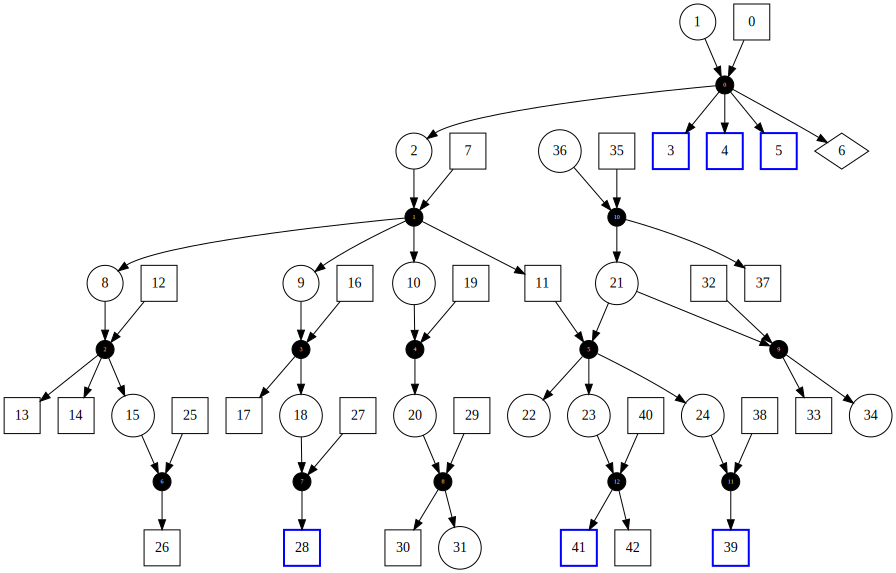

Inheritance guessXL


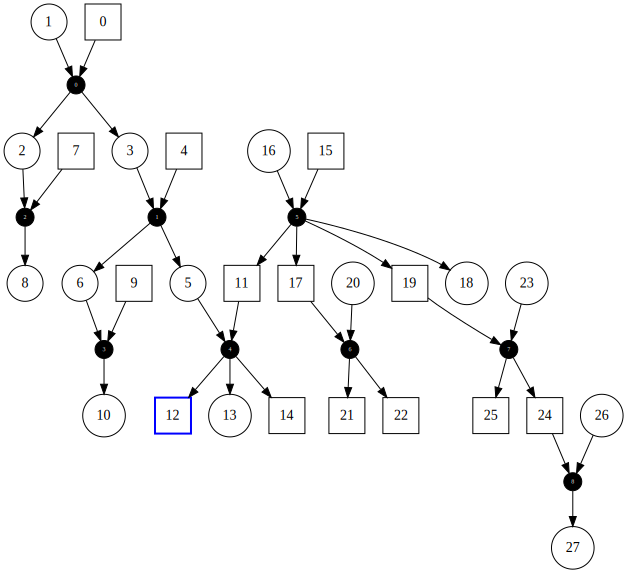

Inheritance guessAR


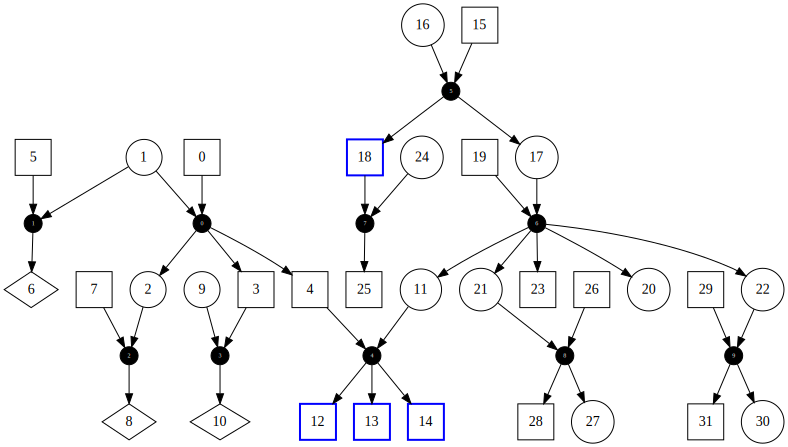

Inheritance guessXL


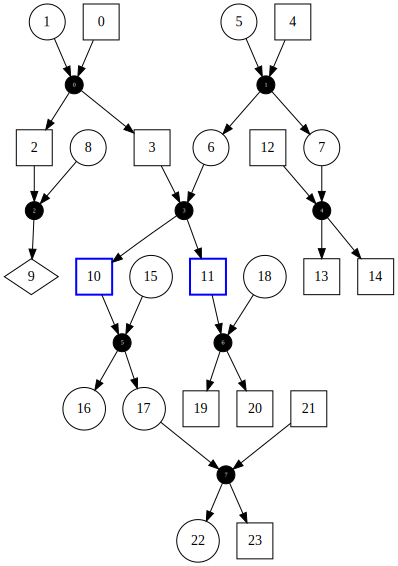

Inheritance guessXL


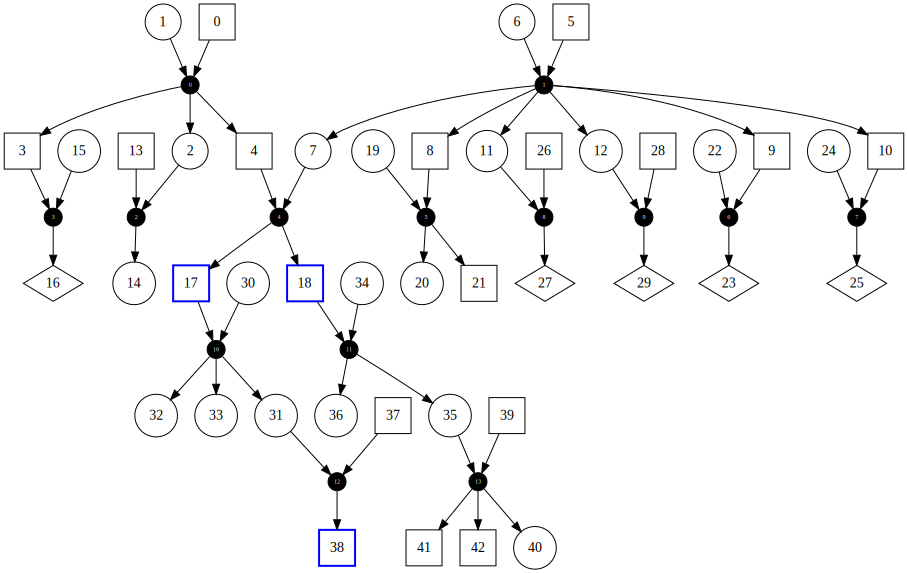

Inheritance guessXL


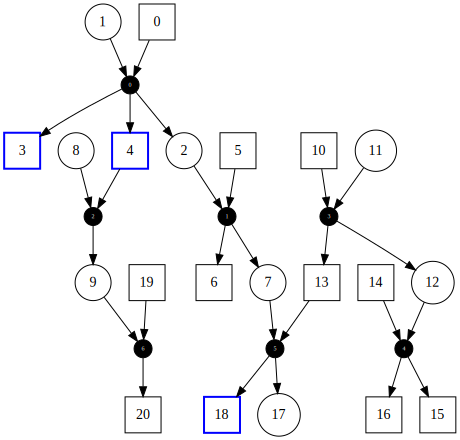

Inheritance guessXL


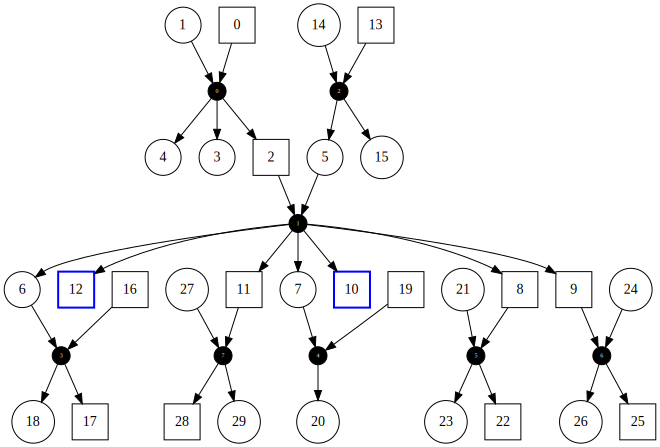

Inheritance guessXL


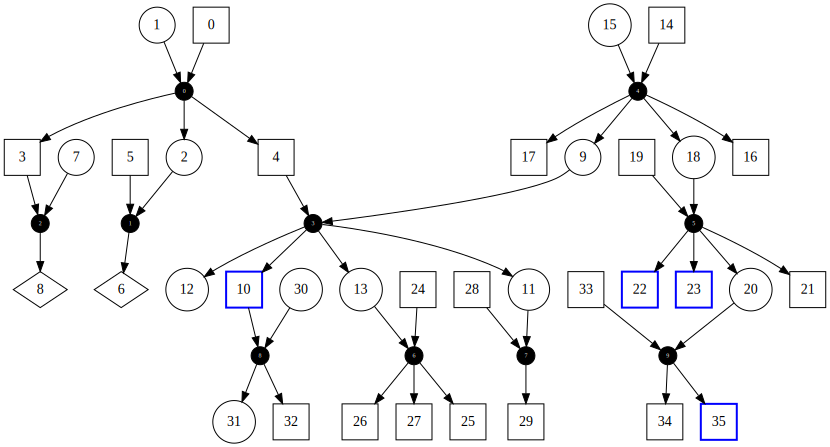

Inheritance guessXL


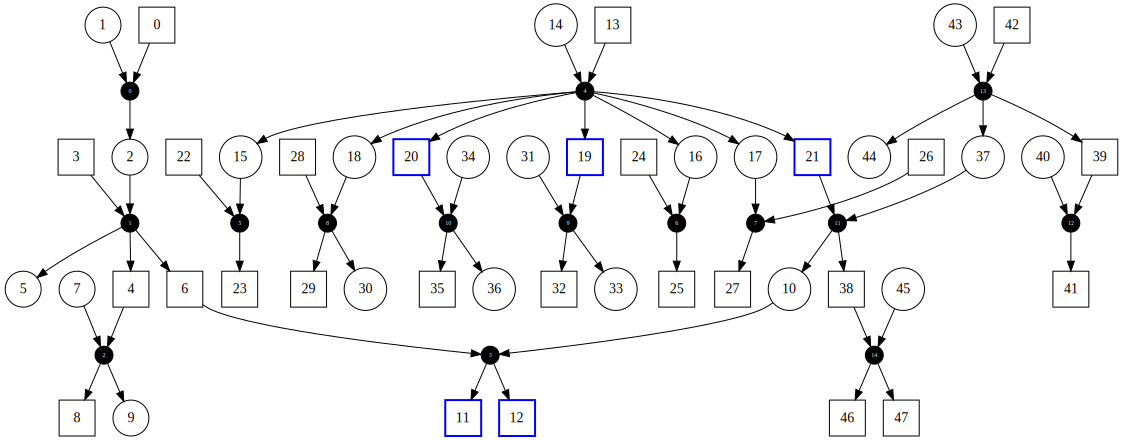

Inheritance guessXL


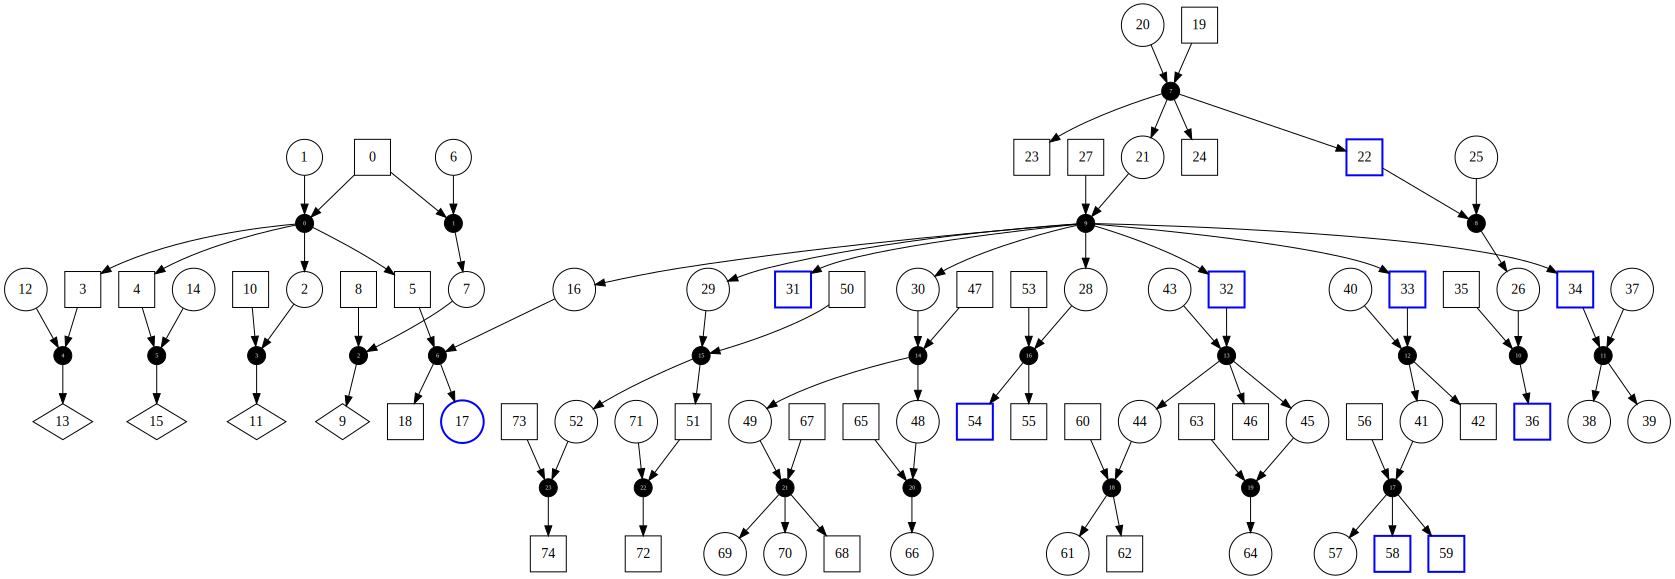

Inheritance guessXL


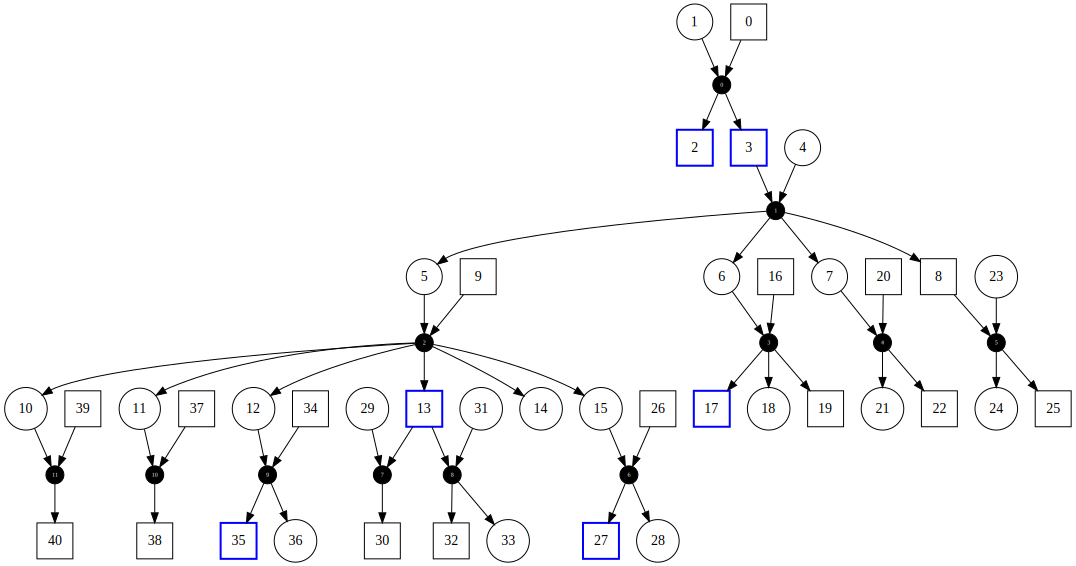

Inheritance guessXL


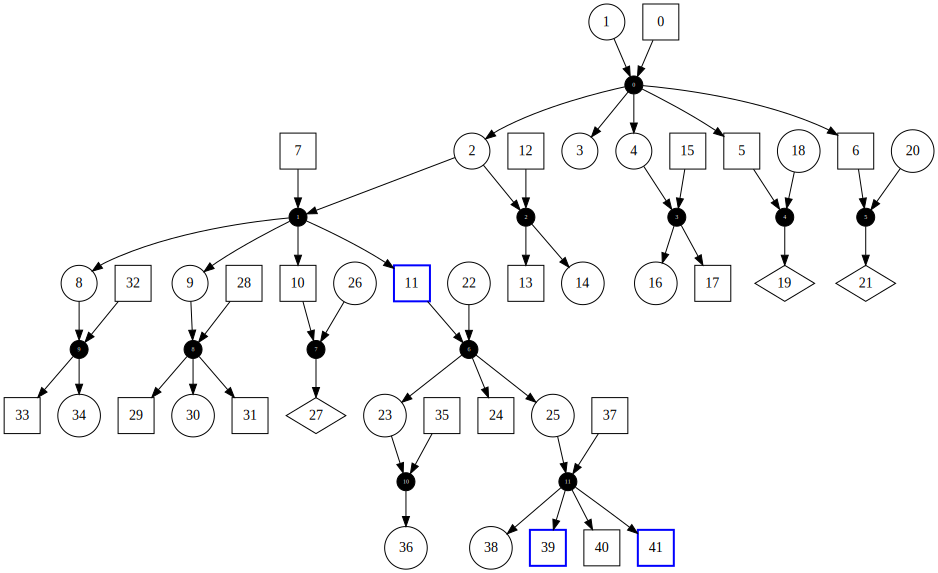

Inheritance guessXL


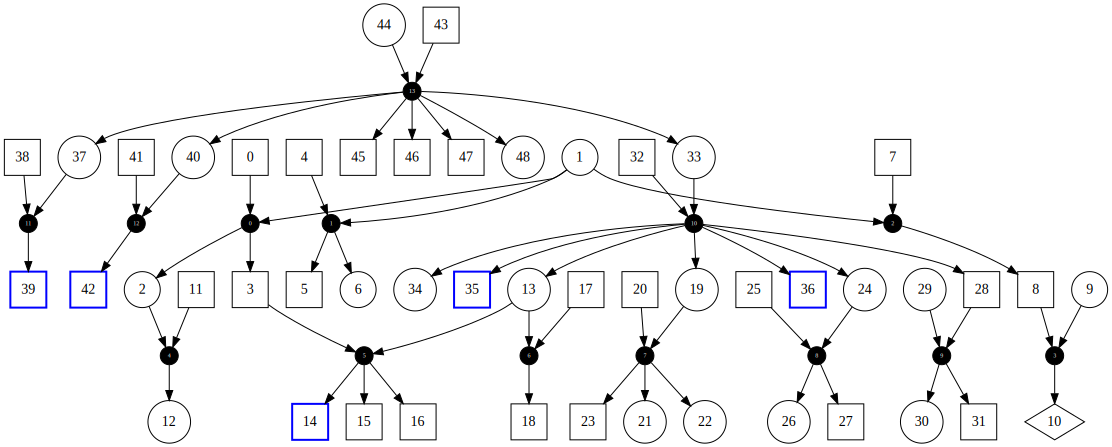

Inheritance guessXL


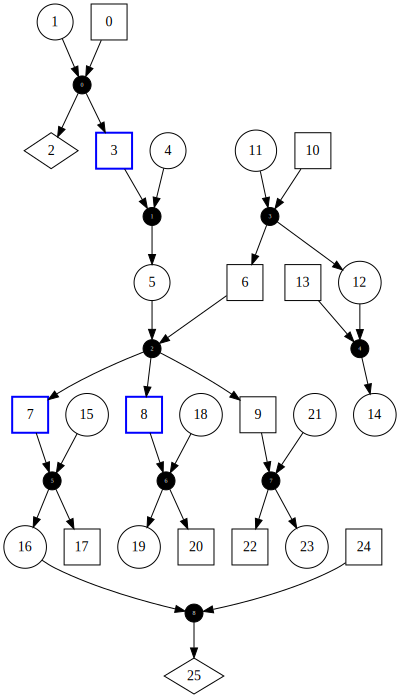

Inheritance guessXL


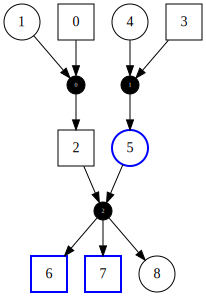

Inheritance guessAD


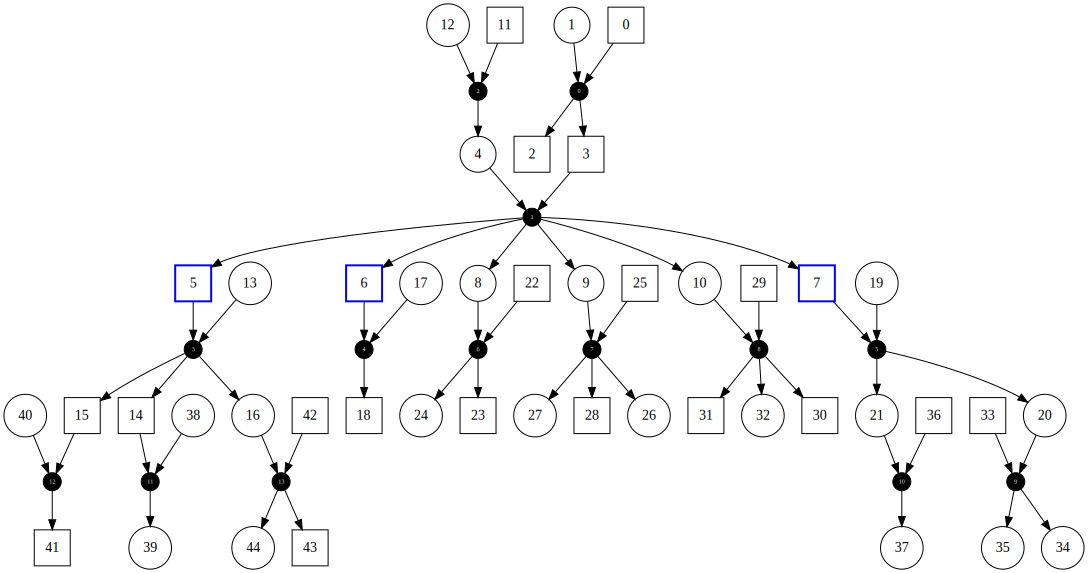

Inheritance guessXL


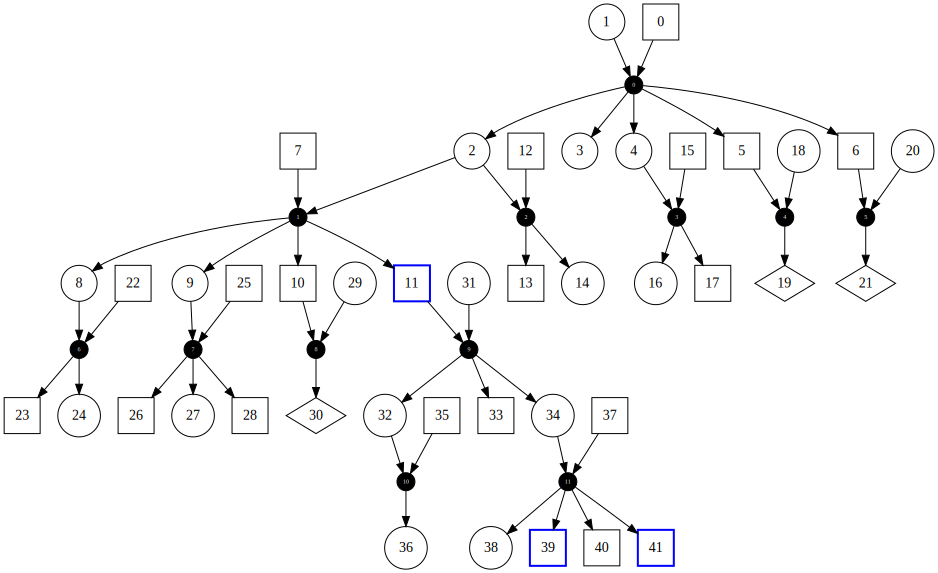

Inheritance guessXL


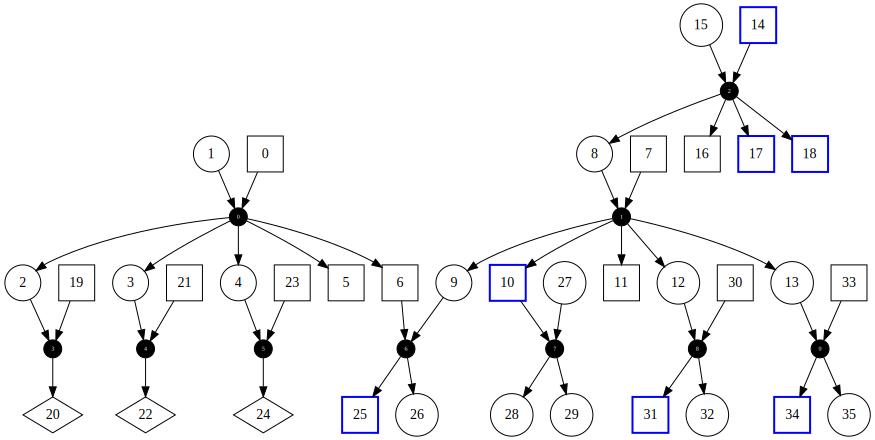

Inheritance guessXL


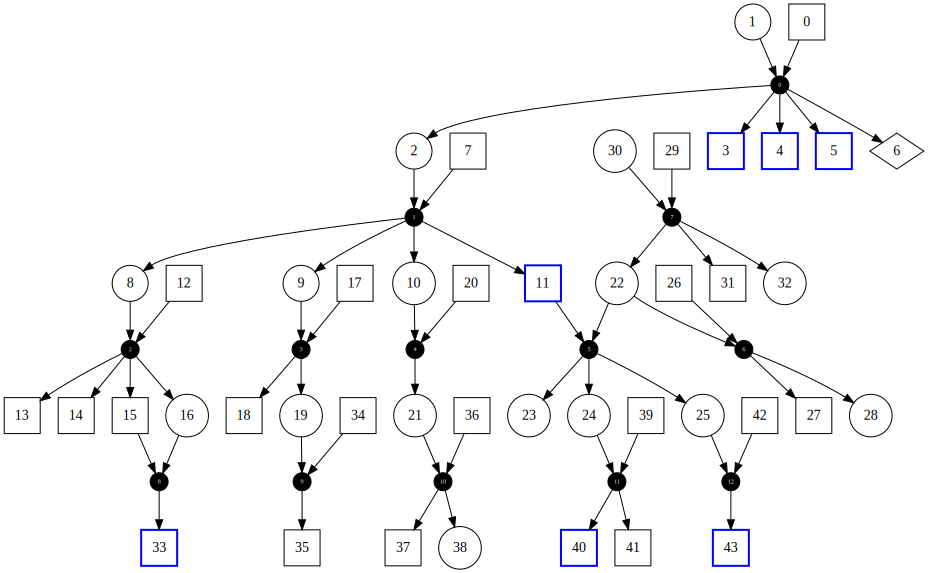

Inheritance guessXL


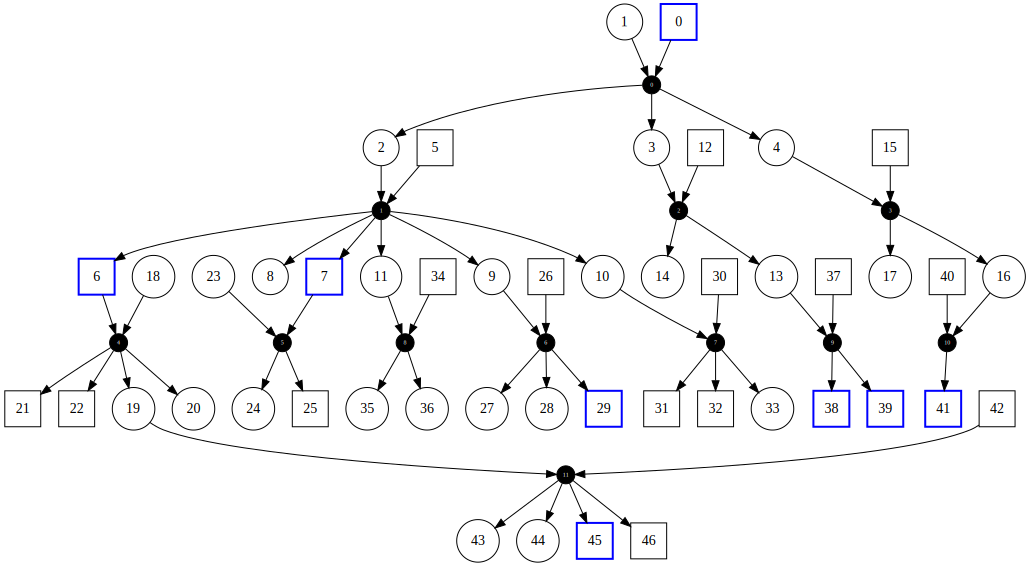

Inheritance guessXL


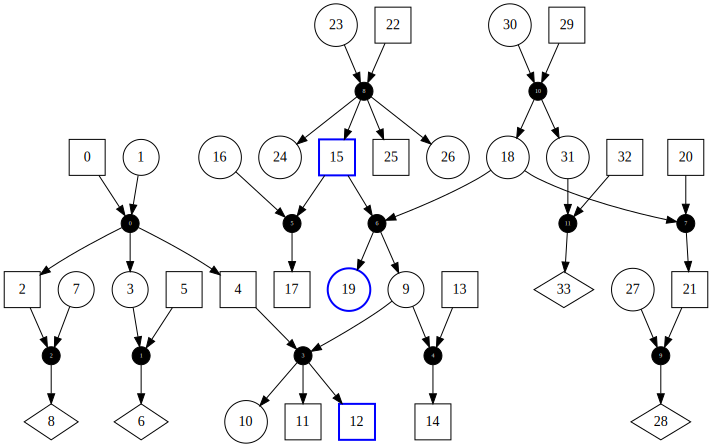

Inheritance guessXL


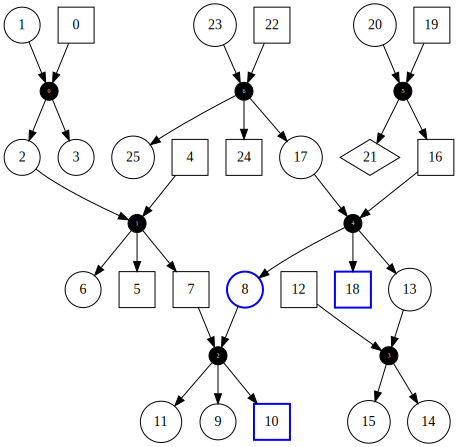

Inheritance guessXL


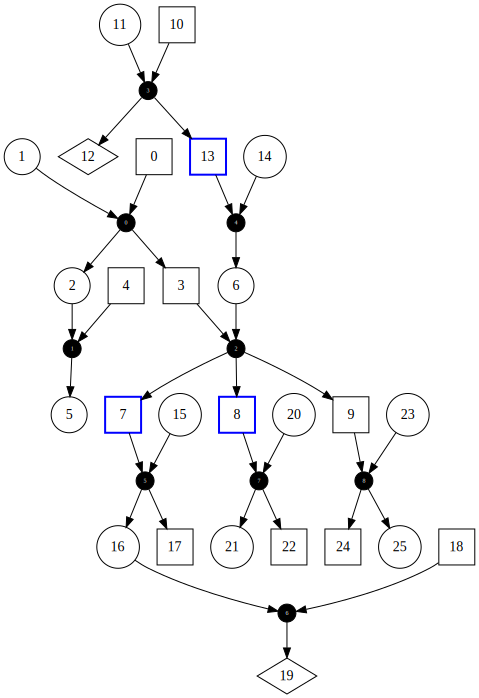

Inheritance guessXL


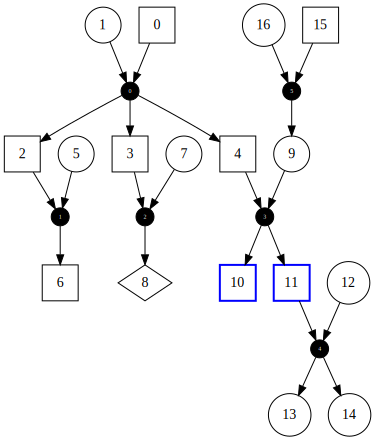

Inheritance guessXL


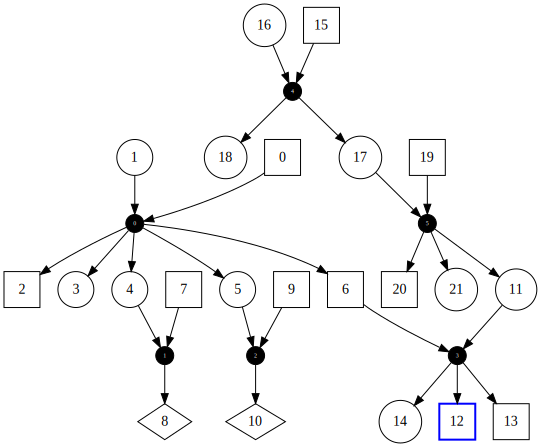

Inheritance guessAR


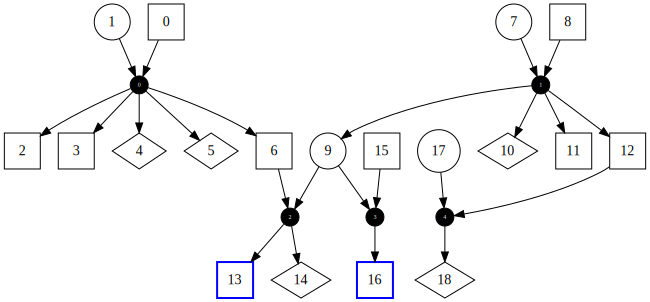

Inheritance guessXL


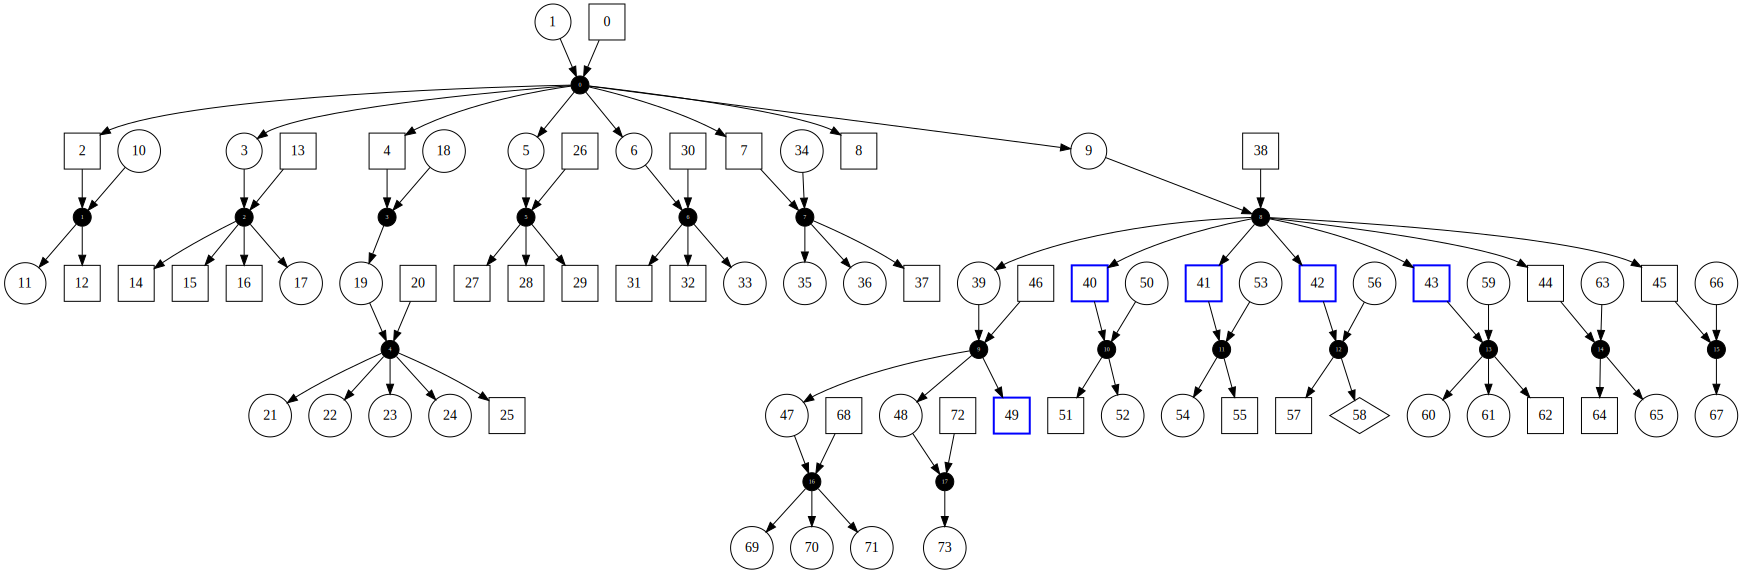

Inheritance guessXL


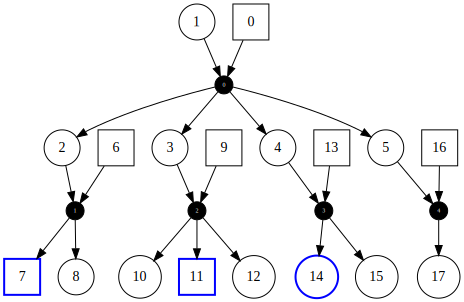

Inheritance guessAR


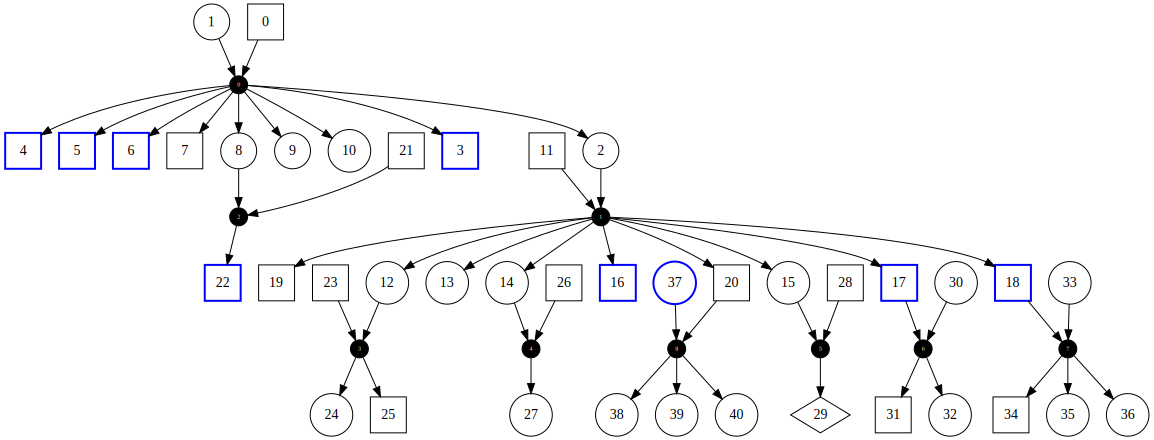

Inheritance guessXL


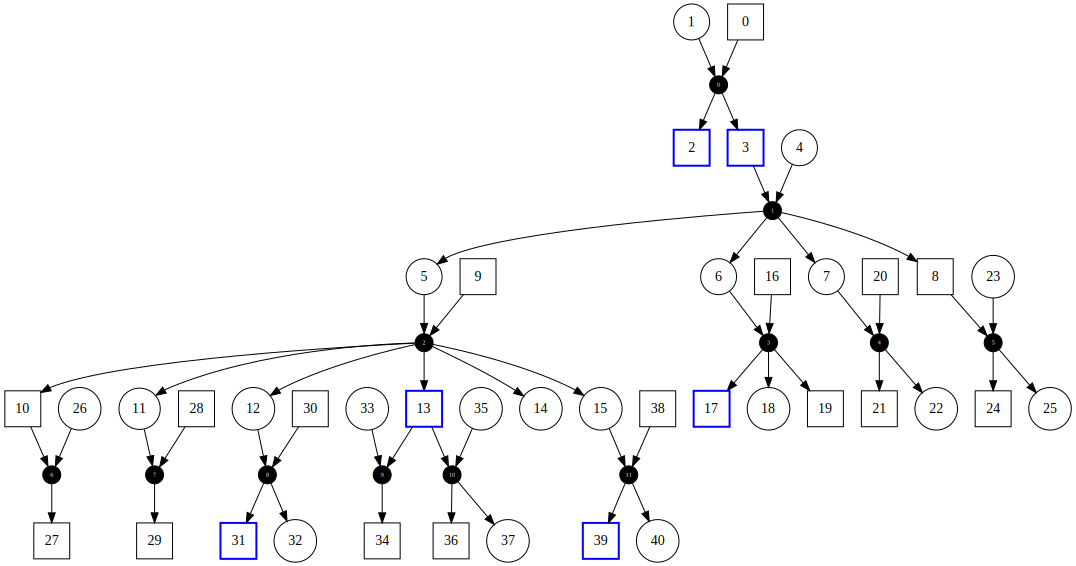

Inheritance guessXL


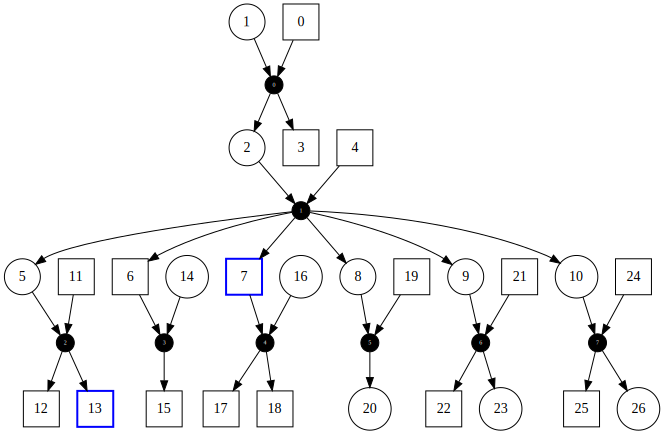

Inheritance guessXL


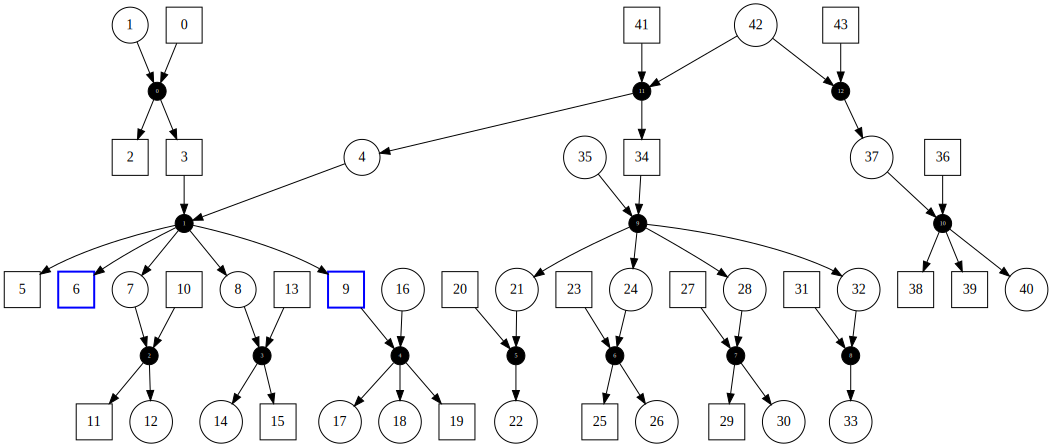

Inheritance guessXL


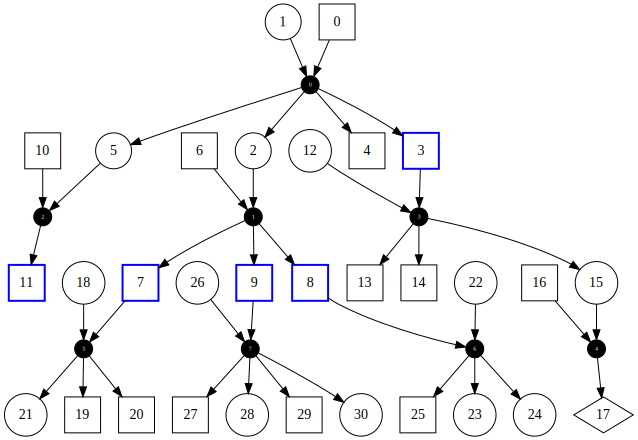

Inheritance guessXL


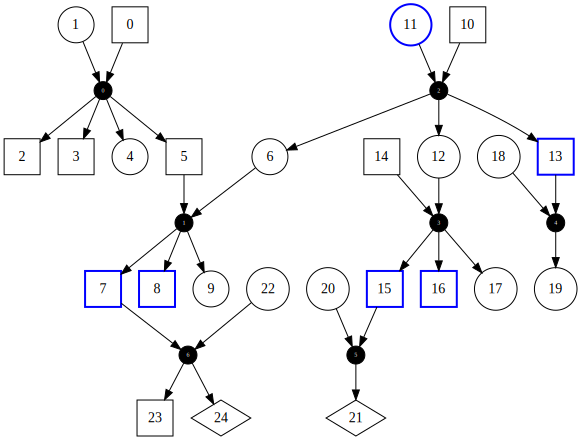

Inheritance guessXL


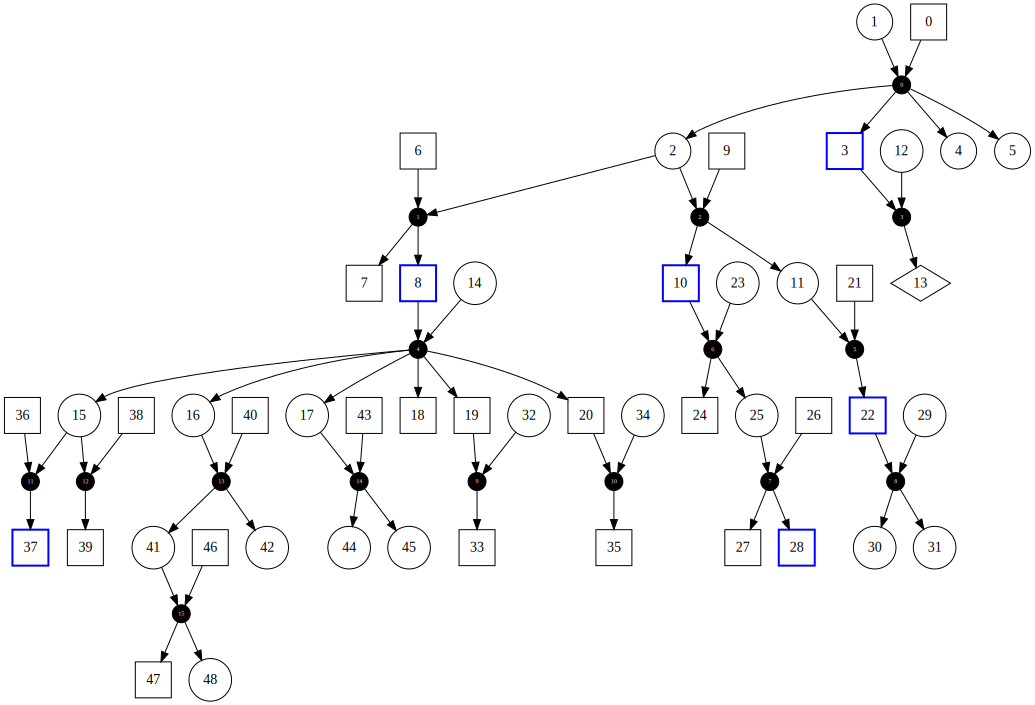

Inheritance guessXL


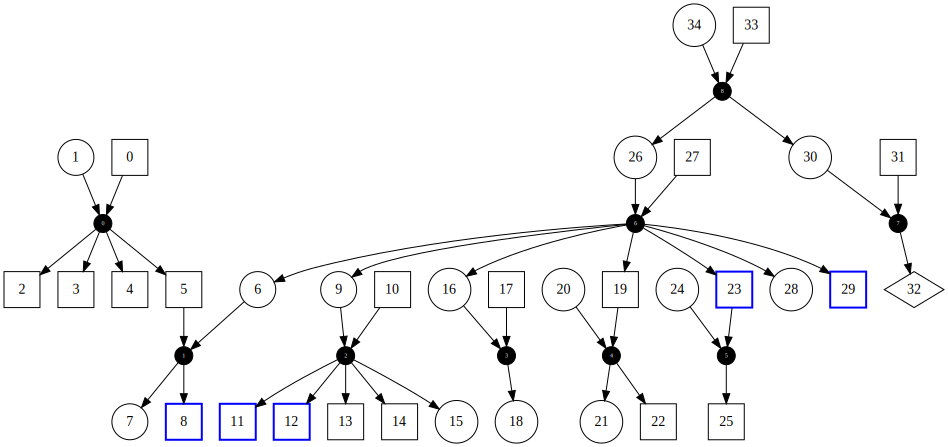

Inheritance guessXL


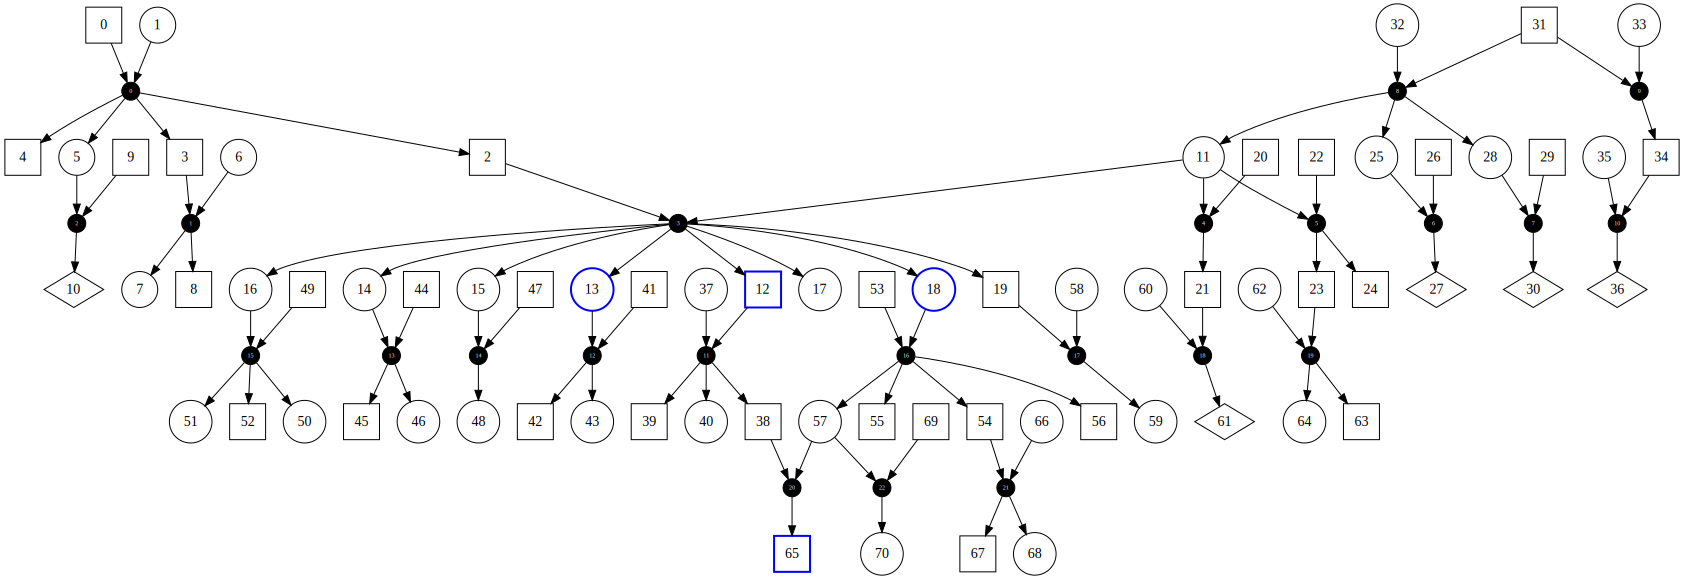

Inheritance guessXL


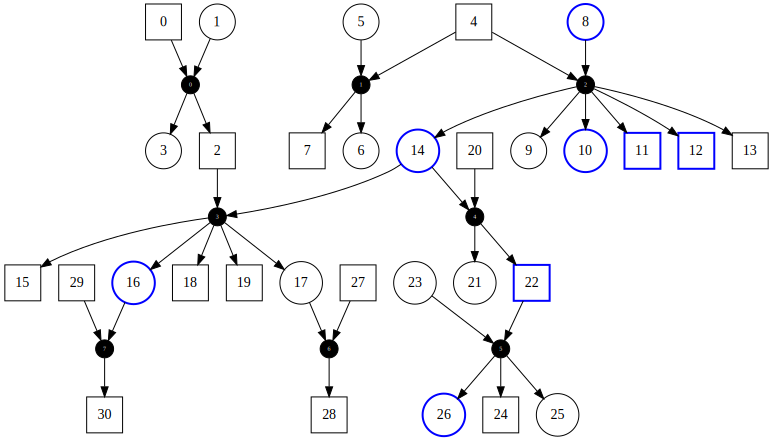

Inheritance guessAD


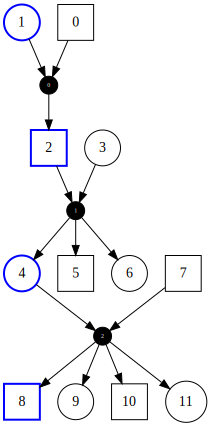

Inheritance guessAD


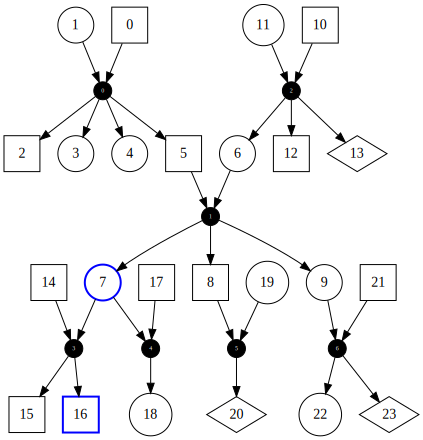

Inheritance guessAD


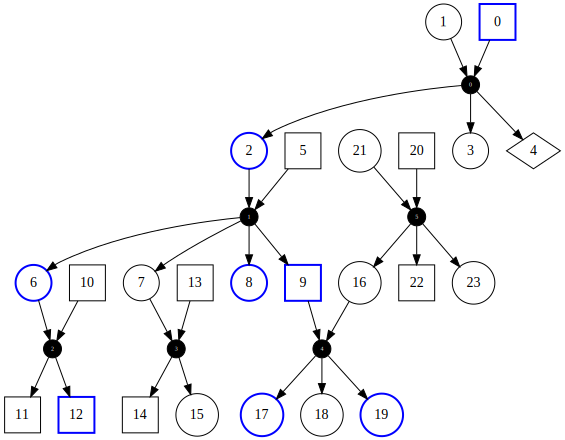

Inheritance guessAD


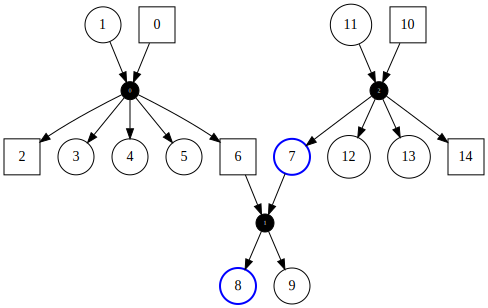

Inheritance guessAD


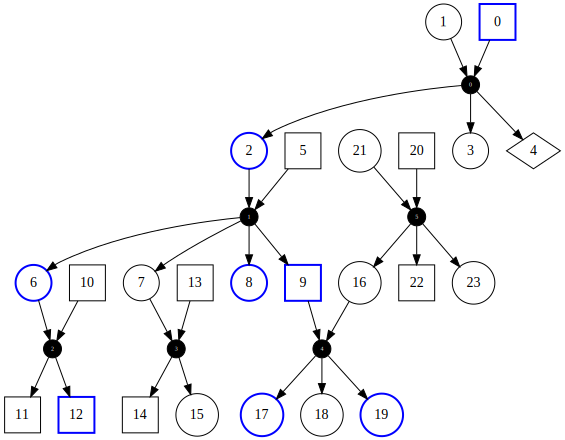

Inheritance guessAD


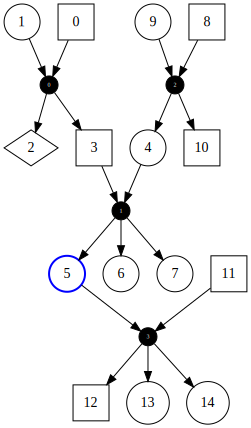

Inheritance guessAR


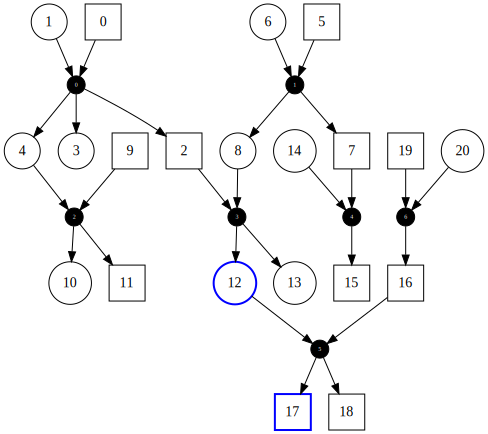

Inheritance guessAD


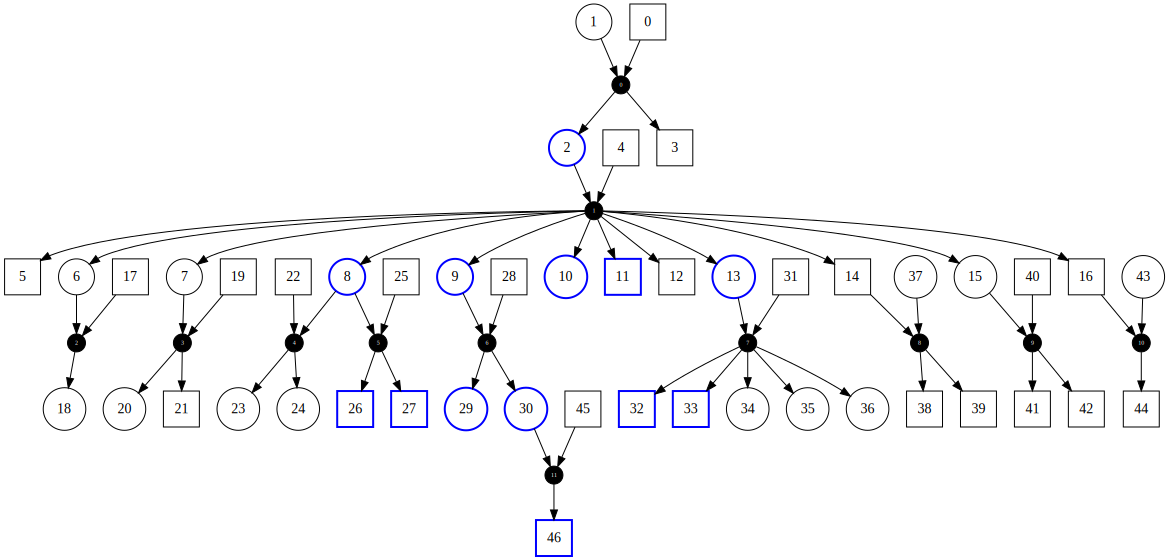

Inheritance guessAD


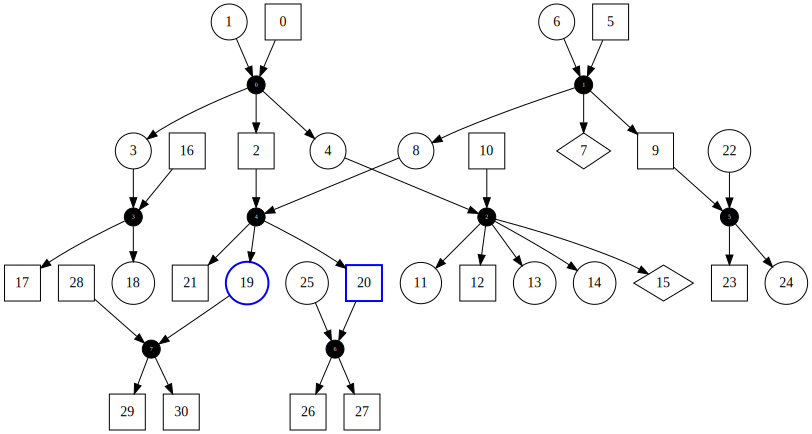

Inheritance guessAD


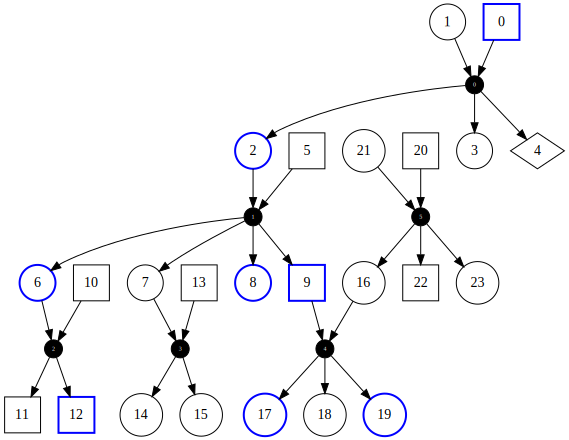

Inheritance guessAD


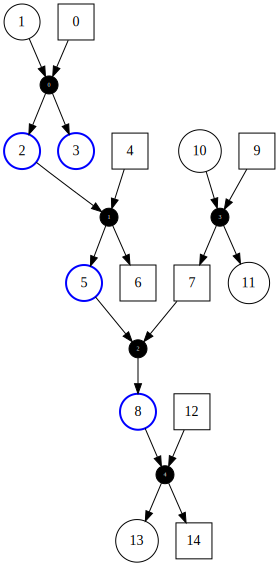

Inheritance guessAD


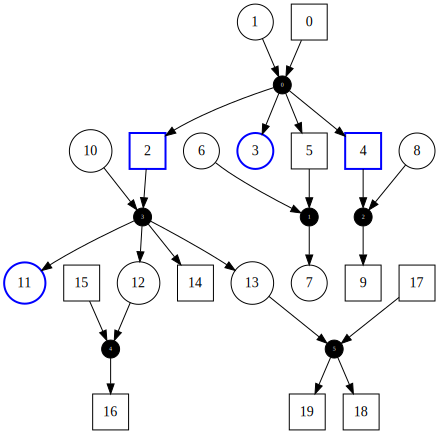

Inheritance guessAD


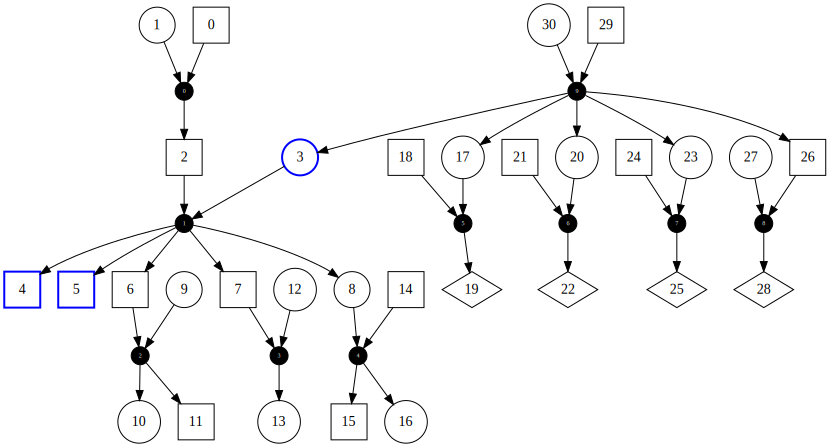

Inheritance guessAD


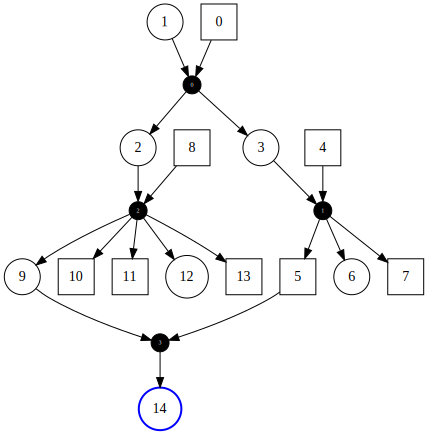

Inheritance guessAR


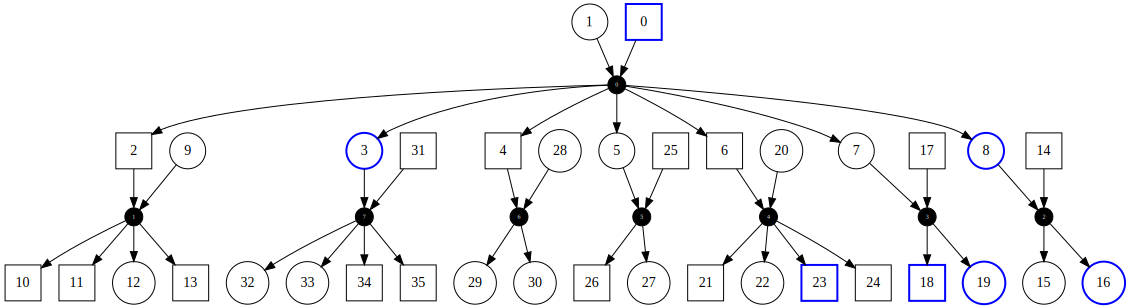

Inheritance guessXL


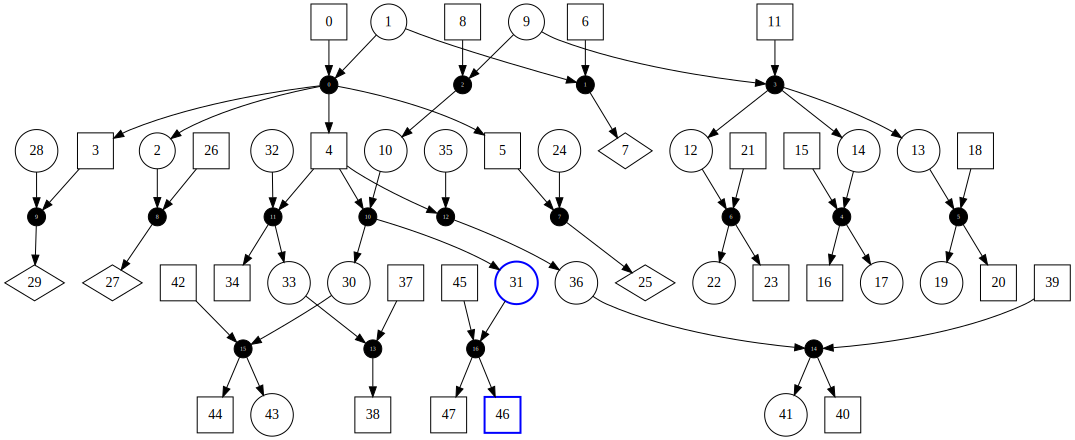

Inheritance guessAD


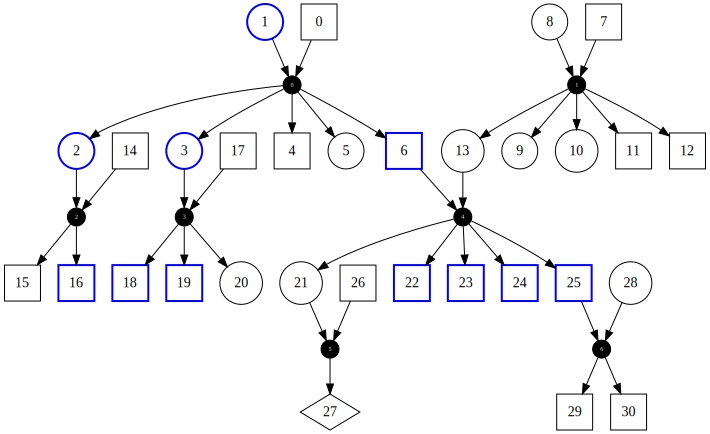

Inheritance guessAD


In [273]:
my_answers = []
for ( graph, fbs ), predicted, true_ip, prob in all_confident:
    display( graph.draw() )
    my_ans = input( 'Inheritance guess' )
    my_answers.append( my_ans )

In [274]:
my_answers

['AD',
 'AD',
 'XL',
 'AD',
 'AD',
 'AD',
 'AD',
 'AD',
 'AD',
 'AD',
 'AD',
 'AD',
 'AD',
 'AD',
 'AD',
 'AD',
 'AD',
 'AD',
 'AD',
 'AD',
 'AD',
 'AD',
 'AD',
 'AD',
 'AD',
 'AD',
 'AD',
 'AD',
 'AD',
 'AD',
 'AD',
 'AD',
 'AD',
 'AD',
 'AD',
 'AD',
 'AD',
 'AD',
 'AD',
 'AD',
 'AD',
 'AD',
 'AD',
 'AD',
 'AD',
 'AD',
 'AD',
 'AD',
 'AD',
 'AD',
 'AD',
 'AD',
 'AD',
 'AD',
 'AD',
 'AD',
 'AD',
 'AD',
 'AD',
 'AD',
 'AD',
 'AD',
 'AD',
 'AD',
 'AD',
 'AD',
 'AD',
 'AD',
 'AD',
 'AD',
 'AD',
 'AD',
 'AD',
 'AR',
 'AD',
 'AR',
 'XL',
 'AR',
 'AR',
 'AR',
 'AR',
 'AR',
 'AR',
 'AR',
 'AD',
 'AR',
 'XL',
 'AR',
 'AR',
 'AD',
 'AR',
 'AR',
 'AR',
 'AR',
 'AR',
 'AD',
 'AR',
 'AR',
 'AR',
 'AR',
 'AR',
 'AR',
 'AR',
 'AR',
 'AR',
 'AR',
 'AR',
 'AR',
 'AR',
 'AR',
 'AR',
 'AR',
 'AR',
 'XL',
 'XL',
 'AD',
 'AD',
 'AR',
 'AR',
 'XL',
 'AD',
 'AD',
 'XL',
 'AD',
 'AR',
 'AD',
 'AD',
 'XL',
 'AD',
 'AR',
 'XL',
 'XL',
 'AD',
 'AD',
 'XL',
 'AR',
 'AD',
 'XL',
 'AD',
 'XL',
 'XL',
 'AR',
 'XL',

In [275]:
human_ips = np.array( [ labels.index( i ) for i in my_answers ] )

In [276]:
human_ips

array([0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 2, 1, 1, 1, 1, 1, 1, 1, 0, 1, 2, 1,
       1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 2, 2, 0, 0, 1, 1, 2, 0, 0, 2, 0, 1, 0, 0, 2, 0, 1, 2, 2,
       0, 0, 2, 1, 0, 2, 0, 2, 2, 1, 2, 1, 0, 2, 1, 0, 2, 2, 2, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0])

In [277]:
predicted_ips

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 2, 2, 0, 0, 2, 2, 2, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 2, 0,
       0, 0, 2, 2, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 2, 0, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0])

In [278]:
( human_ips == predicted_ips ).sum()

188

In [279]:
confusion_matrix( human_ips, predicted_ips )

array([[100,   4,   2],
       [  3,  35,  10],
       [  6,   1,  53]])

[[100   4   2]
 [  3  35  10]
 [  6   1  53]]
[[0.94339623 0.03773585 0.01886792]
 [0.0625     0.72916667 0.20833333]
 [0.1        0.01666667 0.88333333]]


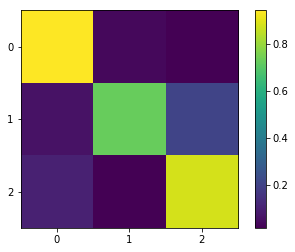

Number of AD 0
Number of AR 0
Number of XL 0
AD Accuracy: 0.9433962264150944
AR Accuracy: 0.7291666666666666
XL Accuracy: 0.8833333333333333
Cohen Kappa 0.8042361550911266


In [280]:
confusionMatrix(true=human_ips, predicted=predicted_ips, labels=[0,1,2])

In [296]:
(101+37+50)/len( my_answers )

0.8785046728971962

[[101   0   3]
 [  4  37  12]
 [  4   3  50]]
[[0.97115385 0.         0.02884615]
 [0.0754717  0.69811321 0.22641509]
 [0.07017544 0.05263158 0.87719298]]


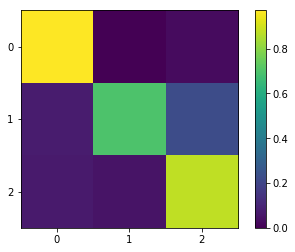

Number of AD 0
Number of AR 0
Number of XL 0
AD Accuracy: 0.9711538461538461
AR Accuracy: 0.6981132075471698
XL Accuracy: 0.8771929824561403
Cohen Kappa 0.8056923345556137


In [261]:
confusionMatrix(true=human_ips, predicted=predicted_ips, labels=[0,1,2])

In [293]:
folder_name = 'disagree_algorithm_correct'
for i, ( ( graph, fbs ), predicted, true_ip, prob ) in enumerate( all_confident ):
    if( human_ips[ i ] != predicted_ips[ i ] and predicted == true_ip ):
        d = graph.draw()
        name = folder_name + '/%s__MYPRED_%s_PRED_%s_TRUE_%s'%( graph.studyID, my_answers[ i ], predicted, true_ip )
        print( name )
        d.render( name, view=False, cleanup=True )

disagree_algorithm_correct/NEI_INVVH314FE8__MYPRED_XL_PRED_AD_TRUE_AD
disagree_algorithm_correct/611JC__MYPRED_AD_PRED_AR_TRUE_AR
disagree_algorithm_correct/NEI_INVLD750EXK__MYPRED_AD_PRED_AR_TRUE_AR
disagree_algorithm_correct/405JA__MYPRED_AR_PRED_XL_TRUE_XL
disagree_algorithm_correct/NEI_INVBX298MH5__MYPRED_AR_PRED_XL_TRUE_XL
disagree_algorithm_correct/NEI_INVLP180BFG__MYPRED_AD_PRED_XL_TRUE_XL
disagree_algorithm_correct/5191BD__MYPRED_AR_PRED_XL_TRUE_XL
disagree_algorithm_correct/671AH__MYPRED_AR_PRED_XL_TRUE_XL


In [294]:
folder_name = 'disagree_myprediction_correct'
for i, ( ( graph, fbs ), predicted, true_ip, prob ) in enumerate( all_confident ):
    if( human_ips[ i ] != predicted_ips[ i ] and my_answers[ i ] == true_ip ):
        d = graph.draw()
        name = folder_name + '/%s__MYPRED_%s_PRED_%s_TRUE_%s'%( graph.studyID, my_answers[ i ], predicted, true_ip )
        print( name )
        d.render( name, view=False, cleanup=True )

disagree_myprediction_correct/3183DG__MYPRED_AD_PRED_XL_TRUE_AD
disagree_myprediction_correct/3235JW__MYPRED_AD_PRED_AR_TRUE_AD
disagree_myprediction_correct/5694JL__MYPRED_AR_PRED_XL_TRUE_AR
disagree_myprediction_correct/NEI_INVGM538ZG1__MYPRED_AR_PRED_XL_TRUE_AR
disagree_myprediction_correct/NEI_INVDP765JX6__MYPRED_AR_PRED_AD_TRUE_AR
disagree_myprediction_correct/NEI_INVPN452HD6__MYPRED_AR_PRED_AD_TRUE_AR
disagree_myprediction_correct/3308WM__MYPRED_AR_PRED_XL_TRUE_AR
disagree_myprediction_correct/NEI_INVAY629ZB8__MYPRED_AR_PRED_XL_TRUE_AR
disagree_myprediction_correct/4224JH__MYPRED_AR_PRED_AD_TRUE_AR
disagree_myprediction_correct/NEI_INVDB542NK4__MYPRED_AR_PRED_XL_TRUE_AR
disagree_myprediction_correct/NEI_INVMK954UYF__MYPRED_XL_PRED_AR_TRUE_XL
disagree_myprediction_correct/NEI_INVJE037JA8__MYPRED_XL_PRED_AD_TRUE_XL


- Skipping male generation

In [297]:
import pandas as pd 

df = pd.read_csv( 'pedigreeAnswers.csv' )

/anaconda3/envs/GenModel/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [298]:
df

Patient ID PedAvail  numAff  multGenAff  MAffSon  MAffDau  skipping  \
0             3007TR        Y       1       False    False    False         1   
1             1011MB        Y       2        True    False    False         1   
2             1022AS        Y       1       False    False    False         1   
3             1036RC        Y       1       False    False    False         1   
4             1038CG        Y       4        True    False    False         2   
5             1044IO        Y       2       False    False    False         1   
6             1046DA        Y       4        True    False    False         3   
7             1075NP        Y       3        True    False    False         2   
8             1079JM        Y       1       False    False    False         1   
9             1083BF        Y       3       False    False    False         1   
10            1084LN        Y       8        True     True     True         2   
11            1089JB        Y       6        True    False    False         2   
12             164KD        Y       2       False    False    False         1   
13             167MW        Y       3        True    False    False         1   
14             189DC        Y       2        True    False     True         1   
15            2003PB        Y       2       False    False    False         1   
16            2016CH        Y       4       False    False    False         1   
17            2018LM        Y       4        True    False    False         2   
18            2042JD        Y       1       False    False    False         1   
19            2049EE        Y       9        True    False    False         2   
20            2055JS        Y       1       False    False    False         1   
21            2065GE        Y       2        True    False    False         2   
22            2068AP        Y       5        True    False     True         1   
23            2079NC        Y       6        True     True     True         1   
24             208CM        Y       1       False    False    False         1   
25            2093SA        Y       2       False    False    False         1   
26            2094KA        Y       2       False    False    False         1   
27             230KK        Y       1       False    False    False         1   
28             231AG        Y       2       False    False    False         1   
29             235TL        Y       1       False    False    False         1   
..               ...      ...     ...         ...      ...      ...       ...   
470  NEI_INVRP075DR0        Y       5        True    False     True         1   
471  NEI_INVRW032HP6        Y       1       False    False    False         1   
472  NEI_INVRZ998GAH        Y       2        True    False    False         1   
473  NEI_INVTD470RL4        Y      11        True     True     True         3   
474  NEI_INVTE607VYA        Y       1       False    False    False         1   
475  NEI_INVTF299VC2        Y       2        True    False    False         2   
476  NEI_INVTJ109AY9        Y       1       False    False    False         1   
477  NEI_INVTM269RXM        Y       1       False    False    False         1   
478  NEI_INVTP921JLT        Y       6        True     True     True         1   
479  NEI_INVTR106KDR        Y       9        True     True     True         1   
480  NEI_INVTU321XN5        Y       7        True     True     True         3   
481  NEI_INVTV167NUE        Y      13        True    False    False         1   
482  NEI_INVUP593ZEZ        Y       3        True    False    False         2   
483  NEI_INVUY628MYF        Y       5        True    False    False         2   
484  NEI_INVVA212BAL        Y      11        True    False    False         1   
485  NEI_INVVA744LZ4        Y       3        True    False    False         2   
486  NEI_INVVD274UGD        Y       1       False    False    False         1   
487  NEI_INVVD368XUB        Y       5    

In [283]:
mask = []
for i, ( ( graph, fbs ), predicted, true_ip, prob ) in enumerate( all_confident ):
    if( graph.getNumbAffected() == 1 ):
        mask.append( False )
    else:
        mask.append( True )
mask = np.array( mask )

[[73 12  4]
 [21 24 16]
 [15  4 45]]
[[0.82022472 0.13483146 0.04494382]
 [0.3442623  0.39344262 0.26229508]
 [0.234375   0.0625     0.703125  ]]


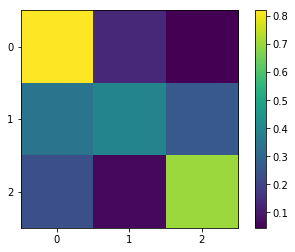

Number of AD 0
Number of AR 0
Number of XL 0
AD Accuracy: 0.8202247191011236
AR Accuracy: 0.39344262295081966
XL Accuracy: 0.703125
Cohen Kappa 0.47760637396168837


In [285]:
confusionMatrix(true=true_ips, predicted=predicted_ips, labels=[0,1,2])

[[74 12  3]
 [16 30 15]
 [16  6 42]]
[[0.83146067 0.13483146 0.03370787]
 [0.26229508 0.49180328 0.24590164]
 [0.25       0.09375    0.65625   ]]


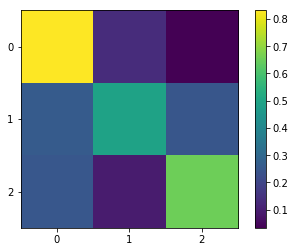

Number of AD 0
Number of AR 0
Number of XL 0
AD Accuracy: 0.8314606741573034
AR Accuracy: 0.4918032786885246
XL Accuracy: 0.65625
Cohen Kappa 0.5082787051429344


In [286]:
confusionMatrix(true=true_ips, predicted=human_ips, labels=[0,1,2])

In [ ]:
assert 0

In [ ]:
import pickle
pickle.dump( [ r[ :-3 ] for r in results ], open( 'full_results.p', 'wb' ) )

In [18]:
# sorted_graphs, predicted, true, all_probs, _, _, _ = list( zip( *results ) )
sorted_graphs, predicted, true, all_probs = list( zip( *results ) )

In [19]:
def separateResults( results ):
    sorted_graphs, predicted, true, all_probs = list( zip( *results ) )
#     sorted_graphs, predicted, true, all_probs, _, _, _ = list( zip( *results ) )
    ad_results, ar_results, xl_results = [], [], []
    for g, p, t, prob in zip( sorted_graphs, predicted, true, all_probs ):
        if( t == 'AD' ):
            ad_results.append( ( g, p, prob ) )
        elif( t == 'AR' ):
            ar_results.append( ( g, p, prob ) )
        else:
            xl_results.append( ( g, p, prob ) )
    return ad_results, ar_results, xl_results

In [20]:
ad_results, ar_results, xl_results = separateResults( results )

In [21]:
CONFIDENT = 0.80
SORTA_CONFIDENT = 0.50
def furtherSeparate( results, true_ip, true_ip_index ):
    confident_correct, confident_wrong, sorta_confident_correct, sorta_confident_wrong, unconfident_correct, unconfident_wrong = [], [], [], [], [], []
    for graph, predicted, prob in results:
        max_predicted = np.max( prob )
        if( predicted == true_ip ):
            if( max_predicted > CONFIDENT ):
                confident_correct.append( ( graph, predicted, true_ip, prob ) )
            elif( max_predicted > SORTA_CONFIDENT ):
                sorta_confident_correct.append( ( graph, predicted, true_ip, prob ) )
            else:
                unconfident_correct.append( ( graph, predicted, true_ip, prob ) )
        else:
            if( max_predicted > CONFIDENT ):
                confident_wrong.append( ( graph, predicted, true_ip, prob ) )
            elif( max_predicted > SORTA_CONFIDENT ):
                sorta_confident_wrong.append( ( graph, predicted, true_ip, prob ) )
            else:
                unconfident_wrong.append( ( graph, predicted, true_ip, prob ) )
    return confident_correct, confident_wrong, sorta_confident_correct, sorta_confident_wrong, unconfident_correct, unconfident_wrong

In [22]:
ad_confident_correct, ad_confident_wrong, ad_sorta_confident_correct, ad_sorta_confident_wrong, ad_unconfident_correct, ad_unconfident_wrong = furtherSeparate( ad_results, 'AD', 0 )
ar_confident_correct, ar_confident_wrong, ar_sorta_confident_correct, ar_sorta_confident_wrong, ar_unconfident_correct, ar_unconfident_wrong = furtherSeparate( ar_results, 'AR', 1 )
xl_confident_correct, xl_confident_wrong, xl_sorta_confident_correct, xl_sorta_confident_wrong, xl_unconfident_correct, xl_unconfident_wrong = furtherSeparate( xl_results, 'XL', 2 )

In [23]:
print( 'ad_confident_correct', len( ad_confident_correct ) )
print( 'ad_confident_wrong', len( ad_confident_wrong ) )
print( 'ad_sorta_confident_correct', len( ad_sorta_confident_correct ) )
print( 'ad_sorta_confident_wrong', len( ad_sorta_confident_wrong ) )
print( 'ad_unconfident_correct', len( ad_unconfident_correct ) )
print( 'ad_unconfident_wrong', len( ad_unconfident_wrong ) )
print()
print( 'ar_confident_correct', len( ar_confident_correct ) )
print( 'ar_confident_wrong', len( ar_confident_wrong ) )
print( 'ar_sorta_confident_correct', len( ar_sorta_confident_correct ) )
print( 'ar_sorta_confident_wrong', len( ar_sorta_confident_wrong ) )
print( 'ar_unconfident_correct', len( ar_unconfident_correct ) )
print( 'ar_unconfident_wrong', len( ar_unconfident_wrong ) )
print()
print( 'xl_confident_correct', len( xl_confident_correct ) )
print( 'xl_confident_wrong', len( xl_confident_wrong ) )
print( 'xl_sorta_confident_correct', len( xl_sorta_confident_correct ) )
print( 'xl_sorta_confident_wrong', len( xl_sorta_confident_wrong ) )
print( 'xl_unconfident_correct', len( xl_unconfident_correct ) )
print( 'xl_unconfident_wrong', len( xl_unconfident_wrong ) )
print()

ad_confident_correct 73
ad_confident_wrong 16
ad_sorta_confident_correct 0
ad_sorta_confident_wrong 20
ad_unconfident_correct 4
ad_unconfident_wrong 19

ar_confident_correct 24
ar_confident_wrong 37
ar_sorta_confident_correct 22
ar_sorta_confident_wrong 13
ar_unconfident_correct 33
ar_unconfident_wrong 68

xl_confident_correct 45
xl_confident_wrong 19
xl_sorta_confident_correct 6
xl_sorta_confident_wrong 3
xl_unconfident_correct 14
xl_unconfident_wrong 11



In [24]:
def confidenceLevelMetaStats( ad, ar, xl, ax ):
    # Histogram of number of affected people
    n_affected = []
    for graph, _, _, _ in itertools.chain( ad, ar, xl ):
        n_affected.append( graph[ 0 ].getNumbAffected() )
    ax.hist( n_affected )

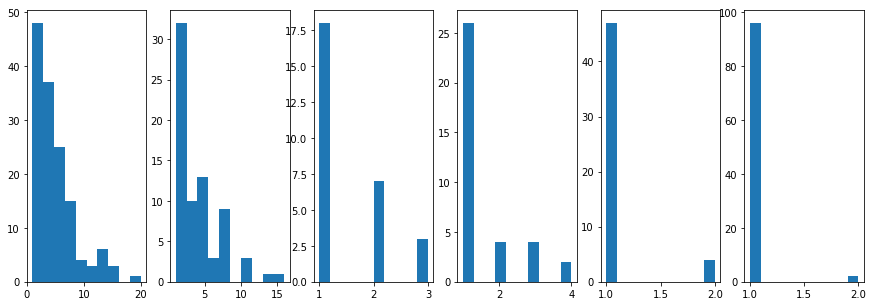

In [25]:
plt.figure( figsize=( 15, 5 ) )
axes = [ plt.subplot2grid( shape=( 1, 6 ), loc=( 0, i ), colspan=1, rowspan=1 ) for i in range( 6 ) ]
confidenceLevelMetaStats( ad_confident_correct, ar_confident_correct, xl_confident_correct, axes[ 0 ] )
confidenceLevelMetaStats( ad_confident_wrong, ar_confident_wrong, xl_confident_wrong, axes[ 1 ] )
confidenceLevelMetaStats( ad_sorta_confident_correct, ar_sorta_confident_correct, xl_sorta_confident_correct, axes[ 2 ] )
confidenceLevelMetaStats( ad_sorta_confident_wrong, ar_sorta_confident_wrong, xl_sorta_confident_wrong, axes[ 3 ] )
confidenceLevelMetaStats( ad_unconfident_correct, ar_unconfident_correct, xl_unconfident_correct, axes[ 4 ] )
confidenceLevelMetaStats( ad_unconfident_wrong, ar_unconfident_wrong, xl_unconfident_wrong, axes[ 5 ] )
plt.show()

In [26]:
def onlyConfident( ad, ar, xl ):
    res = ad + ar + xl
    print( len ( res ) )

(array([51.,  2.,  5., 10.,  6., 33.,  9.,  5.,  2.,  9.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

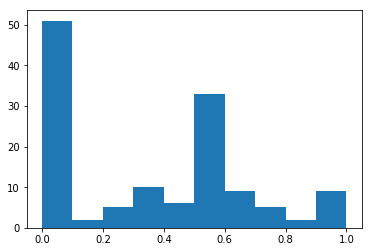

In [27]:
n_affected = []
for graph, _, _ in ad_results:
    ans = 0
    for node, attr in graph[ 0 ].attrs.items():
        if( attr[ 'affected' ] == True and attr[ 'sex' ] == 'male' ):
            ans += 1    
    if( graph[ 0 ].getNumbAffected() > 1 ):
        n_affected.append( ans / graph[ 0 ].getNumbAffected() )    
    else:
        n_affected.append( 0 )  
#     n_affected.append( graph[ 0 ].getNumbAffected() )
plt.hist( n_affected )

(array([151.,   1.,   0.,   6.,   0.,  19.,   4.,   3.,   0.,  13.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

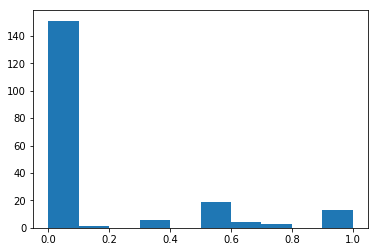

In [28]:
n_affected = []
for graph, _, _ in ar_results:
    ans = 0
    for node, attr in graph[ 0 ].attrs.items():
        if( attr[ 'affected' ] == True and attr[ 'sex' ] == 'male' ):
            ans += 1    
    if( graph[ 0 ].getNumbAffected() > 1 ):
        n_affected.append( ans / graph[ 0 ].getNumbAffected() )    
    else:
        n_affected.append( 0 )    
#     n_affected.append( graph[ 0 ].getNumbAffected() )
plt.hist( n_affected )

(array([39.,  0.,  0.,  4.,  2.,  7.,  7.,  1.,  2., 36.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

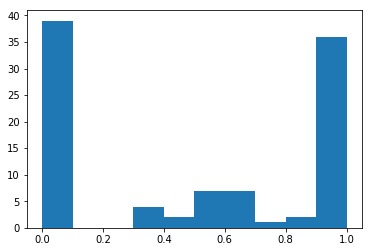

In [29]:
n_affected = []
for graph, _, _ in xl_results:
    ans = 0
    for node, attr in graph[ 0 ].attrs.items():
        if( attr[ 'affected' ] == True and attr[ 'sex' ] == 'male' ):
            ans += 1    
    if( graph[ 0 ].getNumbAffected() > 1 ):
        n_affected.append( ans / graph[ 0 ].getNumbAffected() )    
    else:
        n_affected.append( 0 )     
#     n_affected.append( graph[ 0 ].getNumbAffected() )
plt.hist( n_affected )

In [30]:
def numbAffectedMales( graph ):
    ans = 0
    for node, attr in graph.attrs.items():
        if( attr[ 'affected' ] == 1 and attr[ 'sex' ] == 'male' ):
            ans += 1
    return ans / graph.getNumbAffected()

In [31]:
true = []
predicted = []
for ( graph, _ ), pred, tru, prob in results:
    if( np.max( prob ) < 0.44 ):
        continue

    if( graph.getNumbAffected() == 1 and np.max( prob ) < 0.58 ):
        predicted.append( 'AR' )
    else:
        predicted.append( pred )
    true.append( tru )
predicted = np.array( predicted )
true = np.array( true )

[[73 34  9]
 [22 86 19]
 [15 18 48]]
[[0.62931034 0.29310345 0.07758621]
 [0.17322835 0.67716535 0.1496063 ]
 [0.18518519 0.22222222 0.59259259]]


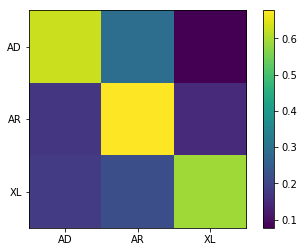

Number of AD 116
Number of AR 127
Number of XL 81
AD Accuracy: 0.6293103448275862
AR Accuracy: 0.6771653543307087
XL Accuracy: 0.5925925925925926
Cohen Kappa 0.44687308489217026


In [32]:
confusionMatrix( predicted, true, [ 'AD', 'AR', 'XL' ] )

In [ ]:
over_one_affected = [ r for r in results if r[ 0 ][ 0 ].getNumbAffected() > 1 ]

In [ ]:
_, predicted, true, _, _, _, _ = list( zip( *over_one_affected ) )
predicted = np.array( predicted )
true = np.array( true )

labels = [ 'AD', 'AR', 'XL' ]
confusionMatrix( predicted, true, labels )

In [ ]:
def confidenceEval( all_of_level ):
    predicted, true = [], []
    for graph, pred, tru, probs in itertools.chain( *all_of_level ):
        predicted.append( pred )
        true.append( tru )
    predicted = np.array( predicted )
    true = np.array( true )
    confusionMatrix( predicted, true, labels )

In [ ]:
all_confident = ad_confident_correct, ad_confident_wrong, ar_confident_correct, ar_confident_wrong, xl_confident_correct, xl_confident_wrong
confidenceEval( all_confident )

In [ ]:
all_sorta_confident = ad_sorta_confident_correct, ad_sorta_confident_wrong, ar_sorta_confident_correct, ar_sorta_confident_wrong, xl_sorta_confident_correct, xl_sorta_confident_wrong
confidenceEval( all_sorta_confident )

In [ ]:
all_unconfident = ad_unconfident_correct, ad_unconfident_wrong, ar_unconfident_correct, ar_unconfident_wrong, xl_unconfident_correct, xl_unconfident_wrong
confidenceEval( all_unconfident )

In [ ]:
# assert 0

In [ ]:
def saveGraphs( results, folder_name ):
    for ( graph, fbs ), predicted, _, prob in results:
        d = graph.draw()
        name = folder_name + '/%s__AD_%1.2f_AR_%1.2f_XL_%1.2f'%( graph.studyID, prob[ 0 ], prob[ 1 ], prob[ 2 ] )
        d.render( name, view=False, cleanup=True )

In [ ]:
saveGraphs( ad_confident_correct, 'ad_confident_correct' )
saveGraphs( ad_confident_wrong, 'ad_confident_wrong' )
saveGraphs( ad_sorta_confident_correct, 'ad_sorta_confident_correct' )
saveGraphs( ad_sorta_confident_wrong, 'ad_sorta_confident_wrong' )
saveGraphs( ad_unconfident_correct, 'ad_unconfident_correct' )
saveGraphs( ad_unconfident_wrong, 'ad_unconfident_wrong' )

saveGraphs( ar_confident_correct, 'ar_confident_correct' )
saveGraphs( ar_confident_wrong, 'ar_confident_wrong' )
saveGraphs( ar_sorta_confident_correct, 'ar_sorta_confident_correct' )
saveGraphs( ar_sorta_confident_wrong, 'ar_sorta_confident_wrong' )
saveGraphs( ar_unconfident_correct, 'ar_unconfident_correct' )
saveGraphs( ar_unconfident_wrong, 'ar_unconfident_wrong' )

saveGraphs( xl_confident_correct, 'xl_confident_correct' )
saveGraphs( xl_confident_wrong, 'xl_confident_wrong' )
saveGraphs( xl_sorta_confident_correct, 'xl_sorta_confident_correct' )
saveGraphs( xl_sorta_confident_wrong, 'xl_sorta_confident_wrong' )
saveGraphs( xl_unconfident_correct, 'xl_unconfident_correct' )
saveGraphs( xl_unconfident_wrong, 'xl_unconfident_wrong' )

In [ ]:
assert 0, 'This is the end of the analysis with only pedigree data'

In [299]:
import pandas as pd 

df = pd.read_csv( 'pedigreeAnswers.csv' )
df_labels = pd.read_csv( 'Complete_pedigree_data.csv' )

# Set the labels for the regular df
for studyID, IP in df_labels[ [ 'Patient ID', 'Inheritance Pattern' ] ].values:
    if( studyID in df[ 'Patient ID' ].values ):
        index = df.index[ df[ 'Patient ID' ] == studyID ][ 0 ]
        df.loc[ index, 'IP' ] = IP

# Drop nan inheritance patterns
bad_mask = df[ 'IP' ].isna()
df = df[ ~bad_mask ]

# Load the ghmm results
results = pickle.load( open( 'full_results.p', 'rb' ) )

# Add the extra features from the ghmm
for ( graph, _ ), _, _, p in sorted( results, key=lambda x: x[ 0 ][ 0 ].studyID ):
    if( graph.studyID in df[ 'Patient ID' ].values ):
        index = df.index[ df[ 'Patient ID' ] == graph.studyID ][ 0 ]
        df.loc[ index, 'AD_Prob' ] = p[ 0 ]
        df.loc[ index, 'AR_Prob' ] = p[ 1 ]
        df.loc[ index, 'XL_Prob' ] = p[ 2 ]
        df.loc[ index, 'nMales' ] = len( [ 1 for n in graph.nodes if graph.attrs[ n ][ 'sex' ] == 'male' ] )
        df.loc[ index, 'nFemales' ] = len( [ 1 for n in graph.nodes if graph.attrs[ n ][ 'sex' ] == 'female' ] )
        df.loc[ index, 'nUnknowns' ] = len( [ 1 for n in graph.nodes if graph.attrs[ n ][ 'sex' ] == 'unknown' ] )
        if( not graph.inheritancePattern == df.loc[ index, 'IP' ] ):
            print( 'graph.inheritancePattern', graph.inheritancePattern )
            print( 'df.loc[ index, \'IP\' ]', df.loc[ index, 'IP' ] )
            assert 0

# Use these features
keep_cols = [ 'Patient ID',
              'numAff',
              'multGenAff',
              'MAffSon',
              'MAffDau',
              'skipping',
              'sibAff',
              'halfSibAff',
              'cousAff',
              'MFAff',
              'ons20M',
              'multDx',
              'consang',
              'nMales',
              'nFemales',
              'nUnknowns',
              'AD_Prob',
              'AR_Prob',
              'XL_Prob',
              'IP' ]

# Drop the rows that we don't have ghmm results for
df = df[ keep_cols ].dropna()
df = df.set_index( 'Patient ID' )

# Drop inheritance patterns that aren't AD, AR or XL
mask = df[ 'IP' ] == 'AD'
mask |= df[ 'IP' ] == 'AR'
mask |= df[ 'IP' ] == 'XL'
df = df[ mask ]

In [300]:
df

numAff  multGenAff  MAffSon  MAffDau  skipping  sibAff  \
Patient ID                                                                
1022AS                1       False    False    False         1       1   
1036RC                1       False    False    False         1       1   
1046DA                4        True    False    False         3       1   
1075NP                3        True    False    False         2       3   
1084LN                8        True     True     True         2       3   
1089JB                6        True    False    False         2       1   
164KD                 2       False    False    False         1       1   
167MW                 3        True    False    False         1       3   
189DC                 2        True    False     True         1       1   
2003PB                2       False    False    False         1       1   
2016CH                4       False    False    False         1       3   
2042JD                1       False    False    False         1       1   
2055JS                1       False    False    False         1       1   
2065GE                2        True    False    False         2       1   
2079NC                6        True     True     True         1       1   
208CM                 1       False    False    False         1       1   
2093SA                2       False    False    False         1       2   
2094KA                2       False    False    False         1       2   
230KK                 1       False    False    False         1       1   
231AG                 2       False    False    False         1       1   
253BW                 1       False    False    False         1       1   
260MG                 1       False    False    False         1       1   
277DP                 1       False    False    False         1       1   
3005CV                1       False    False    False         1       1   
3008ML                1       False    False    False         1       1   
3009DD                6        True    False    False         1       3   
302KW                 3        True    False    False         2       1   
3045RK                1       False    False    False         1       1   
3061JE                2       False    False    False         1       2   
3065BB                1       False    False    False         1       1   
...                 ...         ...      ...      ...       ...     ...   
NEI_INVRP075DR0       5        True    False     True         1       3   
NEI_INVRW032HP6       1       False    False    False         1       1   
NEI_INVRZ998GAH       2        True    False    False         1       1   
NEI_INVTD470RL4      11        True     True     True         3       1   
NEI_INVTE607VYA       1       False    False    False         1       1   
NEI_INVTF299VC2       2        True    False    False         2       1   
NEI_INVTJ109AY9       1       False    False    False         1       1   
NEI_INVTM269RXM       1       False    False    False         1       1   
NEI_INVTP921JLT       6        True     True     True         1       1   
NEI_INVTR106KDR       9        True     True     True         1       3   
NEI_INVTU321XN5       7        True     True     True         3       3   
NEI_INVTV167NUE      13        True    False    False         1       3   
NEI_INVUP593ZEZ       3        True    False    False         2       1   
NEI_INVUY628MYF       5        True    False    False         2       3   
NEI_INVVA212BAL      11        True    False    False         1       1   
NEI_INVVA744LZ4       3        True    False    False         2       3   
NEI_INVVD274UGD       1       False    False    False         1       1   
NEI_INVVD368XUB       5        True     True     True         3       1   
NEI_INVVD680TNA       5        True    False     True         1       1   
NEI_INVVF245NUH       4        True    False    False         1       1   
NEI_INVVH314FE8       6        True     Tr

In [306]:
confident_mask = df[ [ 'AD_Prob', 'AR_Prob', 'XL_Prob' ] ].max( axis=1 ) > 0.8
confident_df = df[ confident_mask ]

In [317]:
def stripProb( col ):
    return col.replace( '_Prob', '' )
confident_df[ 'Prediction' ] = confident_df[ [ 'AD_Prob', 'AR_Prob', 'XL_Prob' ] ].idxmax( axis=1 ).apply( stripProb )

/anaconda3/envs/GenModel/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [318]:
confident_df

numAff  multGenAff  MAffSon  MAffDau  skipping  sibAff  \
Patient ID                                                                
1022AS                1       False    False    False         1       1   
1046DA                4        True    False    False         3       1   
1084LN                8        True     True     True         2       3   
1089JB                6        True    False    False         2       1   
167MW                 3        True    False    False         1       3   
189DC                 2        True    False     True         1       1   
2042JD                1       False    False    False         1       1   
2065GE                2        True    False    False         2       1   
2079NC                6        True     True     True         1       1   
253BW                 1       False    False    False         1       1   
3005CV                1       False    False    False         1       1   
3009DD                6        True    False    False         1       3   
302KW                 3        True    False    False         2       1   
3075EZ                7        True     True     True         1       3   
3113GT                1       False    False    False         1       1   
3183DG                3        True    False     True         1       1   
3235JW                6        True    False    False         3       3   
3239PB                5        True    False    False         2       3   
3308WM                1       False    False    False         1       1   
3359RG                7        True    False    False         2       3   
3489ZM                4        True    False    False         2       3   
3490IM                4        True    False    False         2       3   
3726LN                3        True    False     True         2       1   
3738KW                3        True     True     True         1       1   
374CR                 6        True    False     True         1       3   
377LP                 6        True    False    False         2       1   
3814CB                3        True    False     True         3       1   
384TD                 7        True    False    False         2       1   
3930EM               14        True     True     True         2       3   
3962TD                5        True    False     True         1       1   
...                 ...         ...      ...      ...       ...     ...   
NEI_INVMH904EE7       3        True    False    False         3       3   
NEI_INVMK954UYF       4        True    False    False         3       3   
NEI_INVMT995EXP       2        True    False    False         1       1   
NEI_INVNJ698LV9       3        True    False    False         2       3   
NEI_INVPK543BV8       8        True    False     True         1       3   
NEI_INVPL331URV       4        True    False    False         2       1   
NEI_INVPM894DVL      13        True    False    False         1       3   
NEI_INVPN452HD6       7        True    False    False         3       1   
NEI_INVPP431KL5       4        True    False    False         1       3   
NEI_INVPP853XK1       8        True    False    False         2       1   
NEI_INVPW823HD8      15        True    False    False         1       3   
NEI_INVRG706LW7       2       False    False    False         1       1   
NEI_INVRL483BHK       2        True    False    False         1       1   
NEI_INVRP075DR0       5        True    False     True         1       3   
NEI_INVRW032HP6       1       False    False    False         1       1   
NEI_INVRZ998GAH       2        True    False    False         1       1   
NEI_INVTD470RL4      11        True     True     True         3       1   
NEI_INVTP921JLT       6        True     True     True         1       1   
NEI_INVTR106KDR       9        True     True     True         1       3   
NEI_INVTU321XN5       7        True     True     True         3       3   
NEI_INVTV167NUE      13        True    Fal

[[68 12  4]
 [18 22 14]
 [12  4 42]]
[[0.80952381 0.14285714 0.04761905]
 [0.33333333 0.40740741 0.25925926]
 [0.20689655 0.06896552 0.72413793]]


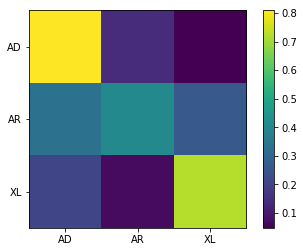

Number of AD 84
Number of AR 54
Number of XL 58
AD Accuracy: 0.8095238095238095
AR Accuracy: 0.4074074074074074
XL Accuracy: 0.7241379310344828
Cohen Kappa 0.49115690410514357


In [321]:
confusionMatrix( true=confident_df[ 'IP' ], predicted=confident_df[ 'Prediction' ], labels=[ 'AD', 'AR', 'XL' ] )

In [352]:
def examineIP( mask ):
    vals = [ labels.index( i ) for i in confident_df[ mask ].IP.values ]
    display( plt.hist( vals ) )

(array([11.,  0.,  0.,  0.,  0.,  9.,  0.,  0.,  0., 29.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <a list of 10 Patch objects>)

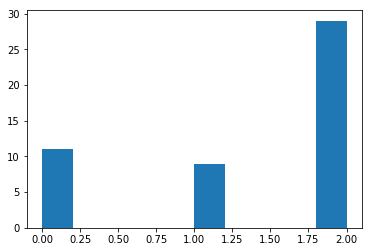

In [353]:
examineIP( confident_df[ 'skipping' ] == 2 )

(array([2., 0., 0., 0., 0., 2., 0., 0., 0., 2.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <a list of 10 Patch objects>)

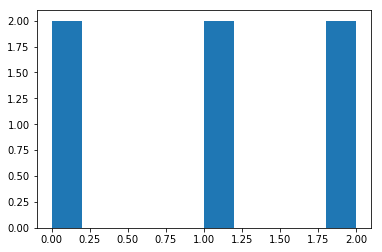

In [354]:
examineIP( confident_df[ 'consang' ] )

(array([79.,  0.,  0.,  0.,  0., 28.,  0.,  0.,  0., 46.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <a list of 10 Patch objects>)

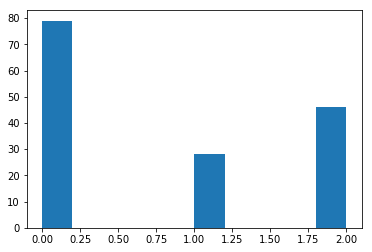

In [355]:
examineIP( confident_df[ 'multGenAff' ] )

(array([31.,  0.,  0.,  0.,  0.,  6.,  0.,  0.,  0.,  3.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <a list of 10 Patch objects>)

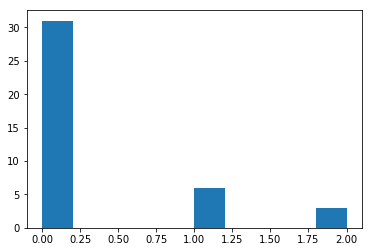

In [356]:
examineIP( confident_df[ 'MAffSon' ] )

(array([38.,  0.,  0.,  0.,  0.,  8.,  0.,  0.,  0.,  6.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <a list of 10 Patch objects>)

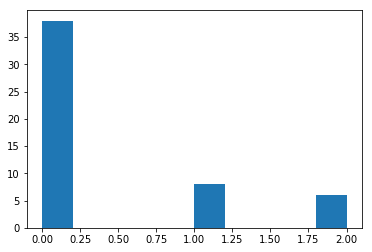

In [357]:
examineIP( confident_df[ 'MAffDau' ] )

(array([13.,  0.,  0.,  0.,  0.,  8.,  0.,  0.,  0.,  4.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <a list of 10 Patch objects>)

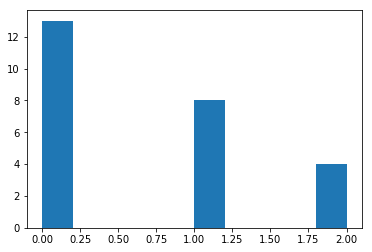

In [358]:
examineIP( confident_df[ 'skipping' ] == 3 )

In [359]:
all_confident

[((<GenModels.research.PedigreeWrappers.Pedigree at 0x11b421940>,
   array([], dtype=float64)),
  'AD',
  'AD',
  array([9.99985540e-01, 4.83511502e-06, 9.62447691e-06])),
 ((<GenModels.research.PedigreeWrappers.Pedigree at 0x11b6032b0>,
   array([], dtype=float64)),
  'AD',
  'AD',
  array([1.00000000e+00, 3.14051895e-20, 1.62578186e-27])),
 ((<GenModels.research.PedigreeWrappers.Pedigree at 0x11b6a2fd0>,
   array([], dtype=float64)),
  'AD',
  'AD',
  array([9.99999999e-01, 5.87650955e-10, 7.49819946e-11])),
 ((<GenModels.research.PedigreeWrappers.Pedigree at 0x11a3026a0>,
   array([], dtype=float64)),
  'AD',
  'AD',
  array([1.00000000e+00, 8.99878744e-15, 4.31599928e-23])),
 ((<GenModels.research.PedigreeWrappers.Pedigree at 0x11a4ddba8>,
   array([], dtype=float64)),
  'AD',
  'AD',
  array([1.00000000e+00, 2.45463662e-36, 4.38610098e-43])),
 ((<GenModels.research.PedigreeWrappers.Pedigree at 0x119eca940>,
   array([], dtype=float64)),
  'AD',
  'AD',
  array([1.00000000e+00, 1.5

In [364]:
import csv
with open('confident_names.csv', 'w') as csvfile:
    writer = csv.writer(csvfile, delimiter=' ', quotechar='|', quoting=csv.QUOTE_MINIMAL)
    
    for ( graph, fbs ), _, _, _ in all_confident:
        writer.writerow( [ str( graph.studyID ) ] )
        print( graph.studyID )
#     spamwriter.writerow(['Spam'] * 5 + ['Baked Beans'])
#     spamwriter.writerow(['Spam', 'Lovely Spam', 'Wonderful Spam'])

849SS
3962TD
NEI_INVVH314FE8
NEI_INVEP077KRQ
NEI_INVLR991GGT
5808SL
3075EZ
918TB
988FT
852BB
991KH
NEI_INVKP170XZH
5349AW
2079NC
1046DA
NEI_INVPW823HD8
919KB
374CR
NEI_INVZB638WT9
643SB
843BC
NEI_INVFF850PPA
6087SR
4747ZR
NEI_INVWB058TN4
NEI_INVTP921JLT
5665PB
5571JF
5046IL
5633JK
NEI_INVLG919LXT
4363LR
3009DD
4954DK
3726LN
6156AK
4272DG
NEI_INVTU321XN5
NEI_INVCF058JDH

NEI_INVGB238BTY
NEI_INVRP075DR0
NEI_INVEN150MG6
NEI_INVLU847DCX
3738KW
NEI_INVPM894DVL
4982RL
5273BR
4256JT
5252SR
NEI_INVYP210BUJ
989NT
NEI_INVHG282EN1
1084LN
3814CB
NEI_INVEK698MP1
5348DW
189DC
NEI_INVRL483BHK
NEI_INVHE305BX1
506JA
5543ES
4781RM
951RP
NEI_INVTV167NUE
4754LK
NEI_INVTR106KDR
4978SS
NEI_INVWE417LNR
NEI_INVER365TNE
4460TK
3930EM
NEI_INVVA212BAL
5783CC
3183DG
6212SD
NEI_INVAJ998CWH
NEI_INVKE437DH4
4599LB
NEI_INVMT995EXP
5045DH
5892JB
5867KA
NEI_INVRW032HP6
3235JW
NEI_INVDV551CK8
4951DK
4210AW
5904SC
611JC
5777AH
4984TC
NEI_INVEL589CHQ
2042JD
771KG
NEI_INVLD750EXK
5768PP
5811AC
4609DB
167MW
NEI_INVZE223GZ1


In [37]:
for ( graph, fbs ), _, _, _ in all_confident:
    if( graph.studyID == '302KW' ):
        assert 0

AssertionError: 

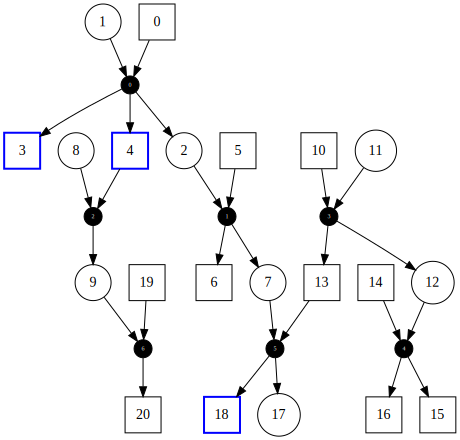

In [38]:
graph.draw()

In [50]:
graph_copy = copy.deepcopy( graph )
graph_copy.useDiagnosisImplication( 'XL' )

model = XLinkedRecessive( [ ( graph_copy, np.array( [] ) ) ], root_strength=10000000000, prior_strength=1000000000, method='EM' )
node_smoothed, marginal = model.stateUpdate()
model.msg.cleanup()

print( marginal )
sorted( node_smoothed.items() )

-28.14142700820244


[(0, array([6.7196237e-22, 1.0000000e+00])),
 (1, array([6.85533282e-09, 9.99999993e-01, 1.85804200e-15])),
 (2, array([1.54946722e-28, 9.99999989e-01, 1.13856300e-08])),
 (3, array([1., 0.])),
 (4, array([1., 0.])),
 (5, array([3.35984134e-21, 1.00000000e+00])),
 (6, array([2.53407661e-11, 1.00000000e+00])),
 (7, array([1.00199345e-17, 9.99999988e-01, 1.23145998e-08])),
 (8, array([4.02315432e-28, 3.84167553e-11, 1.00000000e+00])),
 (9, array([2.19078616e-29, 9.99999999e-01, 1.47851465e-09])),
 (10, array([1.67969231e-22, 1.00000000e+00])),
 (11, array([1.52177277e-30, 2.40092994e-11, 1.00000000e+00])),
 (12, array([1.28229812e-38, 1.00652851e-10, 1.00000000e+00])),
 (13, array([1.59060701e-20, 1.00000000e+00])),
 (14, array([6.71920477e-22, 1.00000000e+00])),
 (15, array([3.37534108e-20, 1.00000000e+00])),
 (16, array([3.37534108e-20, 1.00000000e+00])),
 (17, array([1.84228571e-19, 4.99991264e-01, 5.00008736e-01])),
 (18, array([1., 0.])),
 (19, array([6.71910074e-22, 1.00000000e+00]

In [48]:
graph_copy = copy.deepcopy( graph )
graph_copy.useDiagnosisImplication( 'AR' )

model = AutosomalRecessive( [ ( graph_copy, np.array( [] ) ) ], root_strength=10000000000, prior_strength=1000000000, method='EM' )
node_smoothed, marginal = model.stateUpdate()
model.msg.cleanup()

print( marginal )
sorted( node_smoothed.items() )

-59.66129623725582


[(0, array([8.00542321e-16, 1.99783443e-06, 9.99998002e-01])),
 (1, array([8.00547063e-16, 1.99783794e-06, 9.99998002e-01])),
 (2, array([5.64368684e-17, 1.36121800e-06, 9.99998639e-01])),
 (3, array([1., 0., 0.])),
 (4, array([1., 0., 0.])),
 (5, array([2.45669657e-21, 1.57185196e-11, 1.00000000e+00])),
 (6, array([1.79658460e-19, 6.81728144e-07, 9.99999318e-01])),
 (7, array([3.02042334e-20, 7.24139554e-07, 9.99999276e-01])),
 (8, array([2.24243814e-30, 7.37110351e-12, 1.00000000e+00])),
 (9, array([4.58151911e-20, 1.00000000e+00, 3.65657205e-10])),
 (10, array([1.14732078e-19, 3.97206174e-10, 1.00000000e+00])),
 (11, array([1.14732078e-19, 3.97218425e-10, 1.00000000e+00])),
 (12, array([1.79658450e-19, 1.48663573e-09, 9.99999999e-01])),
 (13, array([1.24920325e-17, 5.83948857e-08, 9.99999942e-01])),
 (14, array([2.16941142e-21, 1.47423874e-11, 1.00000000e+00])),
 (15, array([1.79658449e-19, 1.84012997e-09, 9.99999998e-01])),
 (16, array([1.79658449e-19, 1.84012997e-09, 9.99999998e-0

In [49]:
graph_copy = copy.deepcopy( graph )
graph_copy.useDiagnosisImplication( 'AD' )

model = AutosomalDominant( [ ( graph_copy, np.array( [] ) ) ], root_strength=10000000000, prior_strength=1000000000, method='EM' )
node_smoothed, marginal = model.stateUpdate()
model.msg.cleanup()

print( marginal )
sorted( node_smoothed.items() )

-59.64904244754603


[(0, array([2.82735733e-12, 3.95866031e-04, 9.99604134e-01])),
 (1, array([3.06764418e-13, 3.95879760e-04, 9.99604120e-01])),
 (2, array([2.19618803e-30, 5.62000472e-13, 1.00000000e+00])),
 (3, array([0., 1., 0.])),
 (4, array([0., 1., 0.])),
 (5, array([2.06144922e-30, 7.23575766e-21, 1.00000000e+00])),
 (6, array([3.06555134e-20, 2.45952818e-18, 1.00000000e+00])),
 (7, array([1.02769529e-20, 2.10688744e-10, 1.00000000e+00])),
 (8, array([1.19643819e-29, 1.34970026e-20, 1.00000000e+00])),
 (9, array([8.47332582e-28, 4.21285758e-10, 1.00000000e+00])),
 (10, array([1.73159776e-30, 7.23575765e-21, 1.00000000e+00])),
 (11, array([1.80800955e-31, 7.23528979e-21, 1.00000000e+00])),
 (12, array([2.93433597e-38, 6.14725261e-19, 1.00000000e+00])),
 (13, array([4.14869611e-20, 2.10650905e-10, 1.00000000e+00])),
 (14, array([1.12798161e-37, 6.74864222e-21, 1.00000000e+00])),
 (15, array([3.06555134e-20, 2.45905460e-18, 1.00000000e+00])),
 (16, array([3.06555134e-20, 2.45905460e-18, 1.00000000e+0